In [2]:
#Method from: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
#pip3 install stanza
#pip3 install xgboost
#pip3 install fasttext
#pip3 install fasttext-wheel
%matplotlib inline

import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random
import stanza
import re


from class_metric import Metrics

import sklearn
sklearn.__version__
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras import utils


import itertools
from textblob import TextBlob 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
sns.set(style="darkgrid")


import string
import fasttext
import fasttext.util
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()

Metric = Metrics()

0it [00:00, ?it/s]


In [3]:
lang                   = False
sample                 = True
part_of_speech         = False
multinomial_naive_bayes= True
logistic_regression    = True
svm_model              = True
k_nn_model             = True
sgd                    = True
random_forest          = True
gradient_boosting      = True
xgboost_classifier     = True
shallow_network        = True
deep_nn                = True
rnn                    = True
lstm                   = True
cnn                    = True
gru                    = True
cnn_lstm               = True
cnn_gru                = True
bidirectional_rnn      = True
bidirectional_lstm     = True
bidirectional_gru      = True
rcnn                   = True
pre_trained            = False

In [4]:
import pandas as pd
import numpy
df = pd.read_csv("Merged Data.csv")
df['Result']=df['Result'].replace('yes', 1)
df['Result']=df['Result'].replace('no', 0)
df

Unnamed: 0                                       Cleaned Text  Result  \
0              0  every day millions people worldwide use enjoy ...       1   
1              1  privacy policy apply properties includingactiv...       1   
2              2  vision valid licensee participate member enter...       1   
3              3  activision collect information source set grea...       0   
4              4  activision knowingly collect store personal in...       1   
...          ...                                                ...     ...   
1485        1489  may also certain right regard information hold...       1   
1486        1490  service may time time contain link websites pa...       1   
1487        1491  keep change legislation best practice change p...       1   
1488        1492  please send question comment request policy pr...       1   
1489        1493  feel address question concern adequately belie...       1   

        id  
0        0  
1        1  
2        2  
3        3  
4        4  
...    ...  
1485  1489  
1486  1490  
1487  1491  
1488  1492  
1489  1493  

[1490 rows x 4 columns]

In [5]:
sentences=df['Cleaned Text'].values
y = df.Result.values

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

In [7]:
# split the dataset into training and validation datasets 
# ML classic 
train_x_sw, valid_x_sw, y_train_sw, y_valid_sw = model_selection.train_test_split(sentences+"_sw", y, random_state=42, stratify=y, test_size=0.2)

# For Embeddings
train_x, valid_x, y_train, y_valid = model_selection.train_test_split(sentences, y, random_state=42, stratify=y, test_size=0.2)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_sw = encoder.fit_transform(y_train_sw)
valid_y_sw = encoder.fit_transform(y_valid_sw)
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

In [8]:
# Keep the unique label corresponding to their encoding correspondance
labels = df['Result'].unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()
if any(str(i).isdigit() for i in labels) and len(labels)==2:
    labels = ["negative", "positive"]

In [9]:
%%time
# create a One-Hot encoding object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(sentences+"_sw")

# transform the training and validation data 
xtrain_count =  count_vect.transform(train_x_sw)
xvalid_count =  count_vect.transform(valid_x_sw)

CPU times: total: 109 ms
Wall time: 111 ms


In [10]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df["Cleaned Text"])
xtrain_tfidf =  tfidf_vect.transform(train_x_sw)
xvalid_tfidf =  tfidf_vect.transform(valid_x_sw)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df["Cleaned Text"])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x_sw)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x_sw)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=5000) 
tfidf_vect_ngram_chars.fit(df["Cleaned Text"])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x_sw) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x_sw) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done
CPU times: total: 2.03 s
Wall time: 2.03 s


In [12]:
#wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
#unzip crawl-300d-2M-subword.zip
fasttext.util.download_model('en', if_exists='ignore') # English
pretrained= fasttext.load_model('cc.en.300.bin')

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [13]:
%%time 
# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(df["Cleaned Text"])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|████████████████████████████████████████████████████████████████████████████| 6435/6435 [00:06<00:00, 1010.23it/s]

CPU times: total: 875 ms
Wall time: 6.67 s


In [14]:
def metrics_ML(clf, X, Y, X_test, Y_test, gb=False):
    '''
    Function to compute a classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    model_, pred, time_train, score_ = classifier_model(clf, X, Y, X_test, Y_test)
    print("Execution time : %.3f s" %(time_train))
    print(f"Score : {round(100*score_,2)} %" )
    print("\nClassification Report\n")
    print(classification_report(Y_test, pred, target_names=labels))
    cm = confusion_matrix(Y_test, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)
    print("\n")
    Metric.precision_recall_curve(model_,  X_test, Y_test, labels, gb=gb)
    print("\n")
    Metric.roc_auc_curve(model_,  X_test, Y_test, labels, gb=gb)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(Y_test,  pred),2)}%\n\n")

In [15]:
def classifier_model(clf, X, y, x_test, y_test):
    '''
    Function to compute a classifier model
    @param clf: (model) classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    
    start = time.time()
    clf.fit(X, y)
    end = time.time() - start
    pred = clf.predict(x_test)
    
    #accuracy = accuracy_score(y_test, pred)
    
    return clf, pred, end, clf.score(x_test, y_test)#, accuracy


Multinomial Naive Bayes for One-Hot encoding

Execution time : 0.138 s
Score : 78.52 %

Classification Report

              precision    recall  f1-score   support

    negative       0.57      0.42      0.48        71
    positive       0.83      0.90      0.86       227

    accuracy                           0.79       298
   macro avg       0.70      0.66      0.67       298
weighted avg       0.77      0.79      0.77       298


Confusion Matrix





Model: f1-score=0.864 AUC=0.903




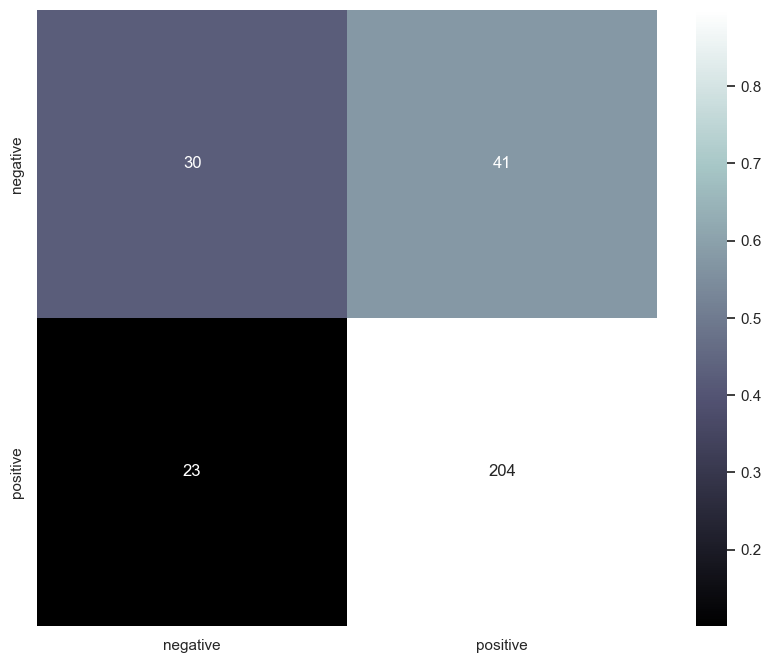

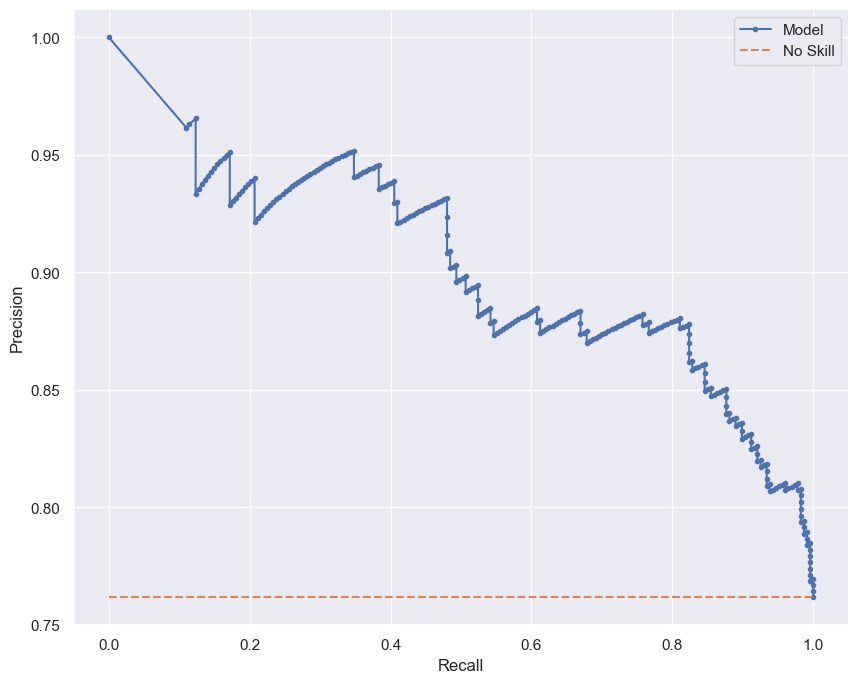




ROC AUC=0.768 



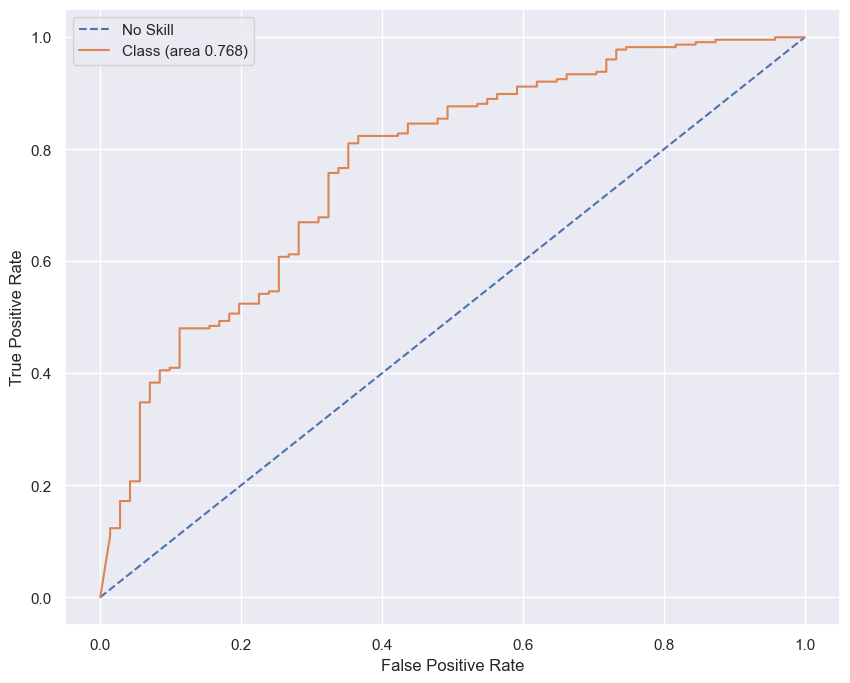



Cohen's kappa: 35.19%




In [16]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for One-Hot encoding\n")
    metrics_ML(naive_bayes.MultinomialNB(), xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Multinomial Naive Bayes for TF-IDF

Execution time : 0.012 s
Score : 76.17 %

Classification Report

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        71
    positive       0.76      1.00      0.86       227

    accuracy                           0.76       298
   macro avg       0.38      0.50      0.43       298
weighted avg       0.58      0.76      0.66       298


Confusion Matrix





Model: f1-score=0.865 AUC=0.895




C:\Users\omarb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omarb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omarb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


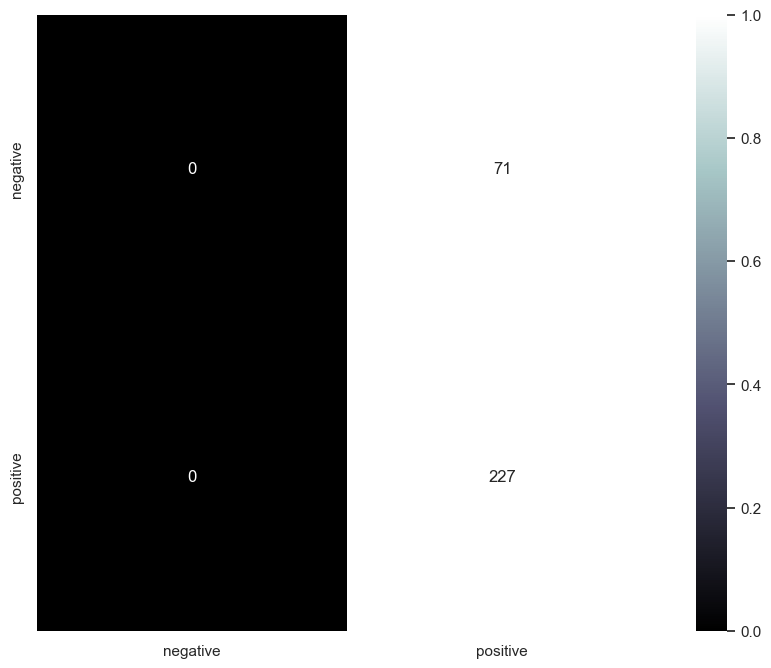

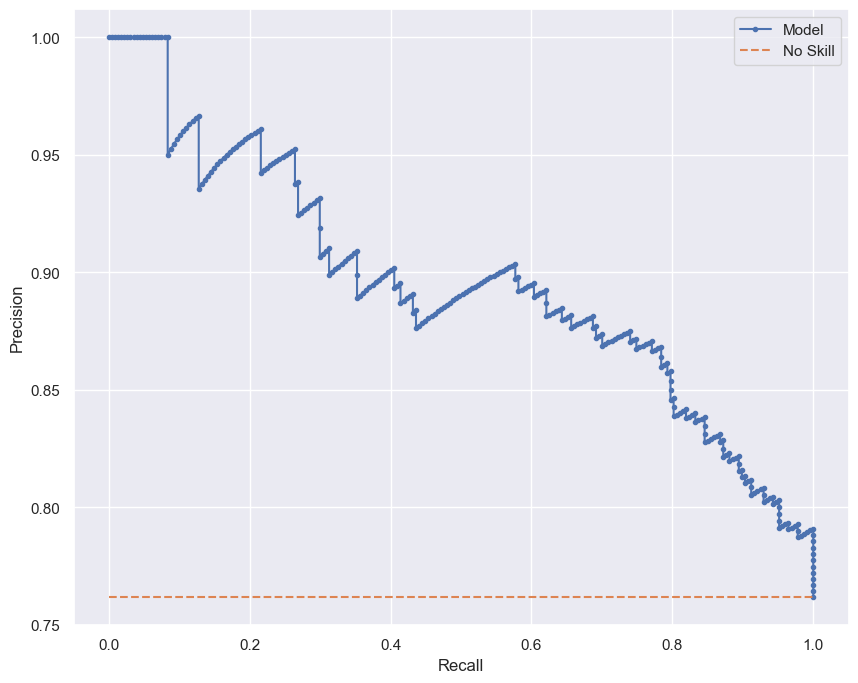




ROC AUC=0.745 



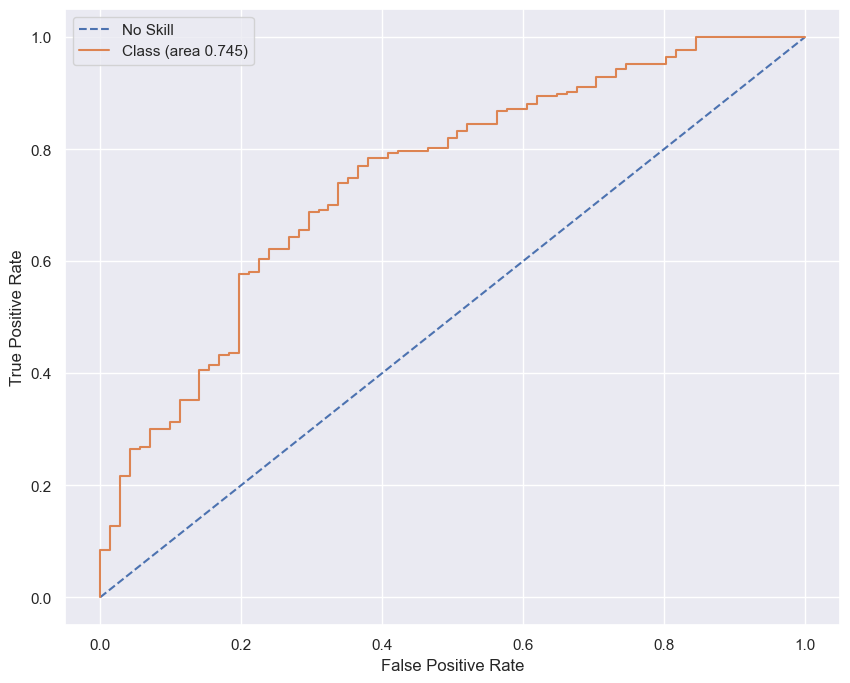



Cohen's kappa: 0.0%




In [17]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for TF-IDF\n")
    metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Multinomial Naive Bayes for TF-IDF n-grams

Execution time : 0.014 s
Score : 78.86 %

Classification Report

              precision    recall  f1-score   support

    negative       0.79      0.15      0.26        71
    positive       0.79      0.99      0.88       227

    accuracy                           0.79       298
   macro avg       0.79      0.57      0.57       298
weighted avg       0.79      0.79      0.73       298


Confusion Matrix





Model: f1-score=0.877 AUC=0.872




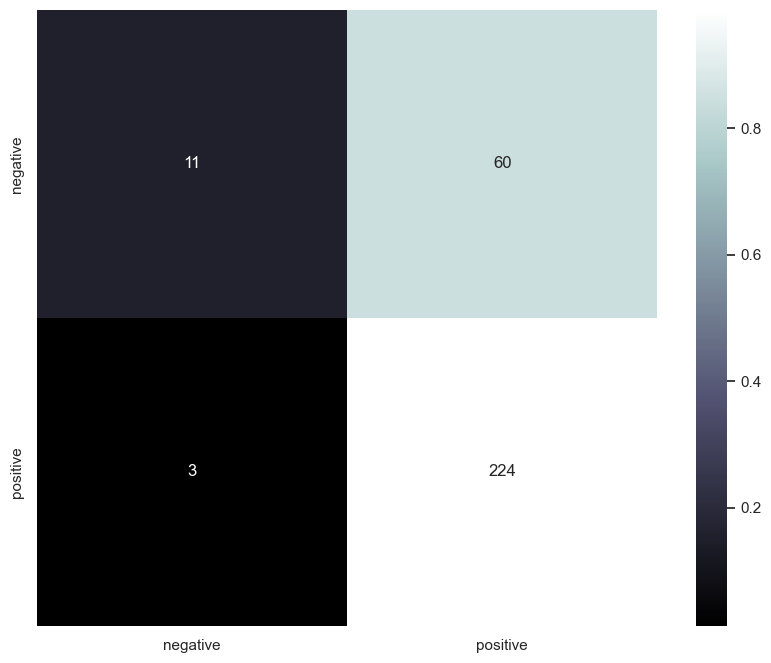

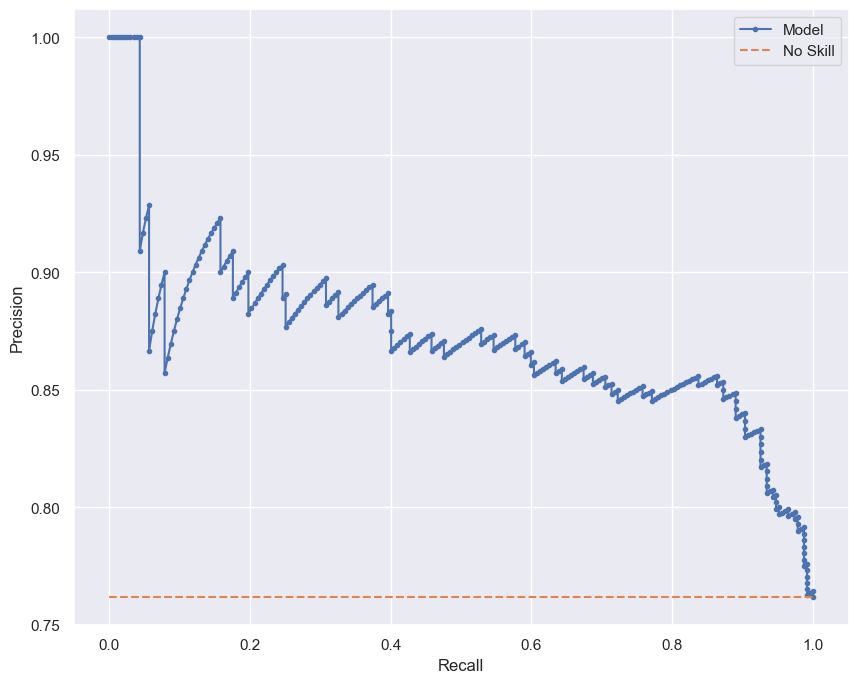




ROC AUC=0.722 



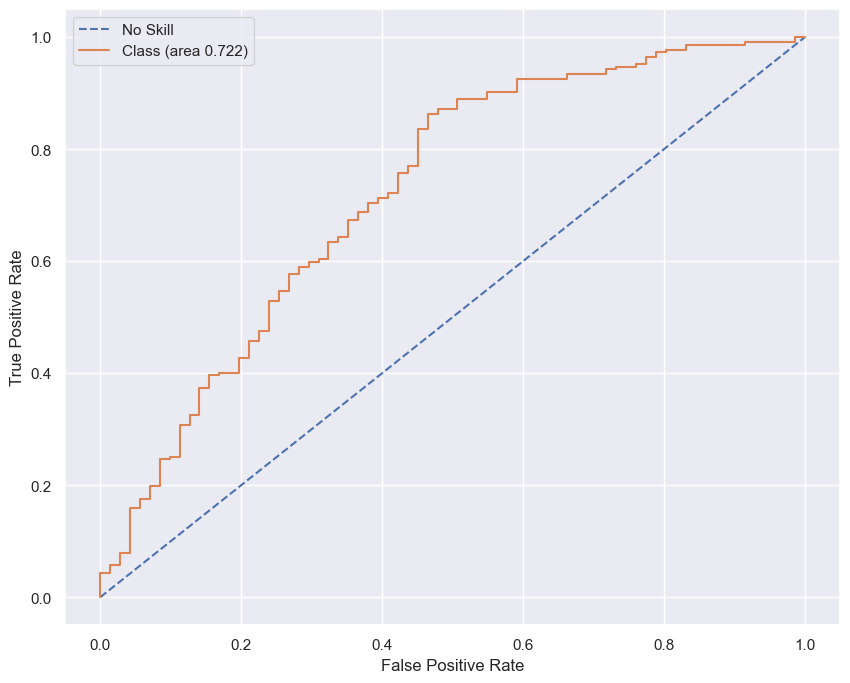



Cohen's kappa: 19.57%




In [18]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for TF-IDF n-grams\n")
    metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Multinomial Naive Bayes for TF-IDF char n-grams

Execution time : 0.037 s
Score : 76.17 %

Classification Report

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        71
    positive       0.76      1.00      0.86       227

    accuracy                           0.76       298
   macro avg       0.38      0.50      0.43       298
weighted avg       0.58      0.76      0.66       298


Confusion Matrix





Model: f1-score=0.865 AUC=0.858




C:\Users\omarb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omarb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omarb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


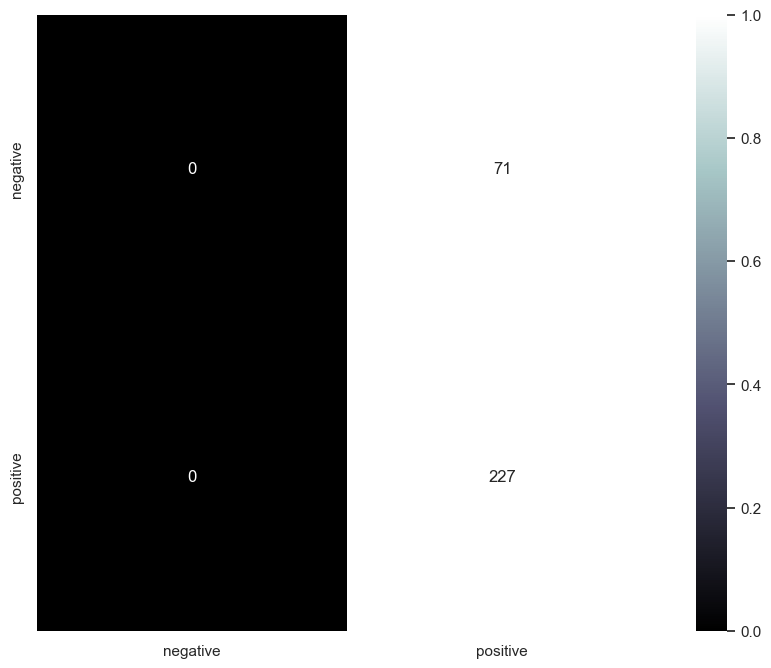

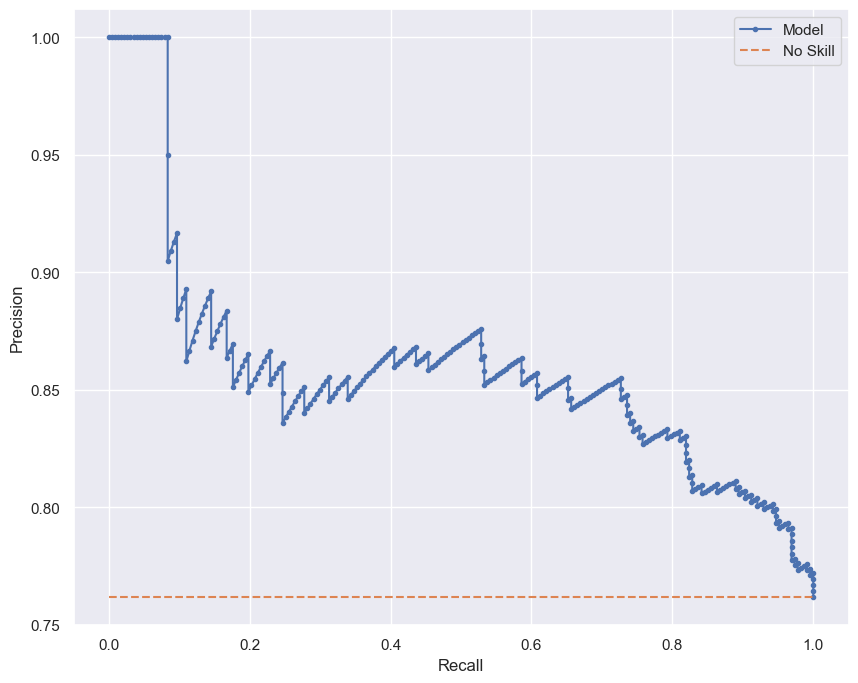




ROC AUC=0.683 



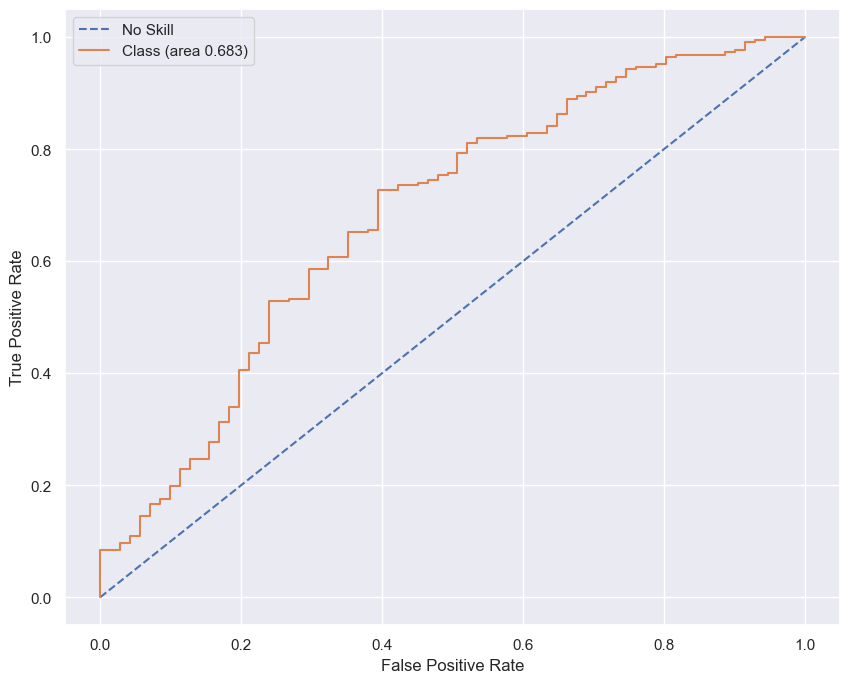



Cohen's kappa: 0.0%




In [19]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for TF-IDF char n-grams\n")
    metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)


Logistic Regression for One-Hot encoding

Execution time : 0.764 s
Score : 78.52 %

Classification Report

              precision    recall  f1-score   support

    negative       0.57      0.39      0.47        71
    positive       0.83      0.91      0.87       227

    accuracy                           0.79       298
   macro avg       0.70      0.65      0.67       298
weighted avg       0.77      0.79      0.77       298


Confusion Matrix





Model: f1-score=0.866 AUC=0.913




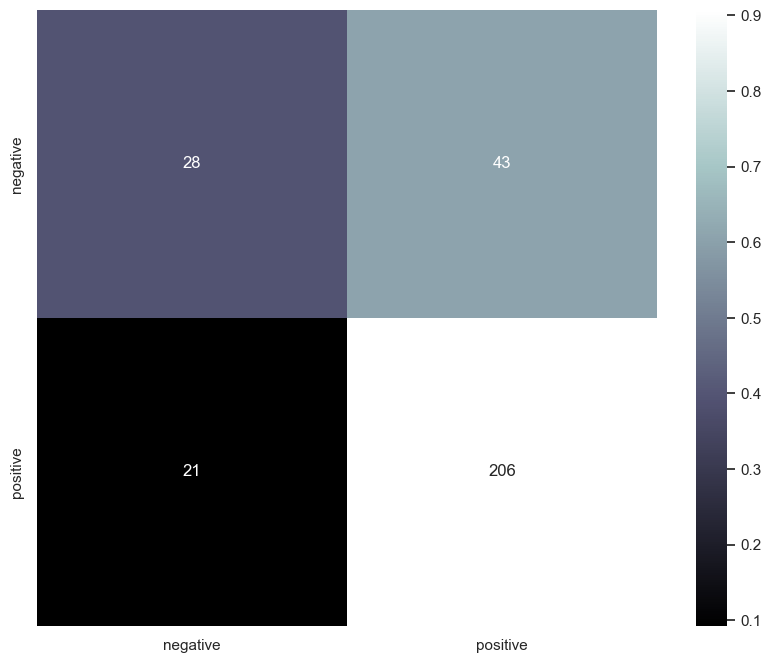

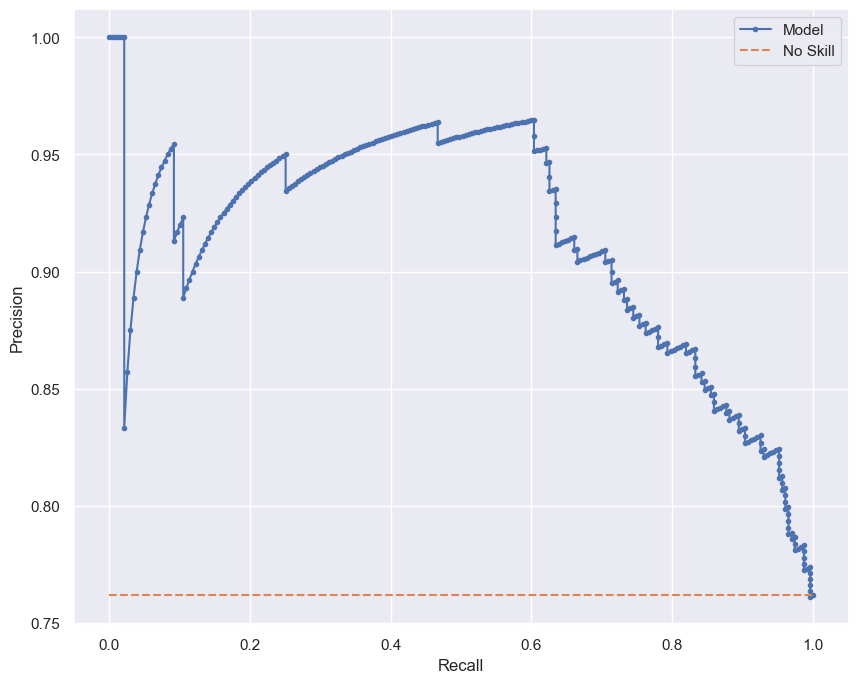




ROC AUC=0.800 



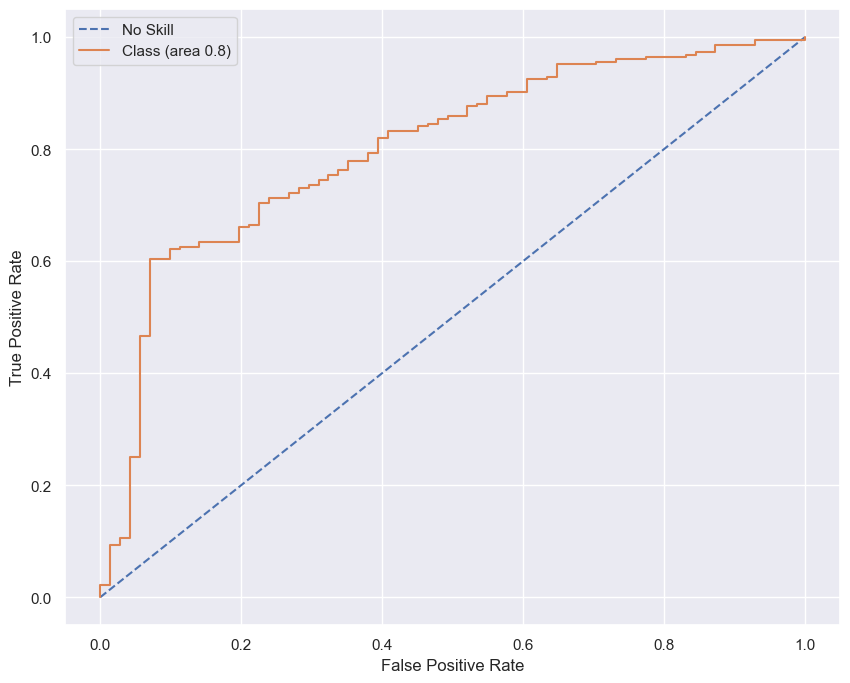



Cohen's kappa: 33.78%




In [20]:
if logistic_regression:
    print("\nLogistic Regression for One-Hot encoding\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Logistic Regression for One-Hot encoding

Execution time : 0.104 s
Score : 78.52 %

Classification Report

              precision    recall  f1-score   support

    negative       0.57      0.39      0.47        71
    positive       0.83      0.91      0.87       227

    accuracy                           0.79       298
   macro avg       0.70      0.65      0.67       298
weighted avg       0.77      0.79      0.77       298


Confusion Matrix





Model: f1-score=0.866 AUC=0.913




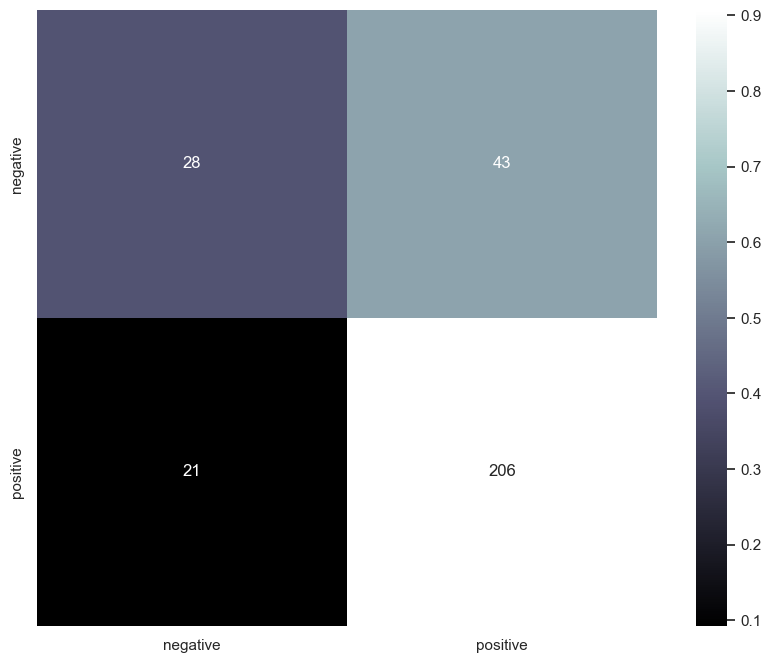

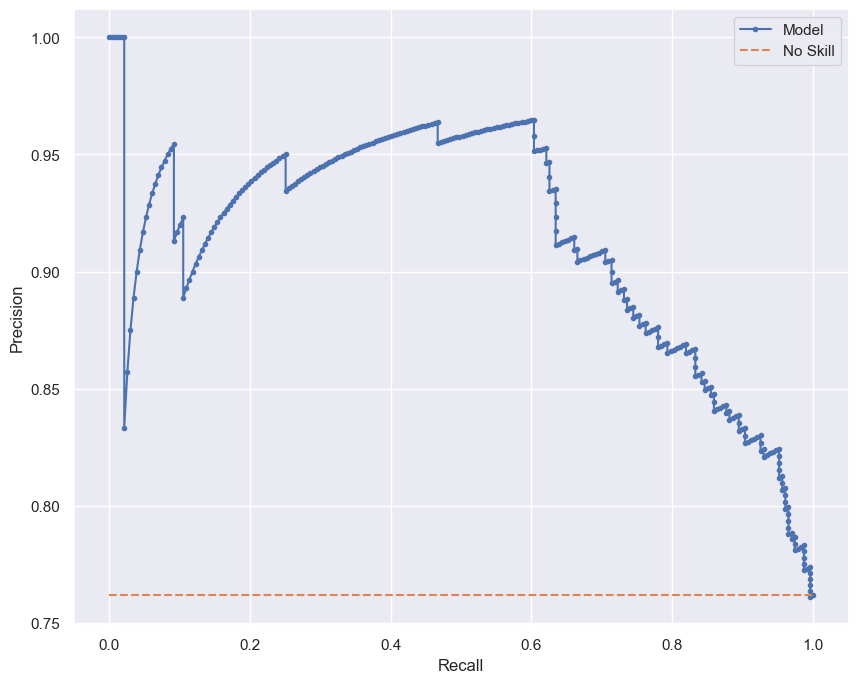




ROC AUC=0.800 



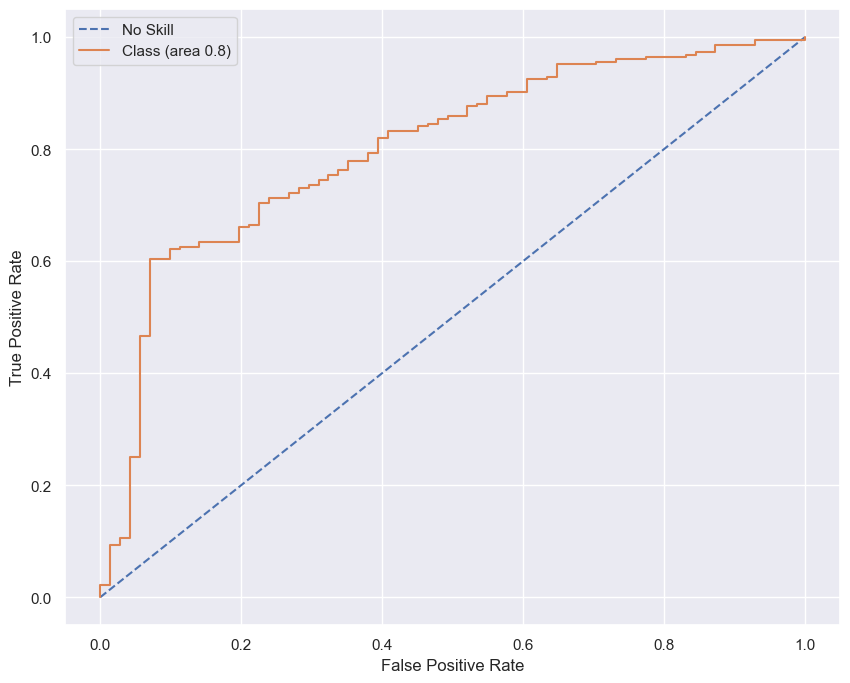



Cohen's kappa: 33.78%




In [21]:
if logistic_regression:
    print("\nLogistic Regression for One-Hot encoding\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Logistic Regression for TF_IDF n-grams

Execution time : 0.069 s
Score : 76.85 %

Classification Report

              precision    recall  f1-score   support

    negative       0.67      0.06      0.10        71
    positive       0.77      0.99      0.87       227

    accuracy                           0.77       298
   macro avg       0.72      0.52      0.49       298
weighted avg       0.75      0.77      0.69       298


Confusion Matrix





Model: f1-score=0.867 AUC=0.917




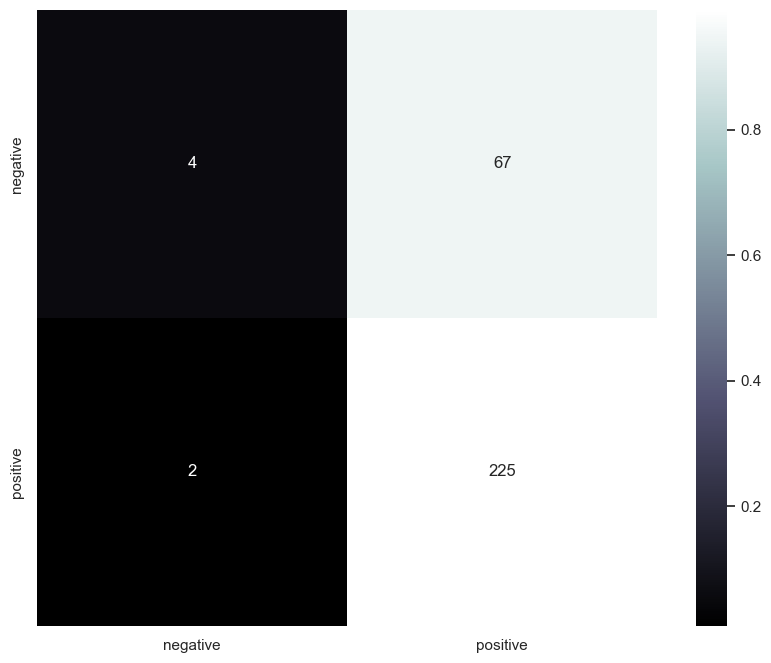

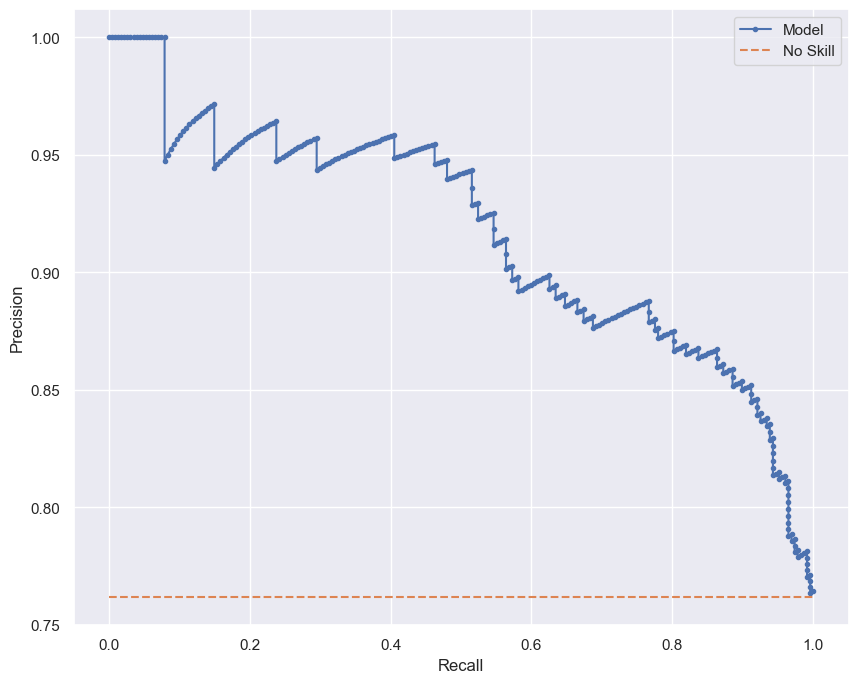




ROC AUC=0.791 



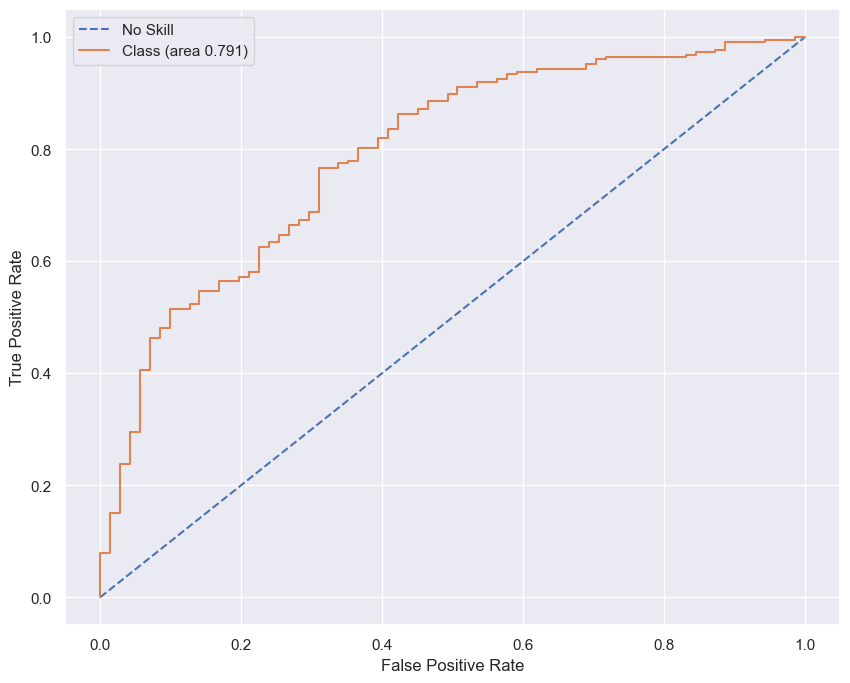



Cohen's kappa: 6.93%




In [46]:
if logistic_regression:
    print("\nLogistic Regression for TF_IDF n-grams\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Logistic Regression for TF_IDF char n-grams

Execution time : 0.232 s
Score : 80.54 %

Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.23      0.36        71
    positive       0.80      0.99      0.89       227

    accuracy                           0.81       298
   macro avg       0.82      0.61      0.62       298
weighted avg       0.81      0.81      0.76       298


Confusion Matrix





Model: f1-score=0.885 AUC=0.924




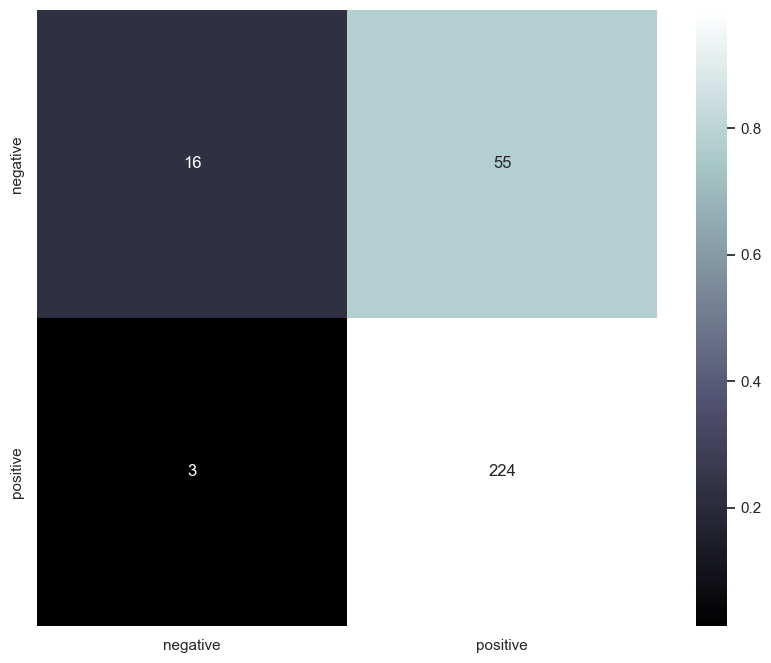

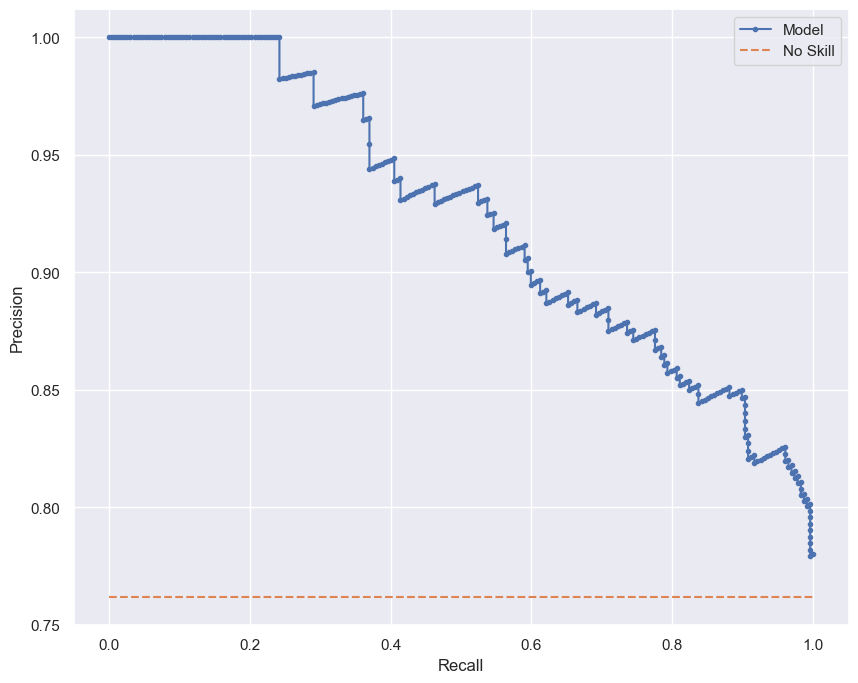




ROC AUC=0.792 



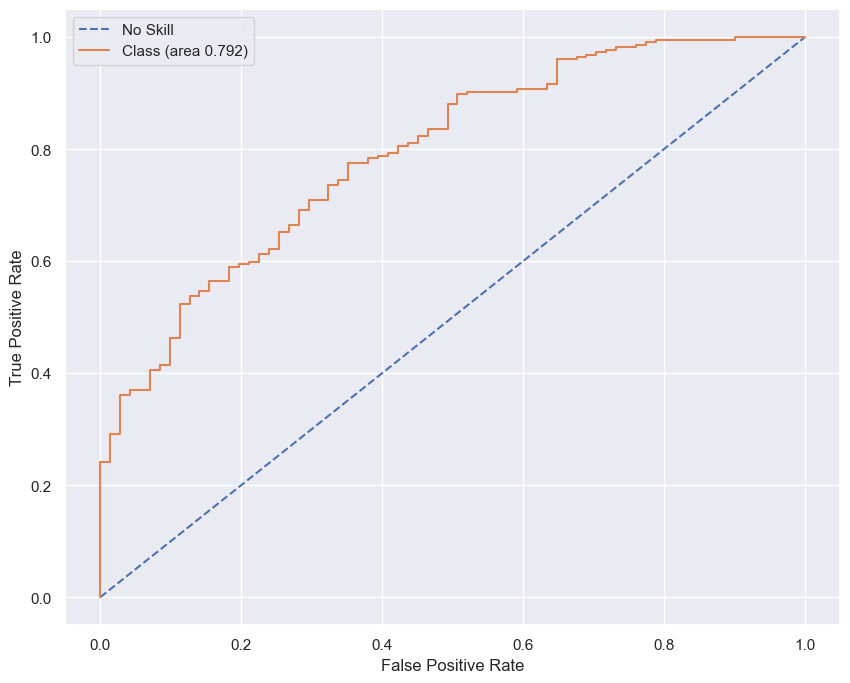



Cohen's kappa: 28.35%




In [47]:
if logistic_regression:
    print("\nLogistic Regression for TF_IDF char n-grams\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)


SVM for One-Hot encoding

Execution time : 0.702 s
Score : 80.2 %

Classification Report

              precision    recall  f1-score   support

    negative       0.80      0.23      0.35        71
    positive       0.80      0.98      0.88       227

    accuracy                           0.80       298
   macro avg       0.80      0.60      0.62       298
weighted avg       0.80      0.80      0.76       298


Confusion Matrix





Model: f1-score=0.883 AUC=0.899




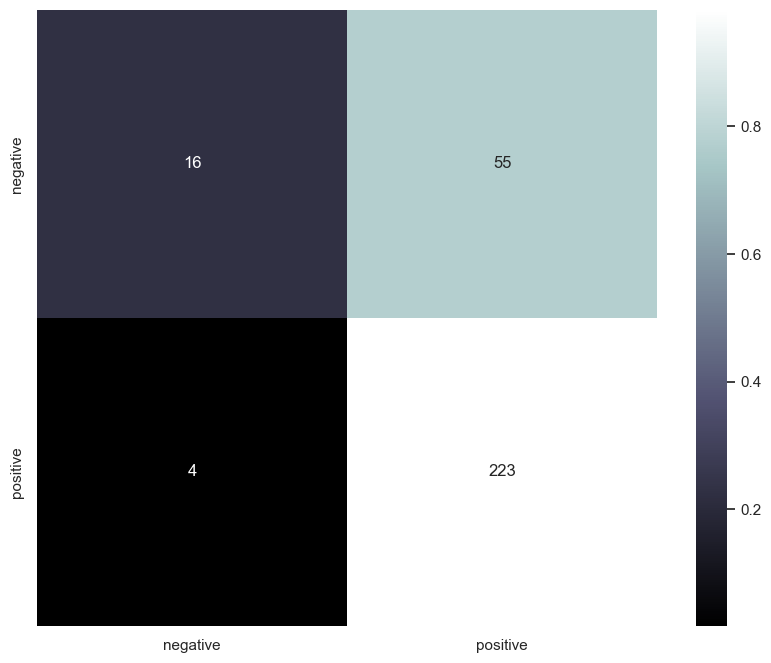

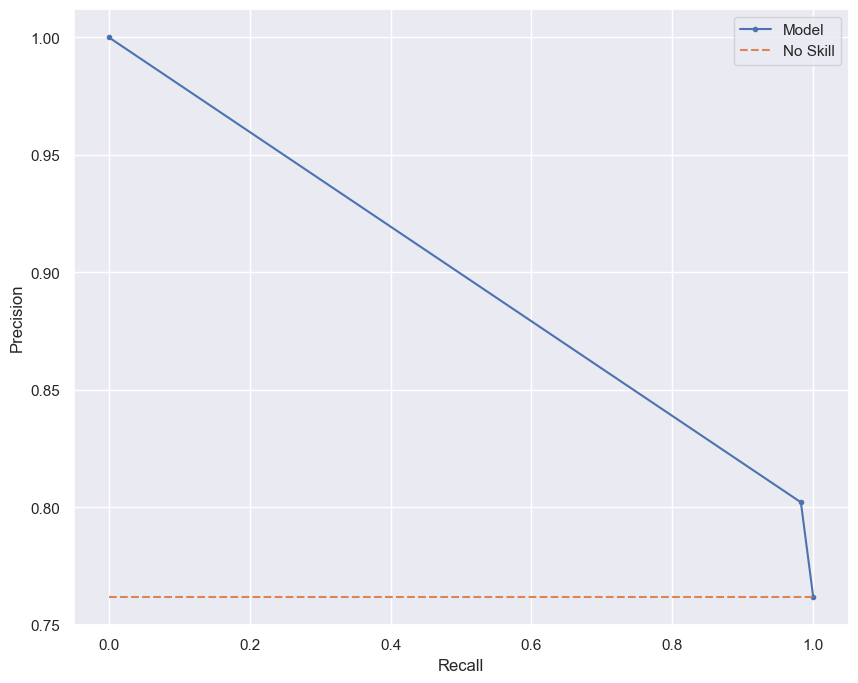




ROC AUC=0.604 



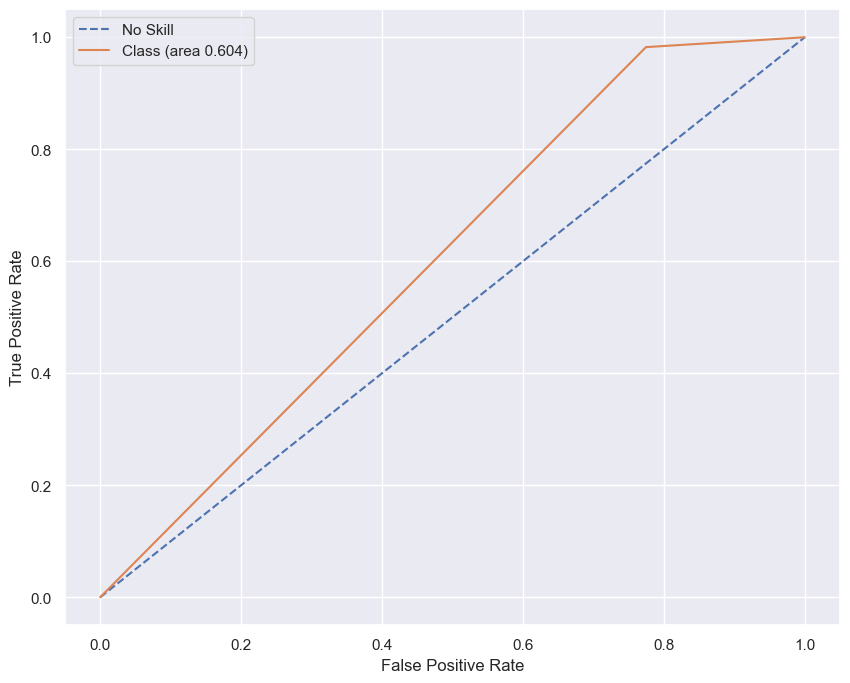



Cohen's kappa: 27.58%




In [48]:
if svm_model:
    print("\nSVM for One-Hot encoding\n")
    metrics_ML(svm.SVC(),  xtrain_count, train_y, xvalid_count, valid_y, gb=False)


SVM for TF_IDF

Execution time : 0.740 s
Score : 81.88 %

Classification Report

              precision    recall  f1-score   support

    negative       0.87      0.28      0.43        71
    positive       0.81      0.99      0.89       227

    accuracy                           0.82       298
   macro avg       0.84      0.63      0.66       298
weighted avg       0.83      0.82      0.78       298


Confusion Matrix





Model: f1-score=0.892 AUC=0.906




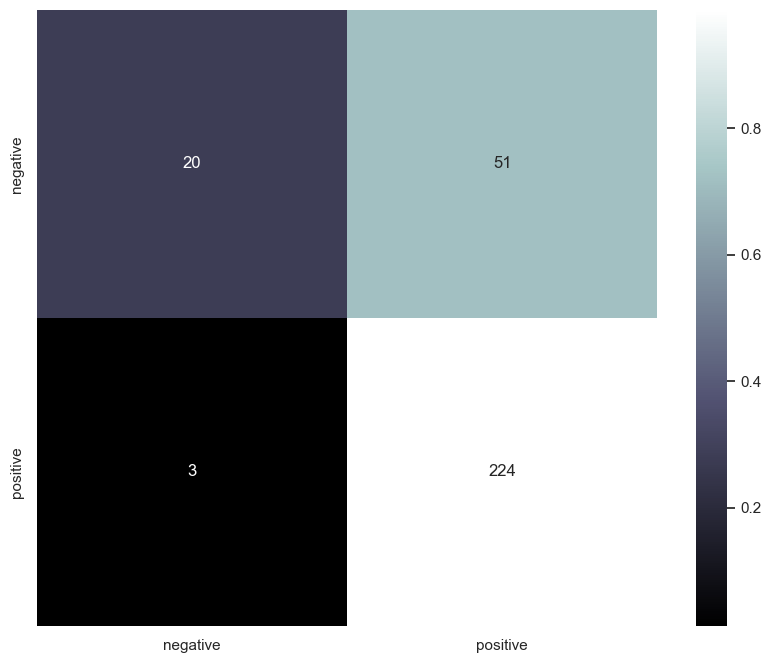

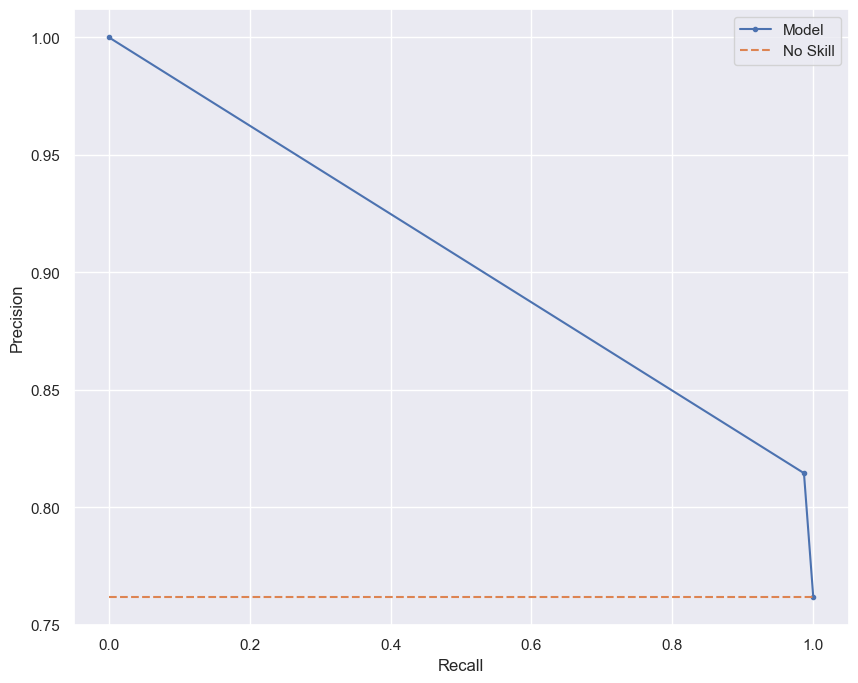




ROC AUC=0.634 



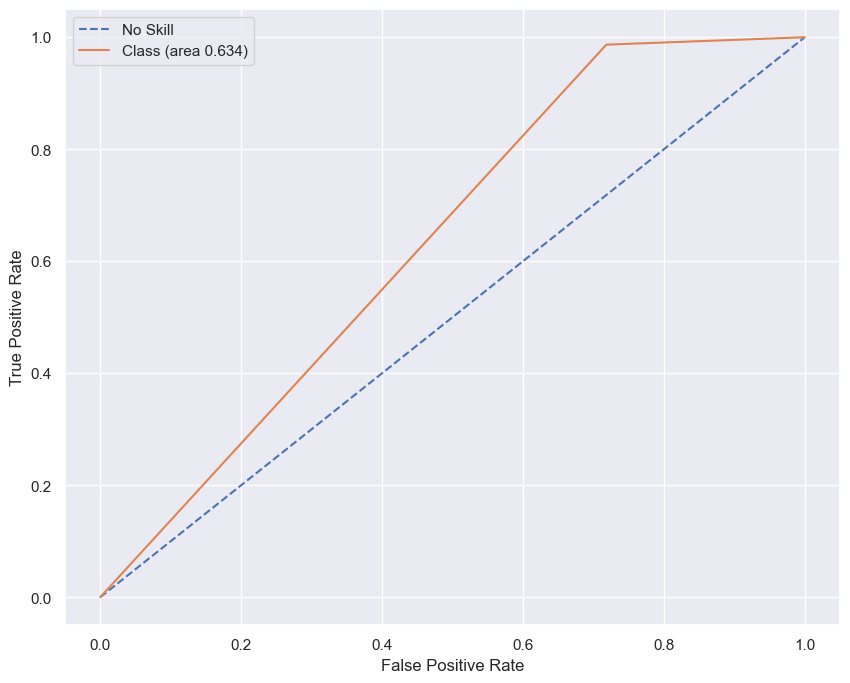



Cohen's kappa: 34.97%




In [49]:
if svm_model:
    print("\nSVM for TF_IDF\n")
    metrics_ML(svm.SVC(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=False)


SVM for TF_IDF n-grams

Execution time : 0.913 s
Score : 77.52 %

Classification Report

              precision    recall  f1-score   support

    negative       0.70      0.10      0.17        71
    positive       0.78      0.99      0.87       227

    accuracy                           0.78       298
   macro avg       0.74      0.54      0.52       298
weighted avg       0.76      0.78      0.70       298


Confusion Matrix





Model: f1-score=0.870 AUC=0.887




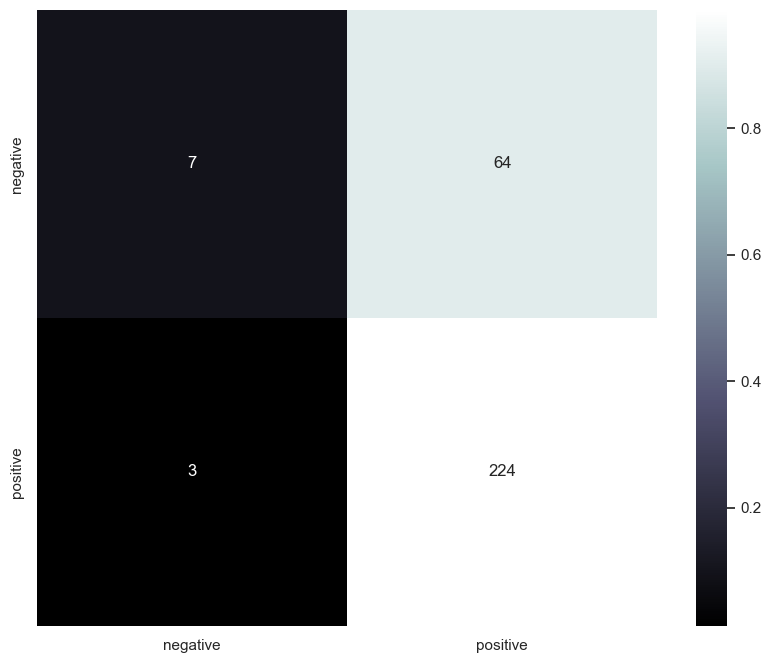

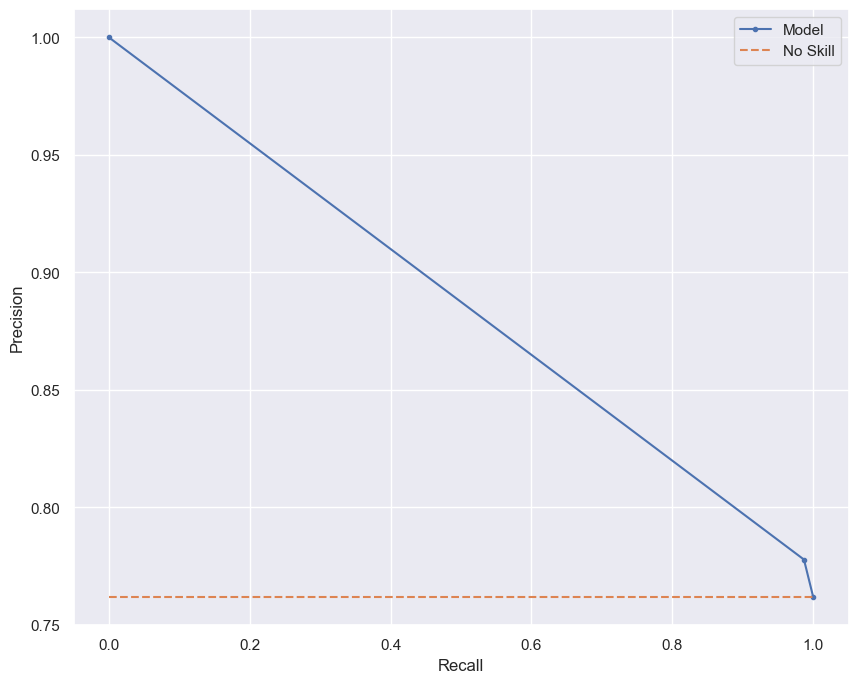




ROC AUC=0.543 



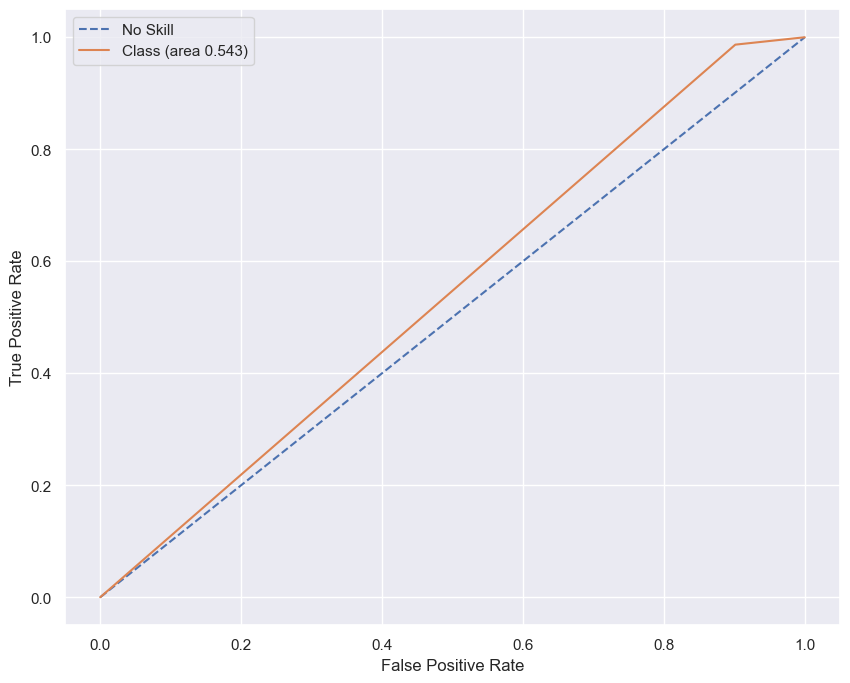



Cohen's kappa: 12.11%




In [50]:
if svm_model:
    print("\nSVM for TF_IDF n-grams\n")
    metrics_ML(svm.SVC(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=False)


SVM for TF_IDF char n-grams

Execution time : 5.669 s
Score : 81.88 %

Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.31      0.45        71
    positive       0.82      0.98      0.89       227

    accuracy                           0.82       298
   macro avg       0.82      0.64      0.67       298
weighted avg       0.82      0.82      0.79       298


Confusion Matrix





Model: f1-score=0.892 AUC=0.907




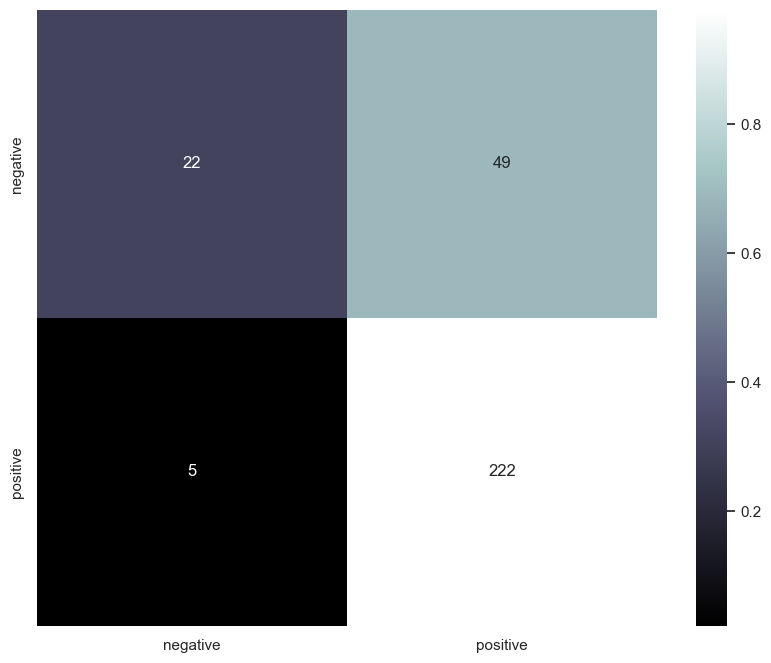

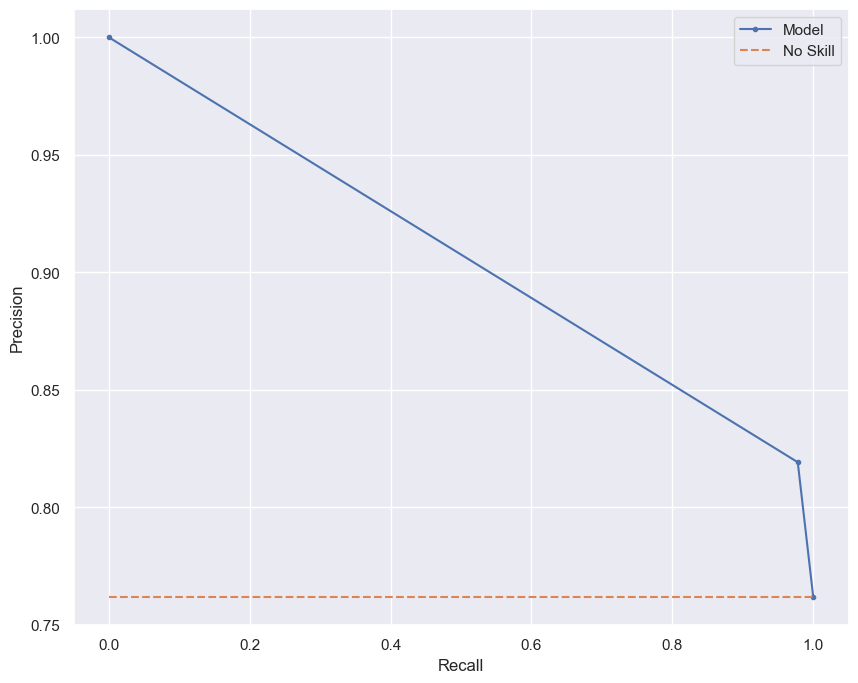




ROC AUC=0.644 



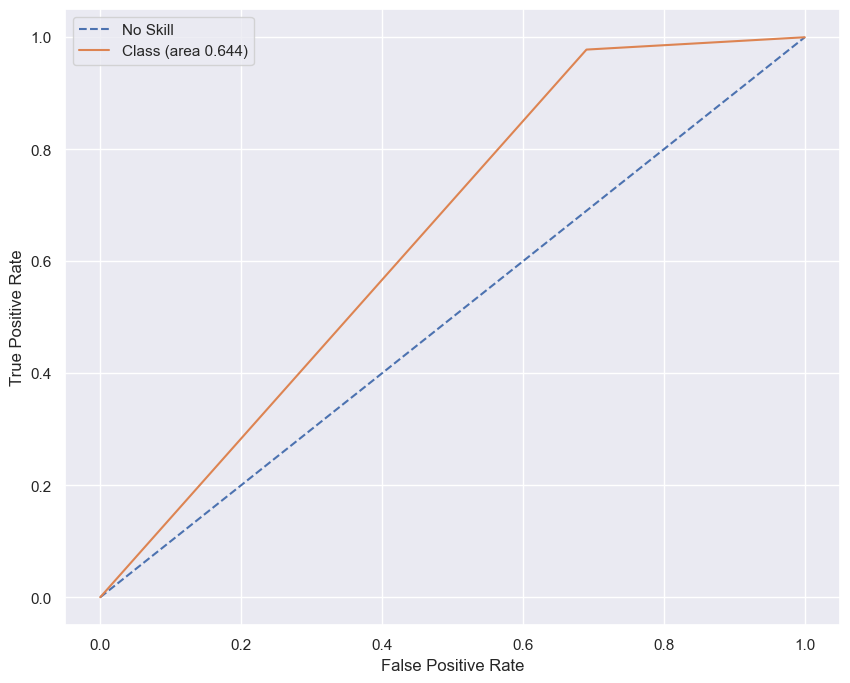



Cohen's kappa: 36.57%




In [51]:
if svm_model:
    print("\nSVM for TF_IDF char n-grams\n")
    metrics_ML(svm.SVC(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=False)


k-NN for One-Hot encoding

Execution time : 0.002 s
Score : 77.52 %

Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.07      0.13        71
    positive       0.77      1.00      0.87       227

    accuracy                           0.78       298
   macro avg       0.80      0.53      0.50       298
weighted avg       0.79      0.78      0.69       298


Confusion Matrix





Model: f1-score=0.871 AUC=0.865




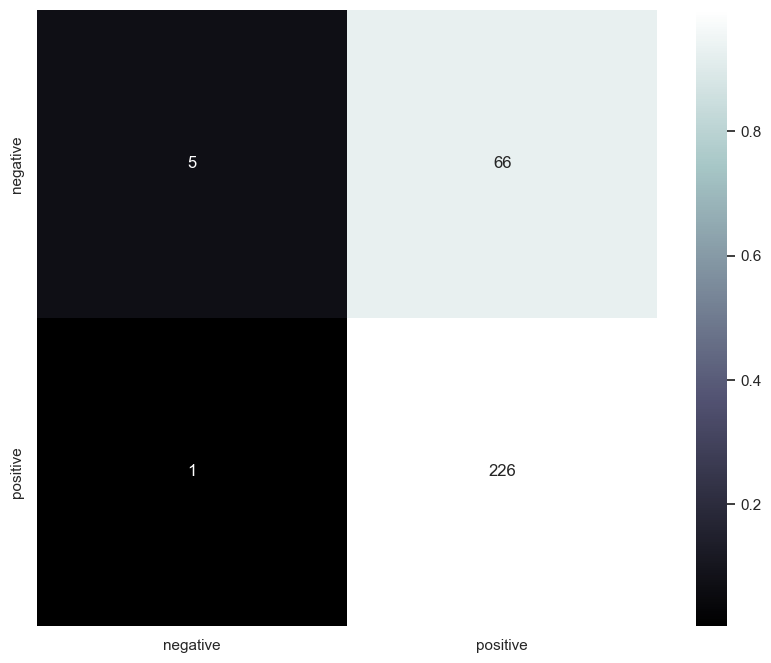

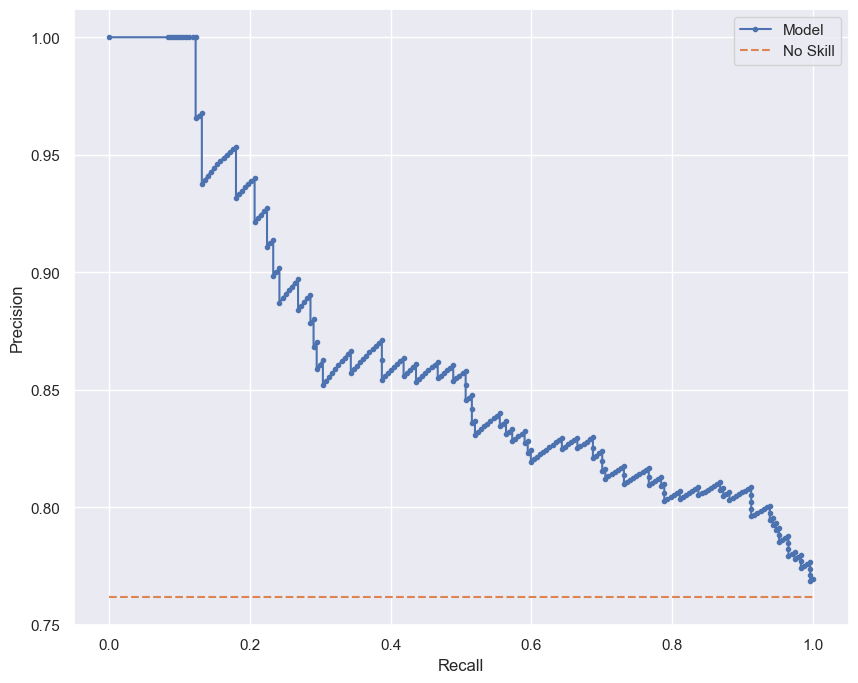




ROC AUC=0.666 



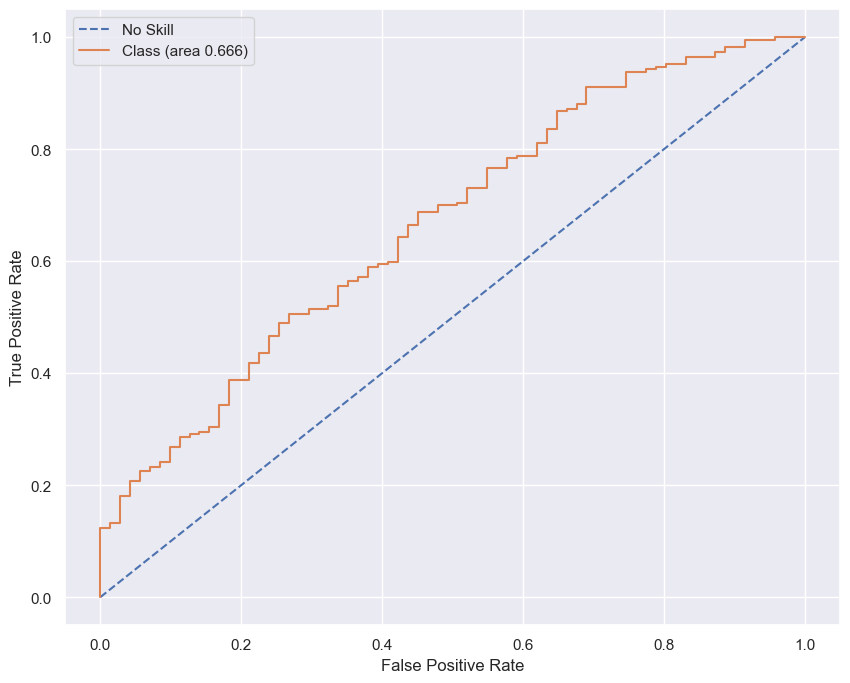



Cohen's kappa: 9.63%




In [52]:
if k_nn_model:
    print("\nk-NN for One-Hot encoding\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


k-NN for TF_IDF

Execution time : 0.002 s
Score : 82.89 %

Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.35      0.50        71
    positive       0.83      0.98      0.90       227

    accuracy                           0.83       298
   macro avg       0.83      0.67      0.70       298
weighted avg       0.83      0.83      0.80       298


Confusion Matrix





Model: f1-score=0.897 AUC=0.926




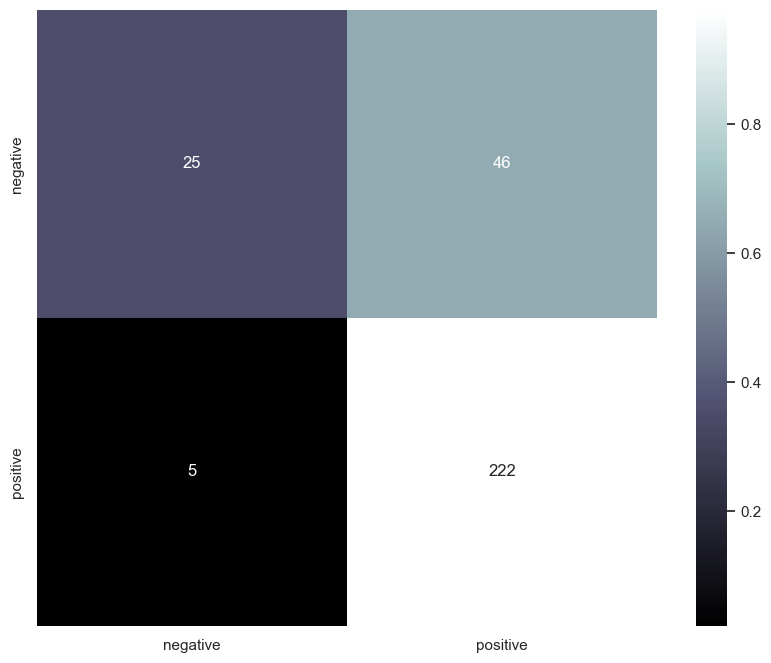

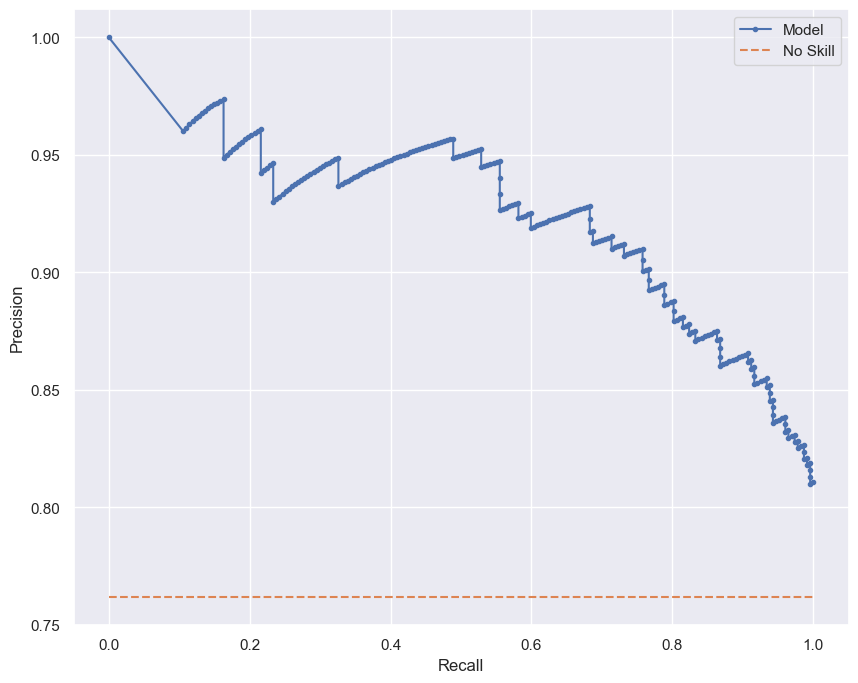




ROC AUC=0.825 



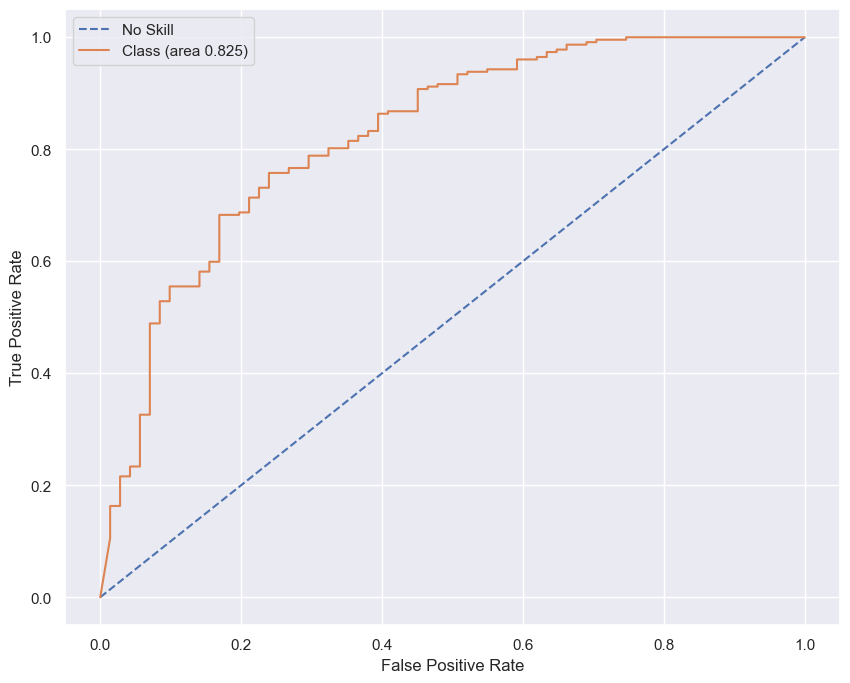



Cohen's kappa: 41.18%




In [53]:
if k_nn_model:
    print("\nk-NN for TF_IDF\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


k-NN for TF_IDF n-grams

Execution time : 0.001 s
Score : 78.19 %

Classification Report

              precision    recall  f1-score   support

    negative       0.88      0.10      0.18        71
    positive       0.78      1.00      0.87       227

    accuracy                           0.78       298
   macro avg       0.83      0.55      0.53       298
weighted avg       0.80      0.78      0.71       298


Confusion Matrix





Model: f1-score=0.874 AUC=0.903




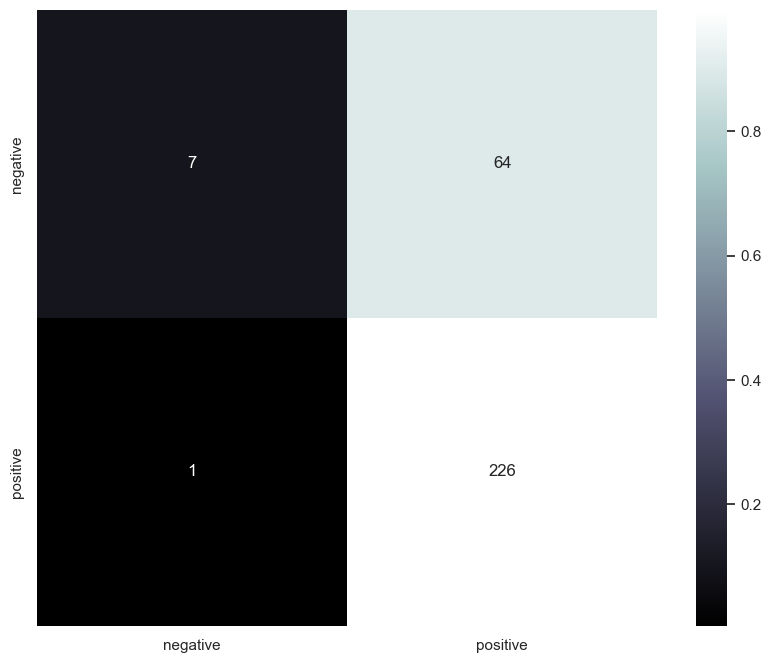

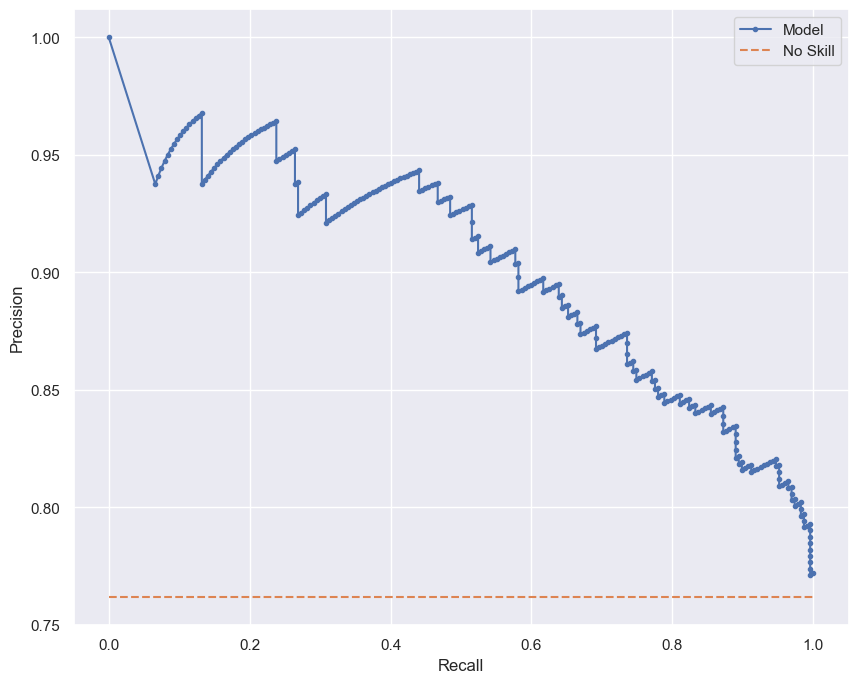




ROC AUC=0.765 



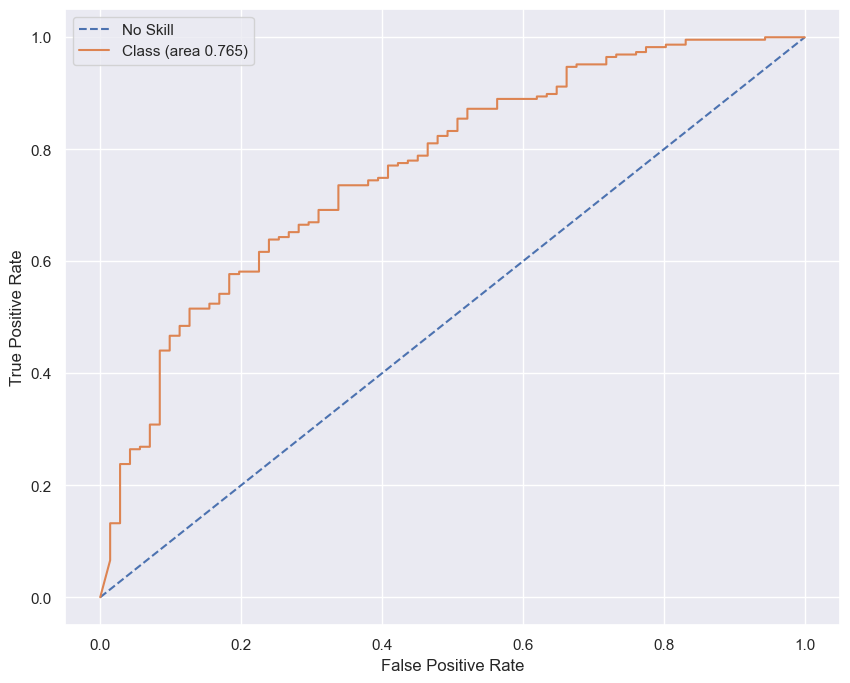



Cohen's kappa: 13.55%




In [54]:
if k_nn_model:
    print("\nk-NN for TF_IDF n-grams\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


k-NN for TF_IDF char n-grams

Execution time : 0.005 s
Score : 81.88 %

Classification Report

              precision    recall  f1-score   support

    negative       0.73      0.38      0.50        71
    positive       0.83      0.96      0.89       227

    accuracy                           0.82       298
   macro avg       0.78      0.67      0.69       298
weighted avg       0.81      0.82      0.80       298


Confusion Matrix





Model: f1-score=0.889 AUC=0.921




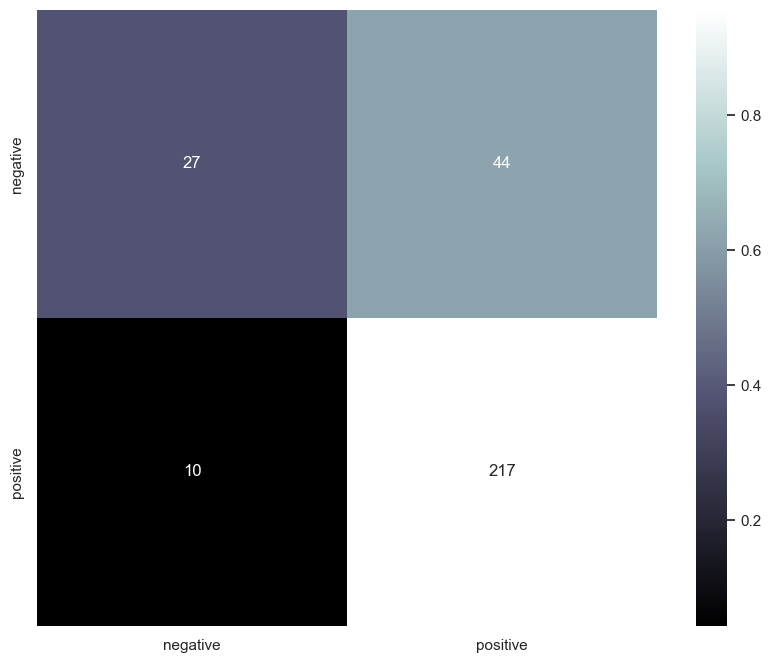

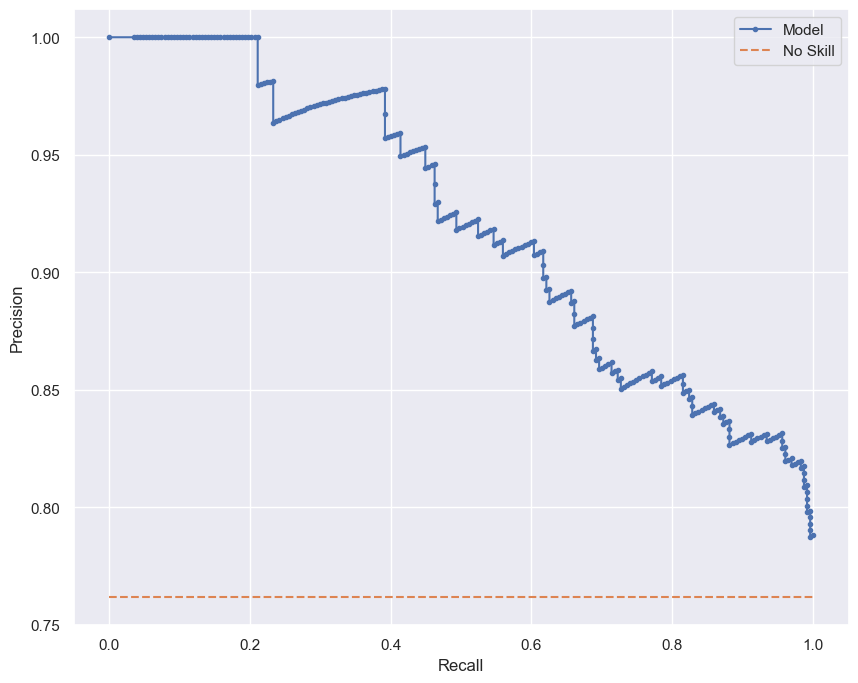




ROC AUC=0.785 



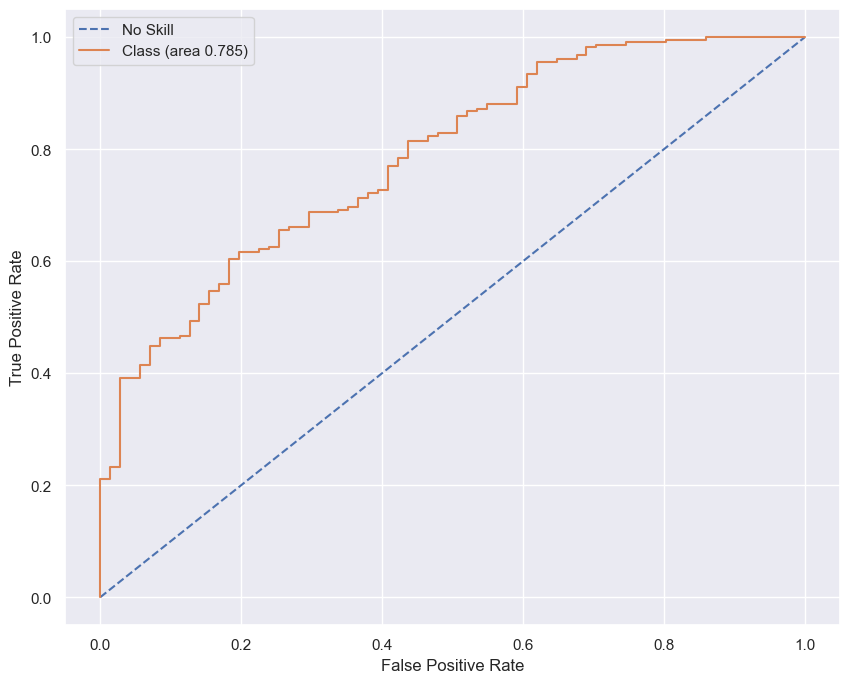



Cohen's kappa: 40.25%




In [56]:
if k_nn_model:
    print("\nk-NN for TF_IDF char n-grams\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)


Random Forest for One-Hot encoding

Execution time : 2.970 s
Score : 80.2 %

Classification Report

              precision    recall  f1-score   support

    negative       0.80      0.23      0.35        71
    positive       0.80      0.98      0.88       227

    accuracy                           0.80       298
   macro avg       0.80      0.60      0.62       298
weighted avg       0.80      0.80      0.76       298


Confusion Matrix





Model: f1-score=0.883 AUC=0.926




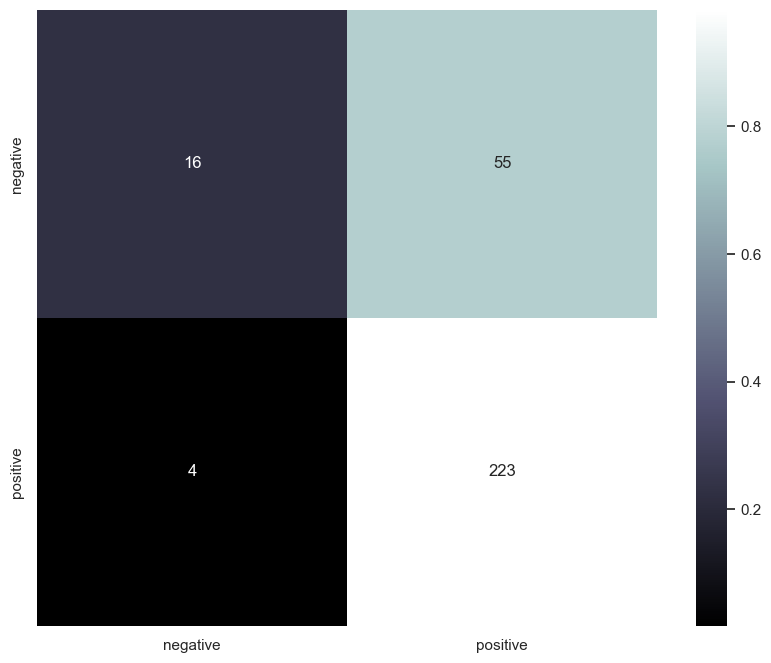

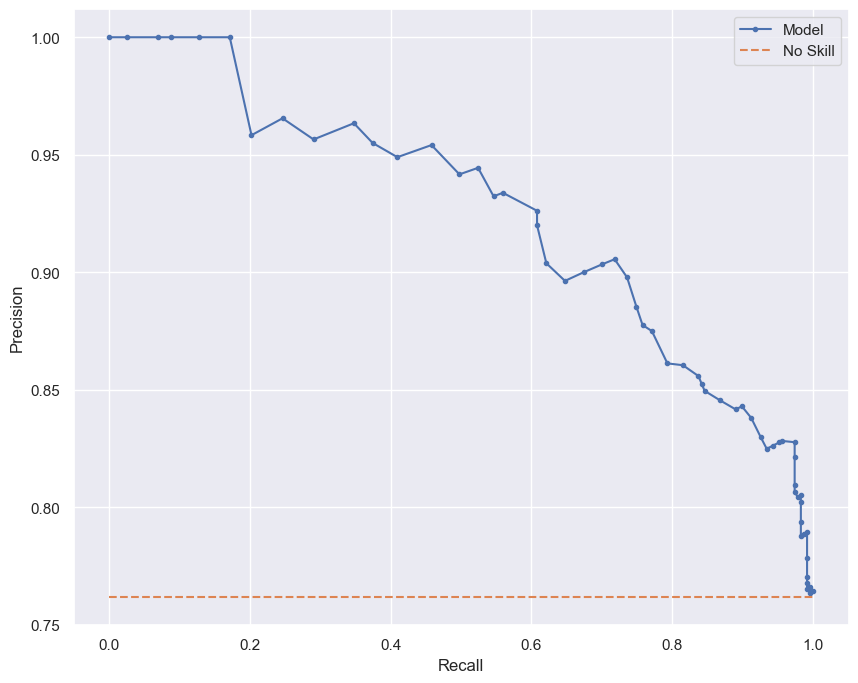




ROC AUC=0.803 



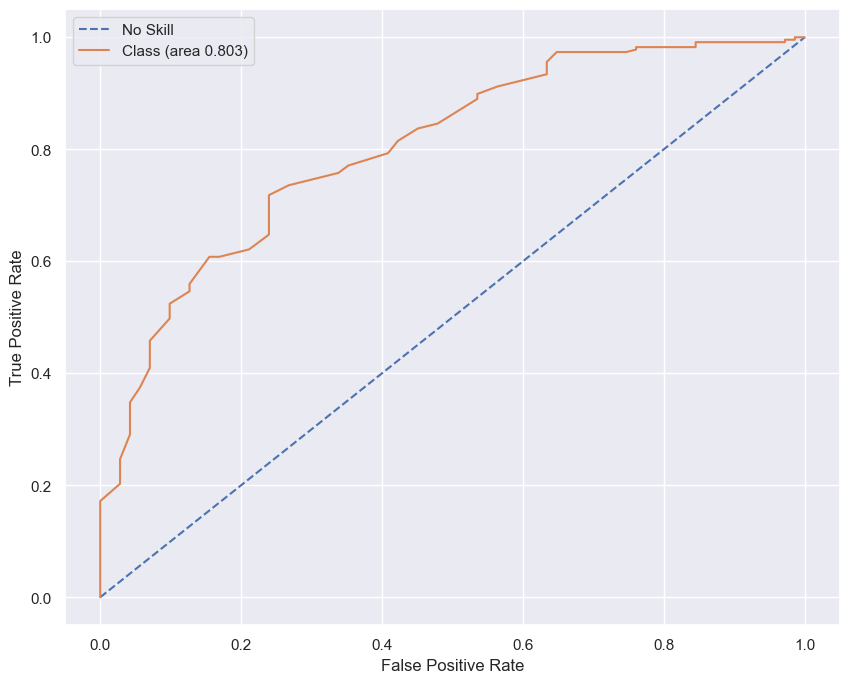



Cohen's kappa: 27.58%




In [57]:
if random_forest:
    print("\nRandom Forest for One-Hot encoding\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Random Forest for TF_IDF

Execution time : 2.312 s
Score : 79.87 %

Classification Report

              precision    recall  f1-score   support

    negative       0.76      0.23      0.35        71
    positive       0.80      0.98      0.88       227

    accuracy                           0.80       298
   macro avg       0.78      0.60      0.61       298
weighted avg       0.79      0.80      0.75       298


Confusion Matrix





Model: f1-score=0.881 AUC=0.903




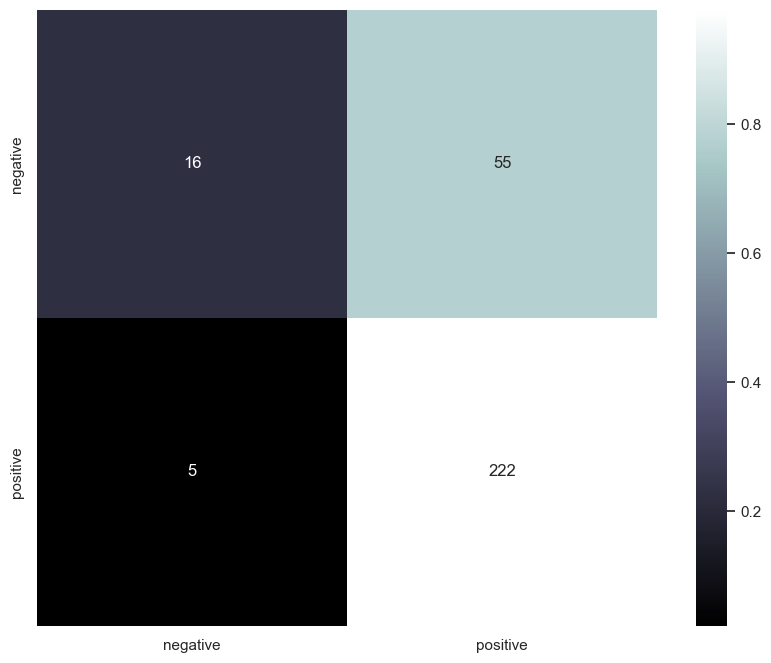

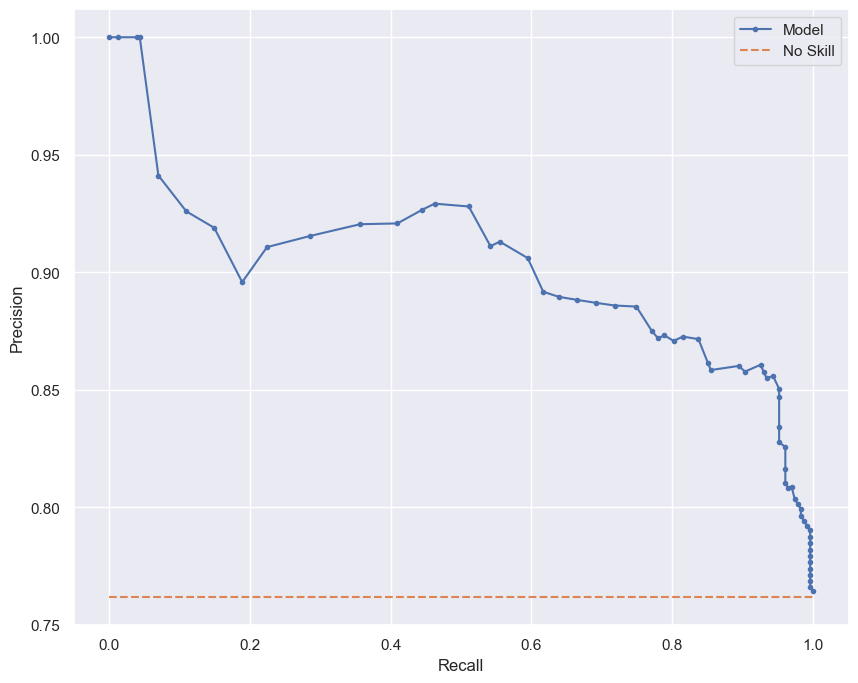




ROC AUC=0.786 



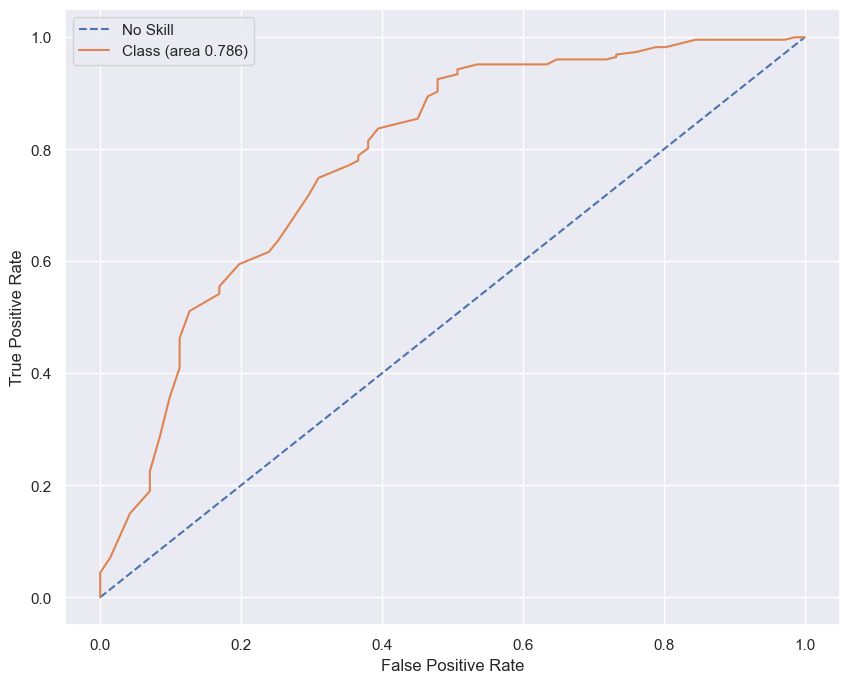



Cohen's kappa: 26.82%




In [58]:
if random_forest:
    print("\nRandom Forest for TF_IDF\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Random Forest for TF_IDF n-grams

Execution time : 2.106 s
Score : 79.19 %

Classification Report

              precision    recall  f1-score   support

    negative       0.74      0.20      0.31        71
    positive       0.80      0.98      0.88       227

    accuracy                           0.79       298
   macro avg       0.77      0.59      0.59       298
weighted avg       0.78      0.79      0.74       298


Confusion Matrix





Model: f1-score=0.877 AUC=0.902




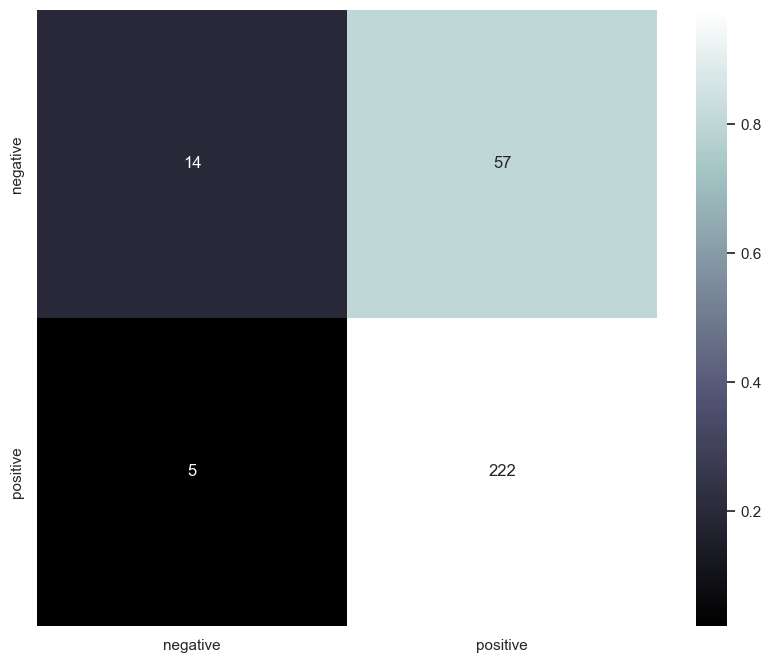

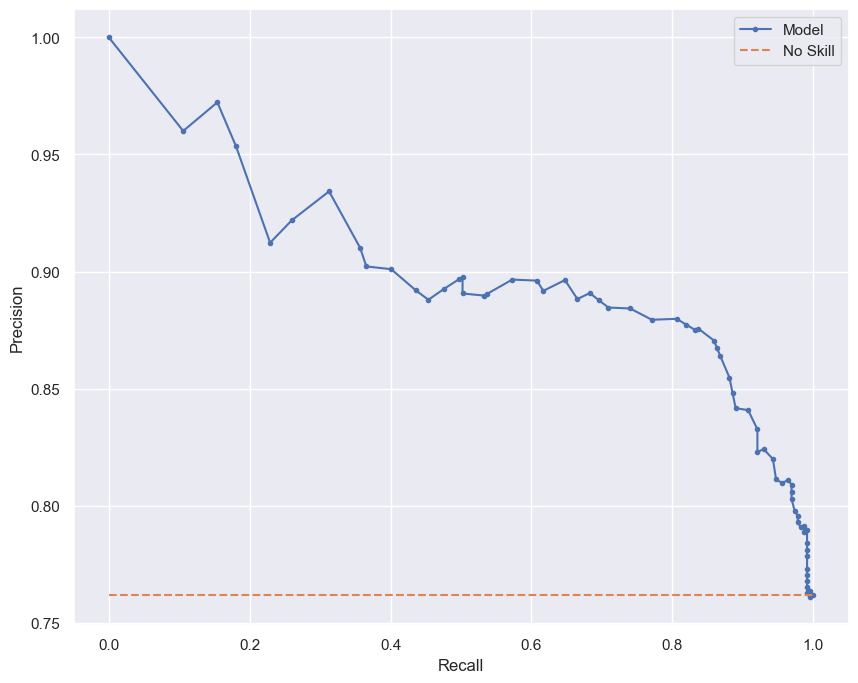




ROC AUC=0.772 



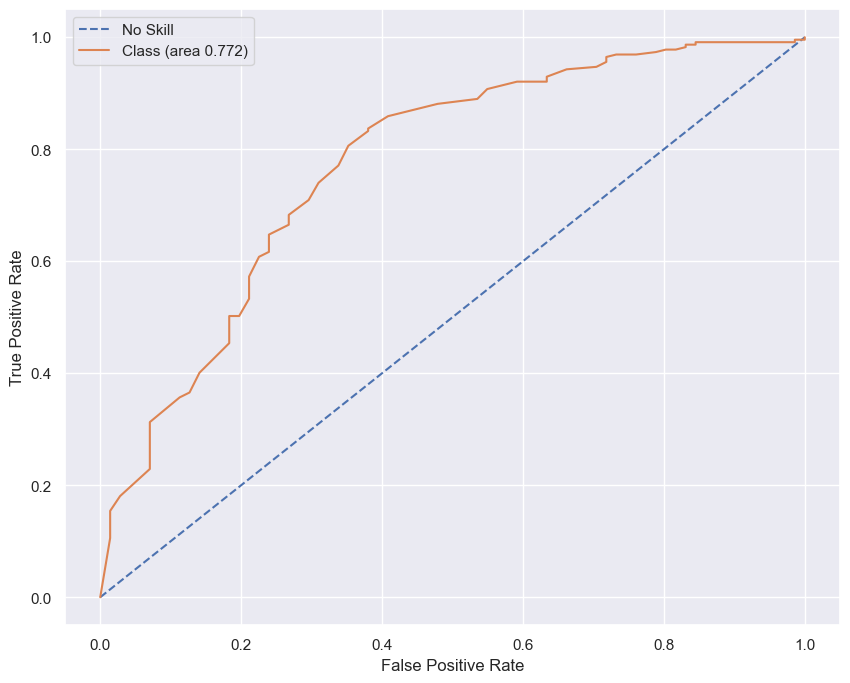



Cohen's kappa: 23.41%




In [59]:
if random_forest:
    print("\nRandom Forest for TF_IDF n-grams\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Random Forest for TF_IDF char n-grams

Execution time : 2.960 s
Score : 81.21 %

Classification Report

              precision    recall  f1-score   support

    negative       0.86      0.25      0.39        71
    positive       0.81      0.99      0.89       227

    accuracy                           0.81       298
   macro avg       0.83      0.62      0.64       298
weighted avg       0.82      0.81      0.77       298


Confusion Matrix





Model: f1-score=0.889 AUC=0.901




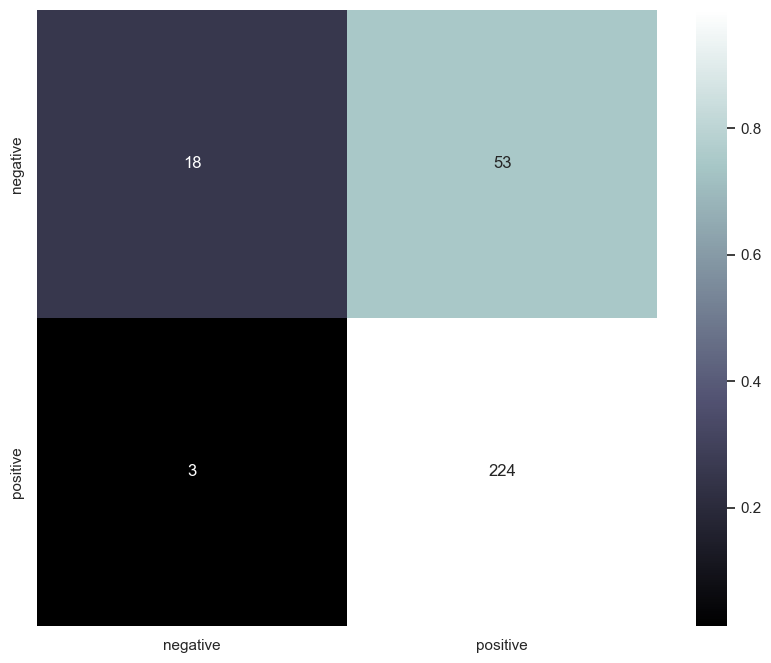

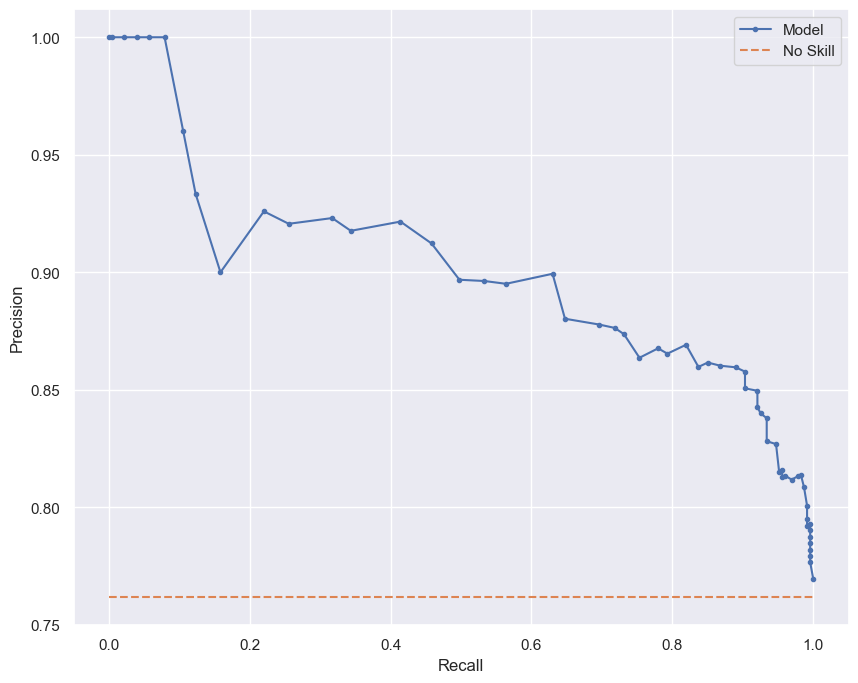




ROC AUC=0.773 



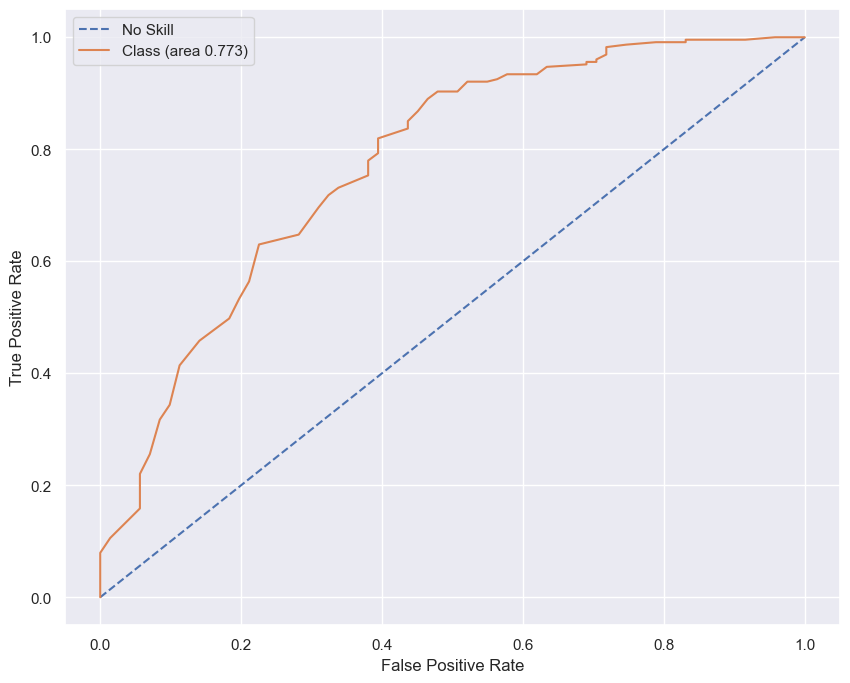



Cohen's kappa: 31.7%




In [60]:
if random_forest:
    print("\nRandom Forest for TF_IDF char n-grams\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)


Stochastic Gradient Descent with early stopping for One-Hot encoding

Early Stopping : 10 iterations without change
Execution time : 0.037 s
Score : 78.52 %

Classification Report

              precision    recall  f1-score   support

    negative       0.54      0.63      0.58        71
    positive       0.88      0.83      0.86       227

    accuracy                           0.79       298
   macro avg       0.71      0.73      0.72       298
weighted avg       0.80      0.79      0.79       298


Confusion Matrix





Model: f1-score=0.855 AUC=0.919




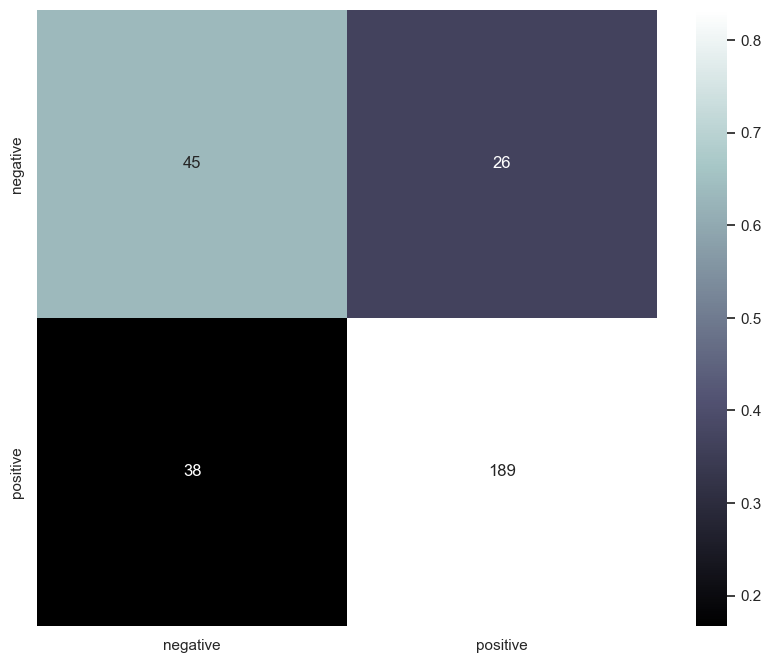

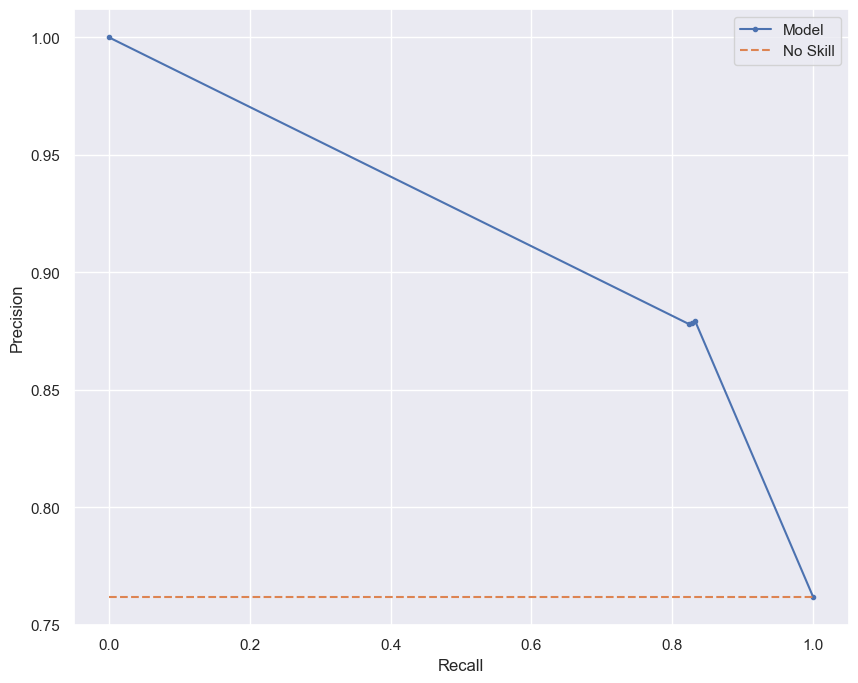




ROC AUC=0.732 



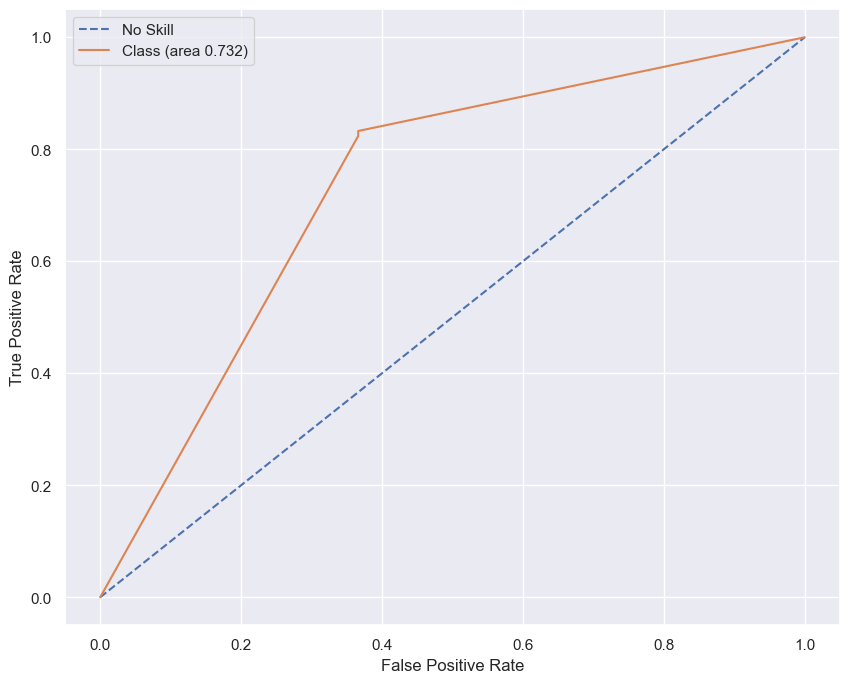



Cohen's kappa: 44.08%




In [61]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for One-Hot encoding\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Stochastic Gradient Descent with early stopping for TF-IDF

Early Stopping : 10 iterations without change
Execution time : 0.027 s
Score : 77.85 %

Classification Report

              precision    recall  f1-score   support

    negative       0.55      0.38      0.45        71
    positive       0.82      0.90      0.86       227

    accuracy                           0.78       298
   macro avg       0.69      0.64      0.66       298
weighted avg       0.76      0.78      0.76       298


Confusion Matrix





Model: f1-score=0.861 AUC=0.913




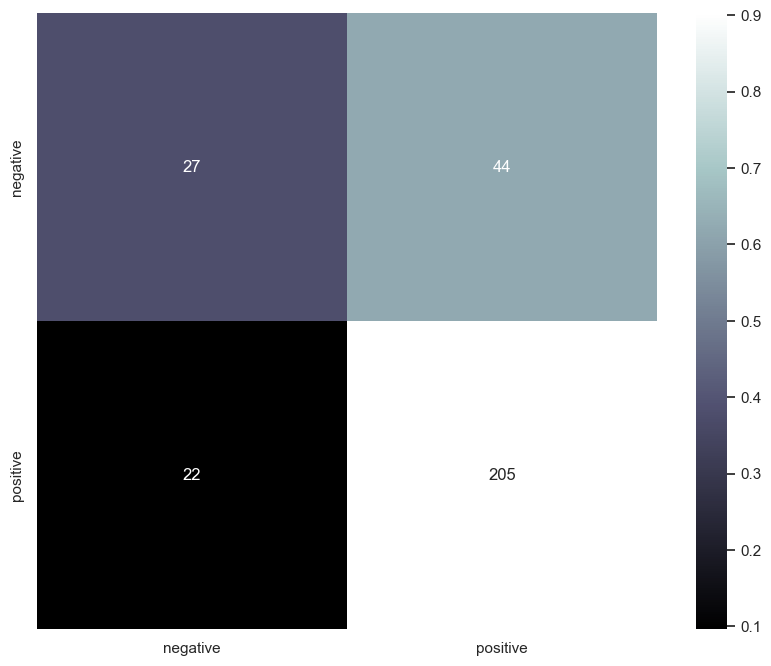

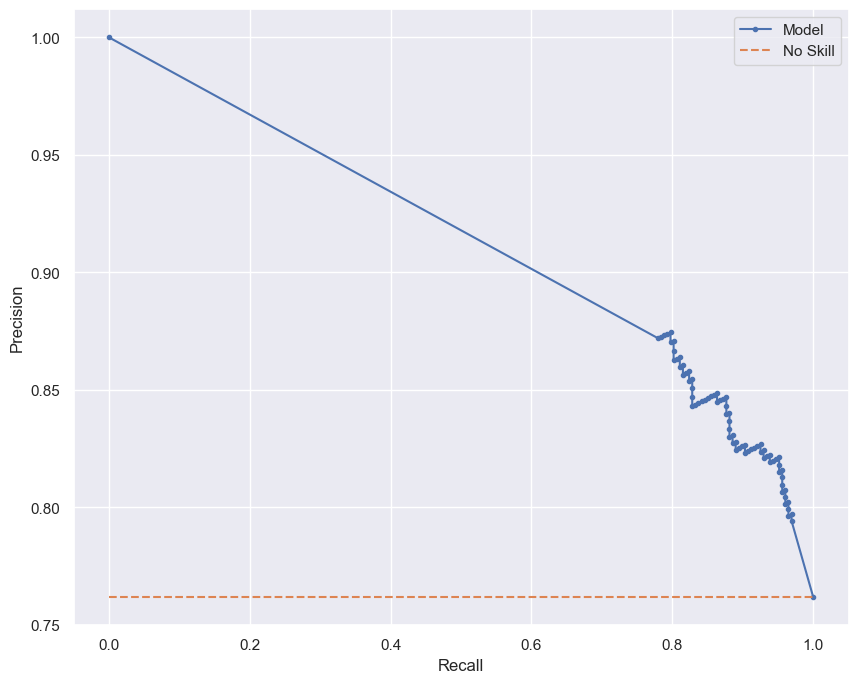




ROC AUC=0.726 



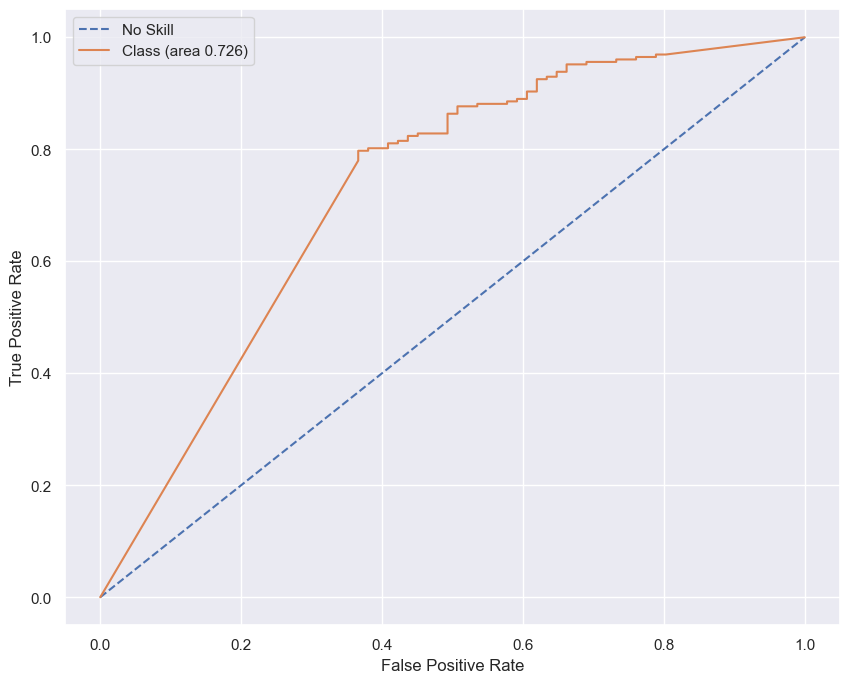



Cohen's kappa: 31.71%




In [62]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for TF-IDF\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Stochastic Gradient Descent with early stopping for TF-IDF char n-gram

Early Stopping : 10 iterations without change
Execution time : 0.124 s
Score : 78.52 %

Classification Report

              precision    recall  f1-score   support

    negative       0.57      0.42      0.48        71
    positive       0.83      0.90      0.86       227

    accuracy                           0.79       298
   macro avg       0.70      0.66      0.67       298
weighted avg       0.77      0.79      0.77       298


Confusion Matrix





Model: f1-score=0.864 AUC=0.909




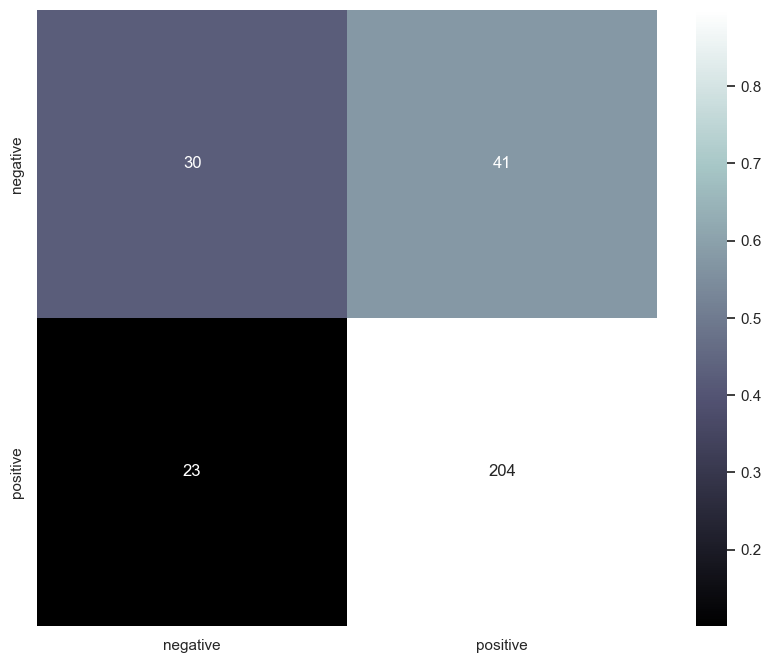

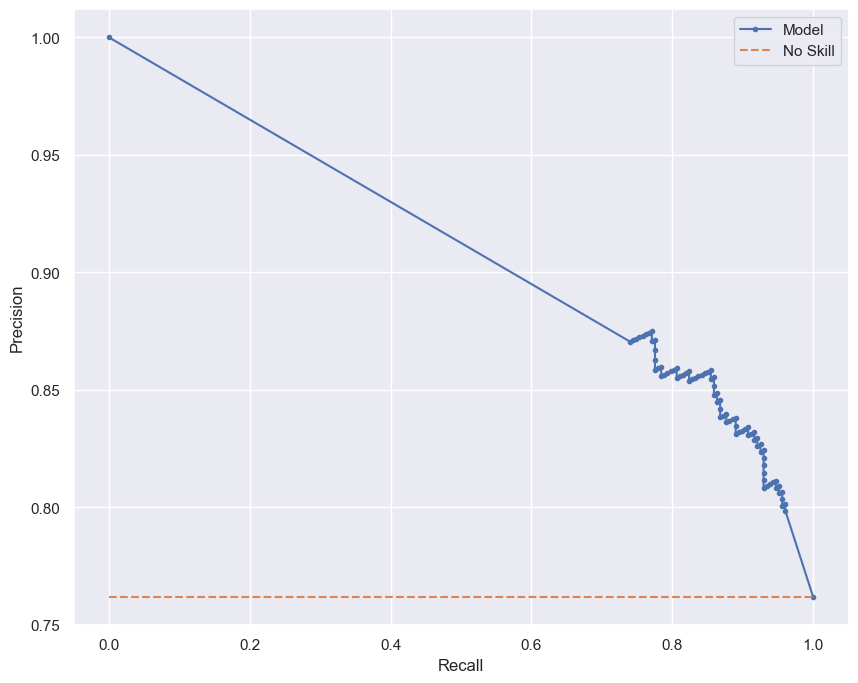




ROC AUC=0.723 



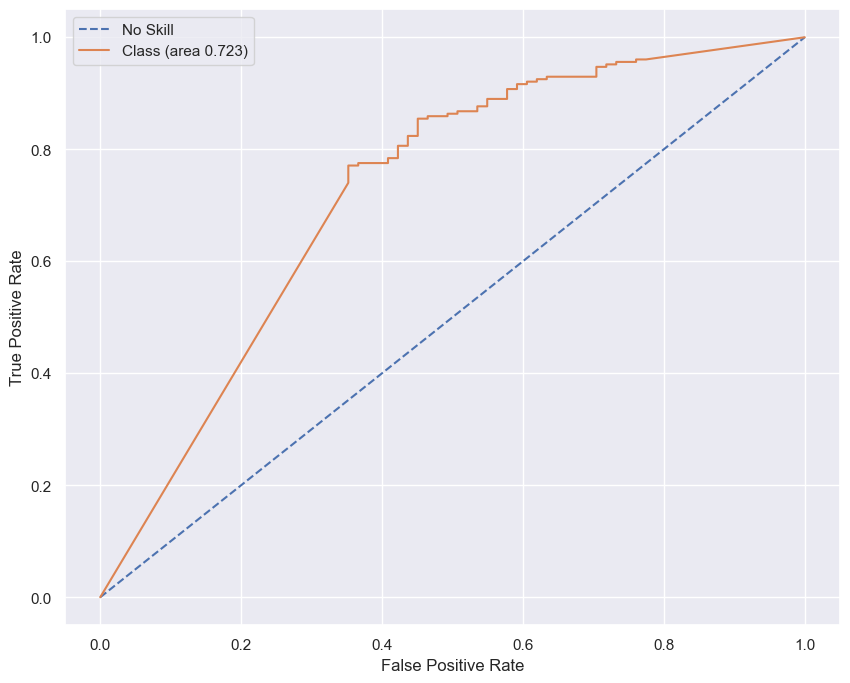



Cohen's kappa: 35.19%




In [64]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for TF-IDF char n-gram\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)


Stochastic Gradient Descent with early stopping for pad sentences

Early Stopping : 10 iterations without change
Execution time : 0.256 s
Score : 68.79 %

Classification Report

              precision    recall  f1-score   support

    negative       0.25      0.15      0.19        71
    positive       0.76      0.85      0.81       227

    accuracy                           0.69       298
   macro avg       0.51      0.50      0.50       298
weighted avg       0.64      0.69      0.66       298


Confusion Matrix





Model: f1-score=0.807 AUC=0.865




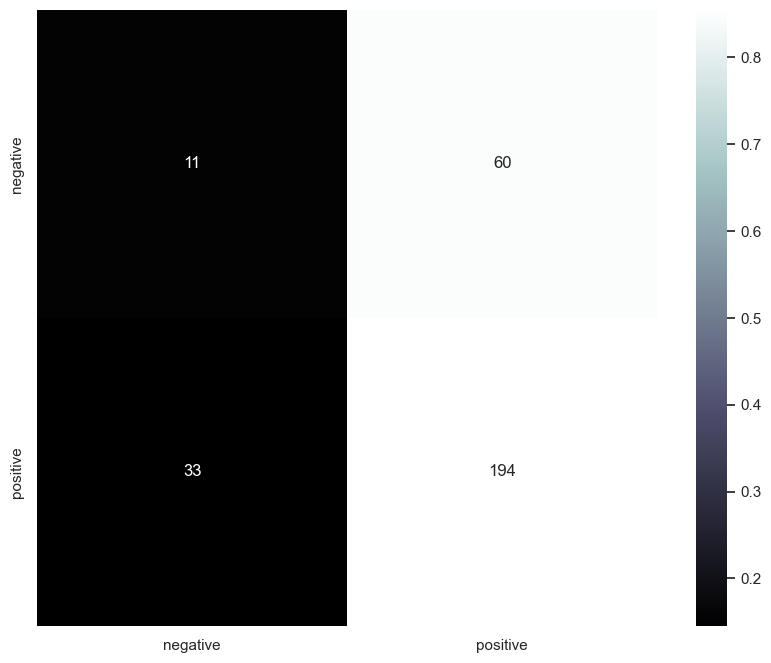

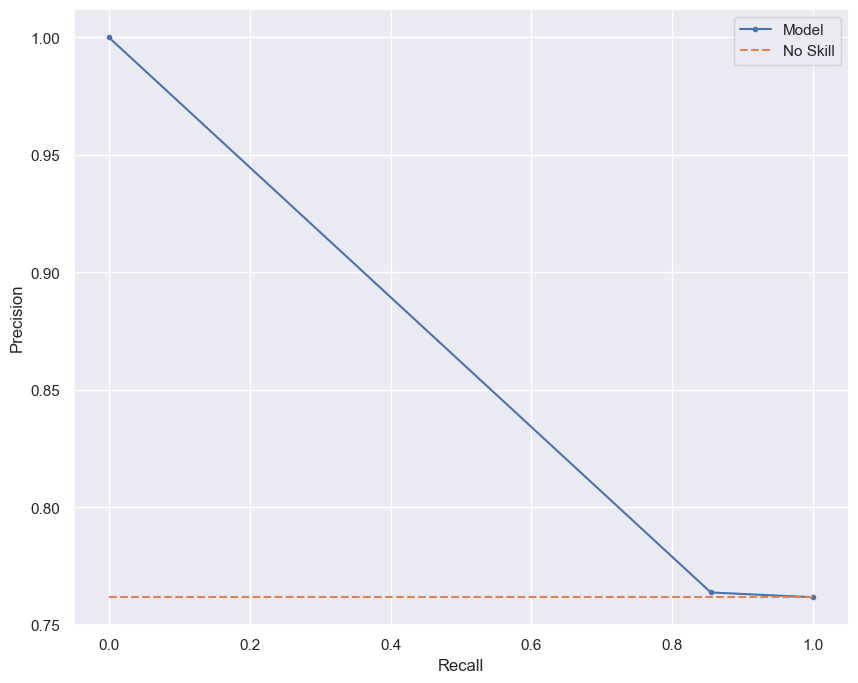




ROC AUC=0.505 



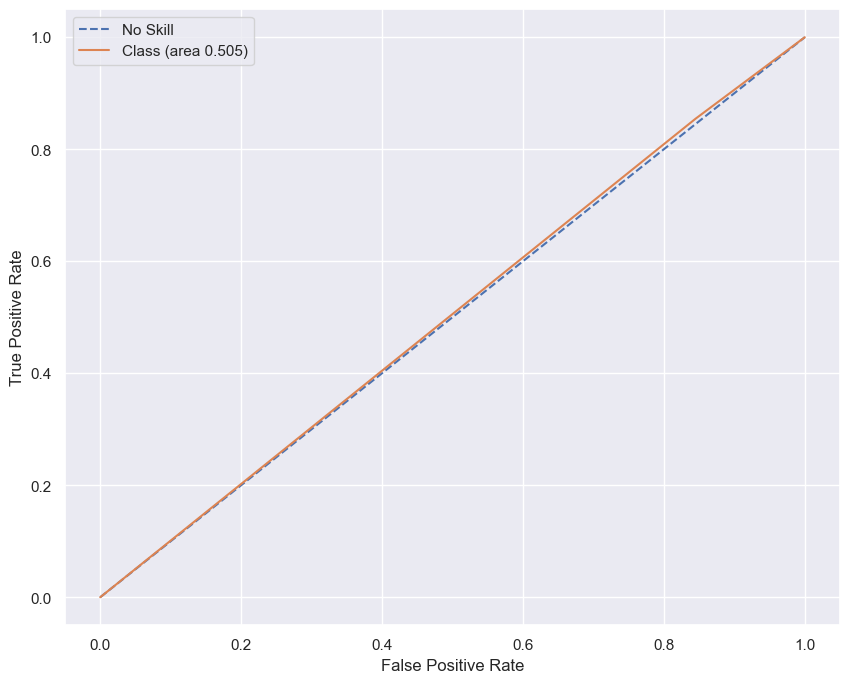



Cohen's kappa: 1.1%




In [65]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for pad sentences\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),train_seq_x, train_y, valid_seq_x, valid_y, gb=True)


Gradient Boosting with early stopping for Count Vectors

Early Stopping : 5 iterations without change
Execution time : 0.397 s
Score : 80.2 %

Classification Report

              precision    recall  f1-score   support

    negative       0.88      0.20      0.32        71
    positive       0.80      0.99      0.88       227

    accuracy                           0.80       298
   macro avg       0.84      0.59      0.60       298
weighted avg       0.82      0.80      0.75       298


Confusion Matrix





Model: f1-score=0.884 AUC=0.892




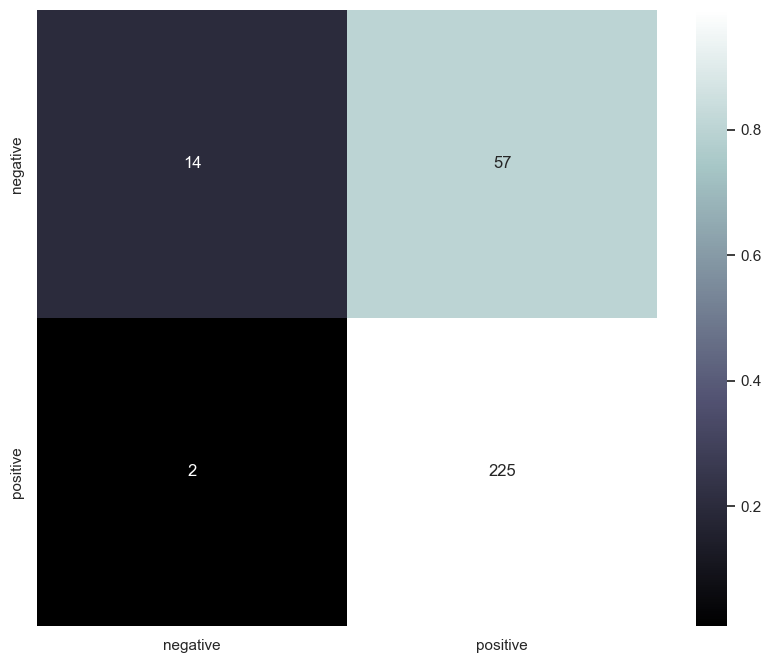

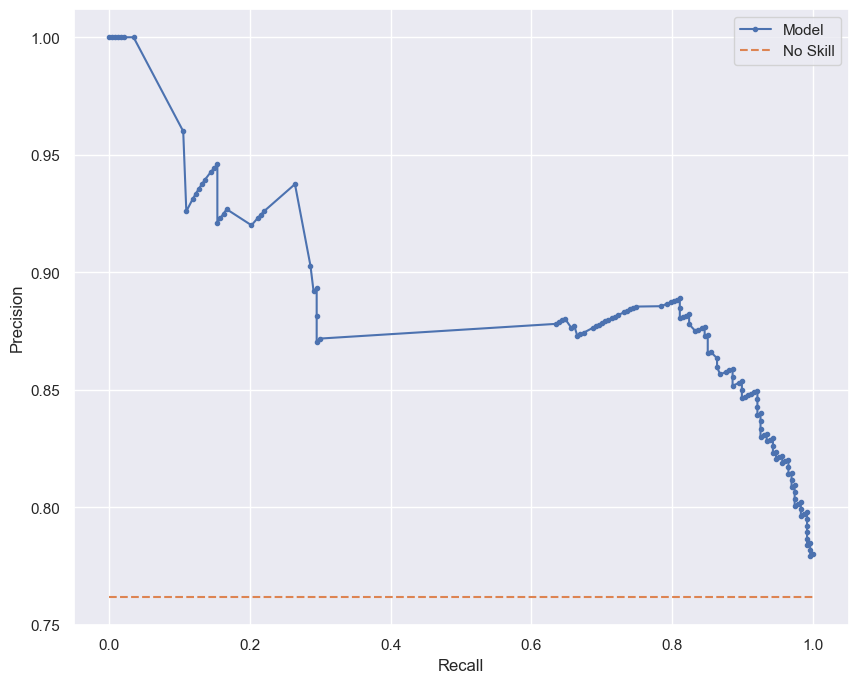




ROC AUC=0.759 



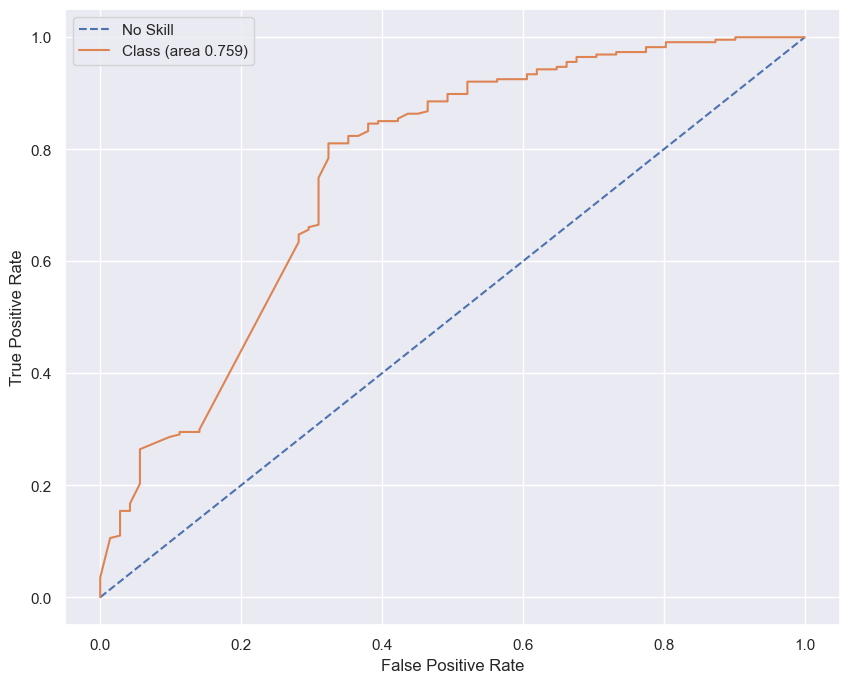



Cohen's kappa: 25.67%




In [67]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for Count Vectors\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Gradient Boosting with early stopping for TF-IDF

Early Stopping : 5 iterations without change
Execution time : 0.514 s
Score : 78.19 %

Classification Report

              precision    recall  f1-score   support

    negative       0.64      0.20      0.30        71
    positive       0.79      0.96      0.87       227

    accuracy                           0.78       298
   macro avg       0.71      0.58      0.59       298
weighted avg       0.76      0.78      0.74       298


Confusion Matrix





Model: f1-score=0.871 AUC=0.877




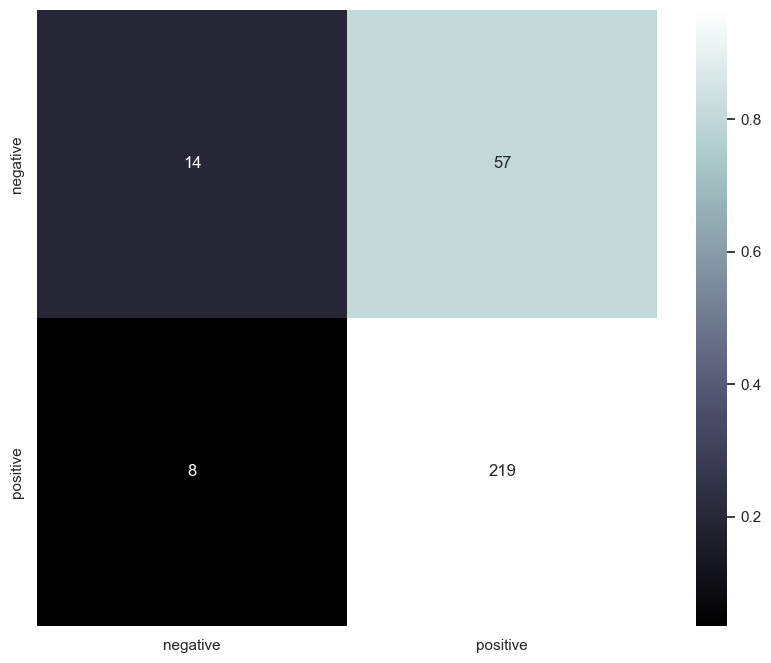

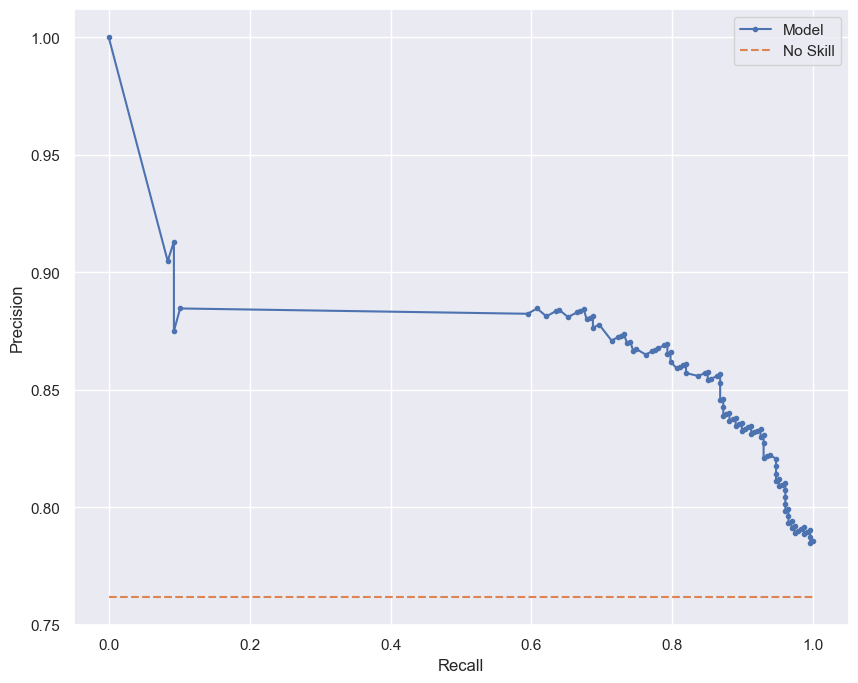




ROC AUC=0.741 



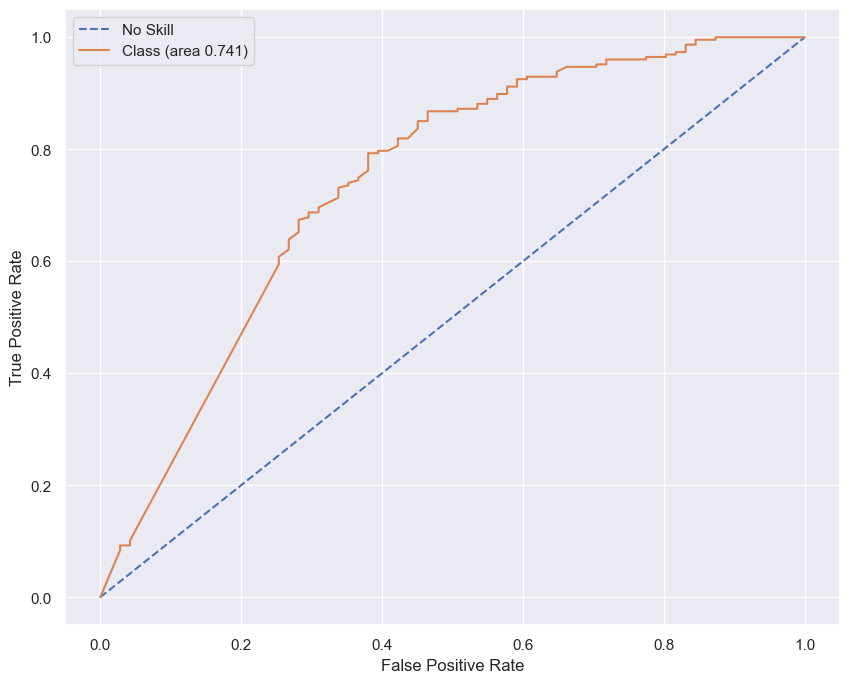



Cohen's kappa: 21.23%




In [68]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Gradient Boosting with early stopping for TF_IDF ngram

Early Stopping : 5 iterations without change
Execution time : 0.208 s
Score : 76.85 %

Classification Report

              precision    recall  f1-score   support

    negative       0.60      0.08      0.15        71
    positive       0.77      0.98      0.87       227

    accuracy                           0.77       298
   macro avg       0.69      0.53      0.51       298
weighted avg       0.73      0.77      0.69       298


Confusion Matrix





Model: f1-score=0.866 AUC=0.495




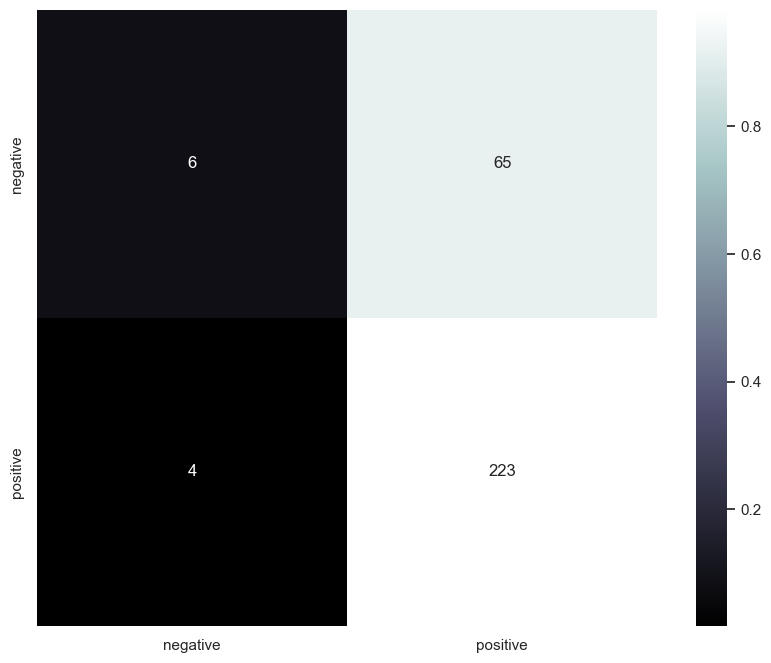

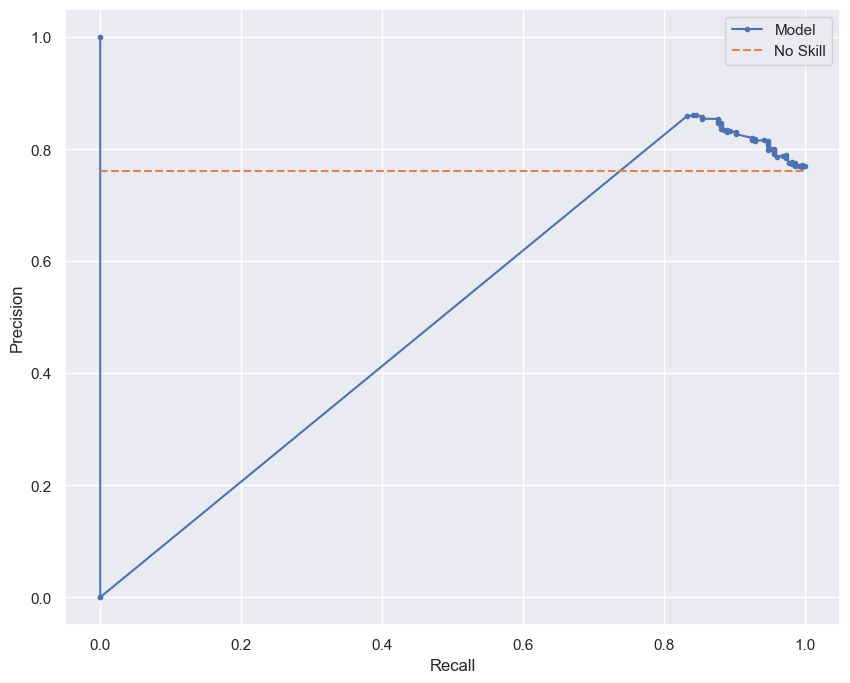




ROC AUC=0.697 



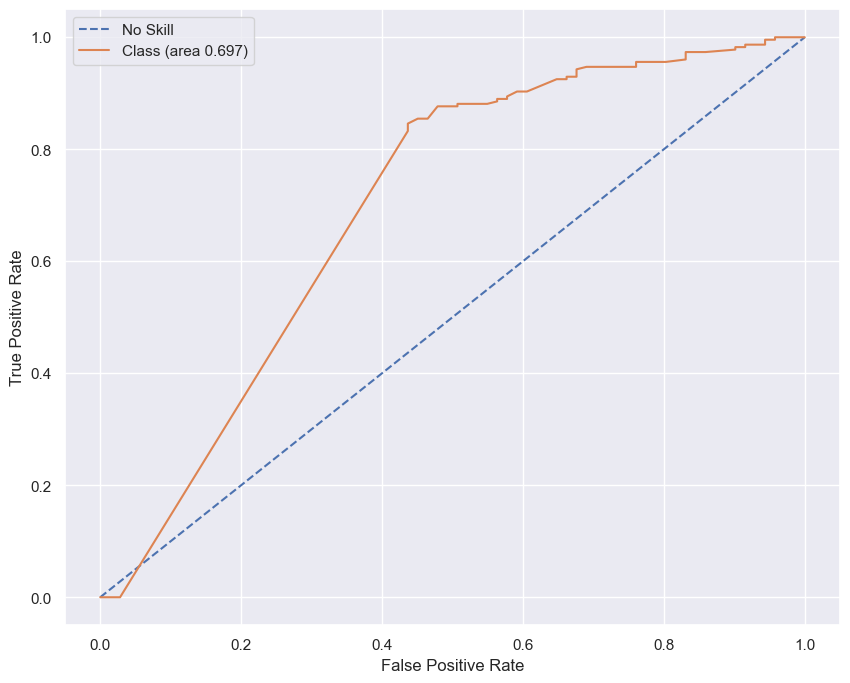



Cohen's kappa: 9.49%




In [69]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF_IDF ngram\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Gradient Boosting with early stopping for TF-IDF ngram chars

Early Stopping : 5 iterations without change
Execution time : 5.957 s
Score : 79.53 %

Classification Report

              precision    recall  f1-score   support

    negative       0.71      0.24      0.36        71
    positive       0.80      0.97      0.88       227

    accuracy                           0.80       298
   macro avg       0.76      0.60      0.62       298
weighted avg       0.78      0.80      0.75       298


Confusion Matrix





Model: f1-score=0.878 AUC=0.860




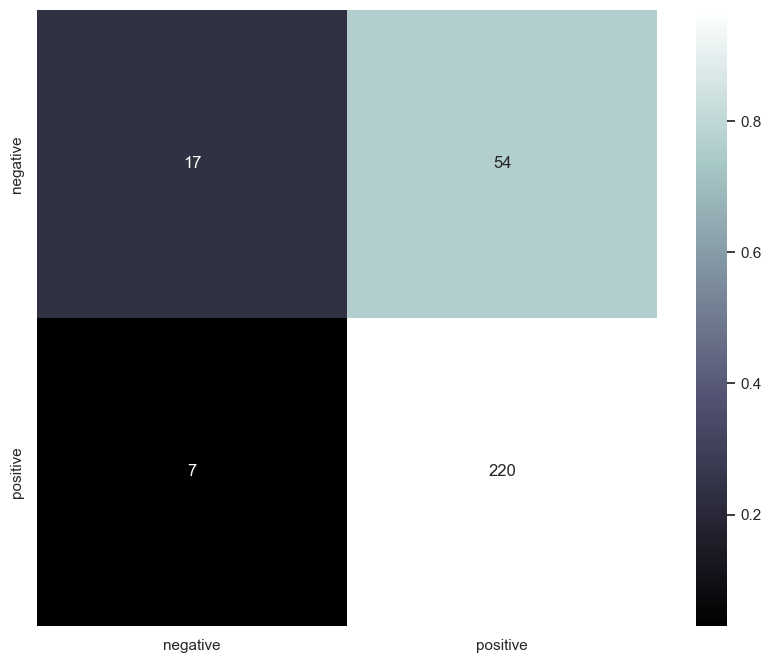

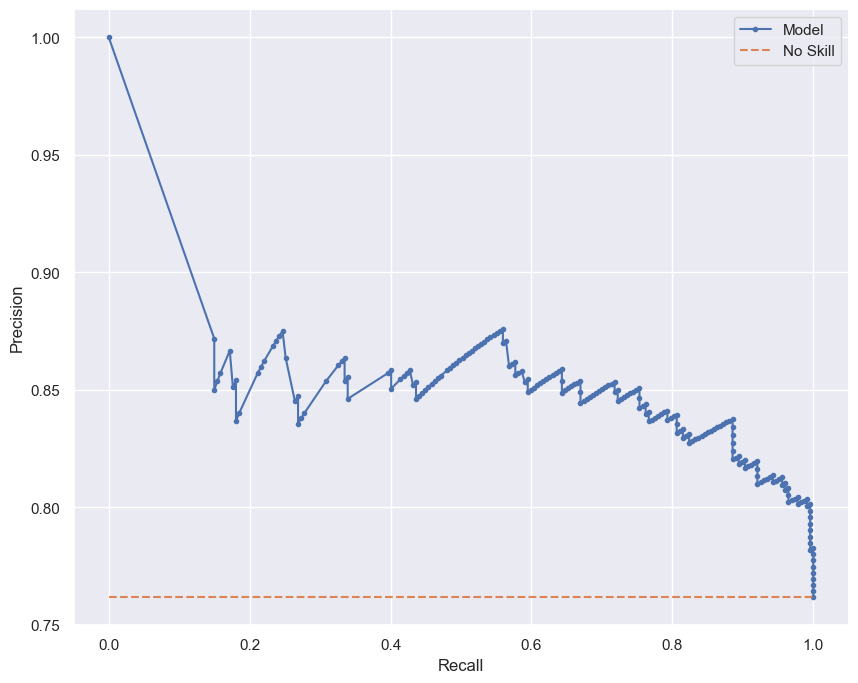




ROC AUC=0.698 



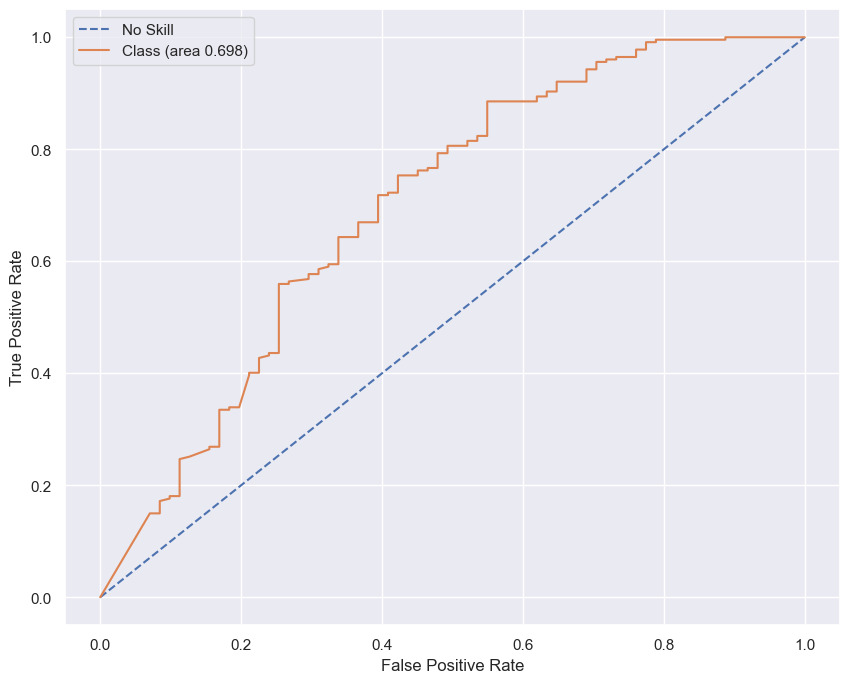



Cohen's kappa: 27.0%




In [23]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF ngram chars\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)


Gradient Boosting with early stopping for Word Embeddings

Early Stopping : 5 iterations without change
Execution time : 0.230 s
Score : 76.17 %

Classification Report

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        71
    positive       0.76      1.00      0.86       227

    accuracy                           0.76       298
   macro avg       0.38      0.50      0.43       298
weighted avg       0.58      0.76      0.66       298


Confusion Matrix





Model: f1-score=0.865 AUC=0.773




C:\Users\omarb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omarb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omarb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


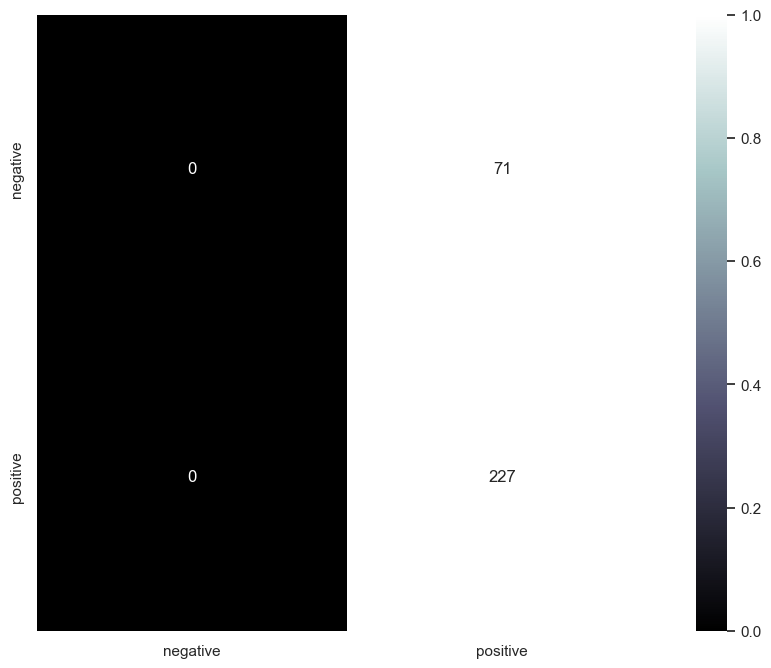

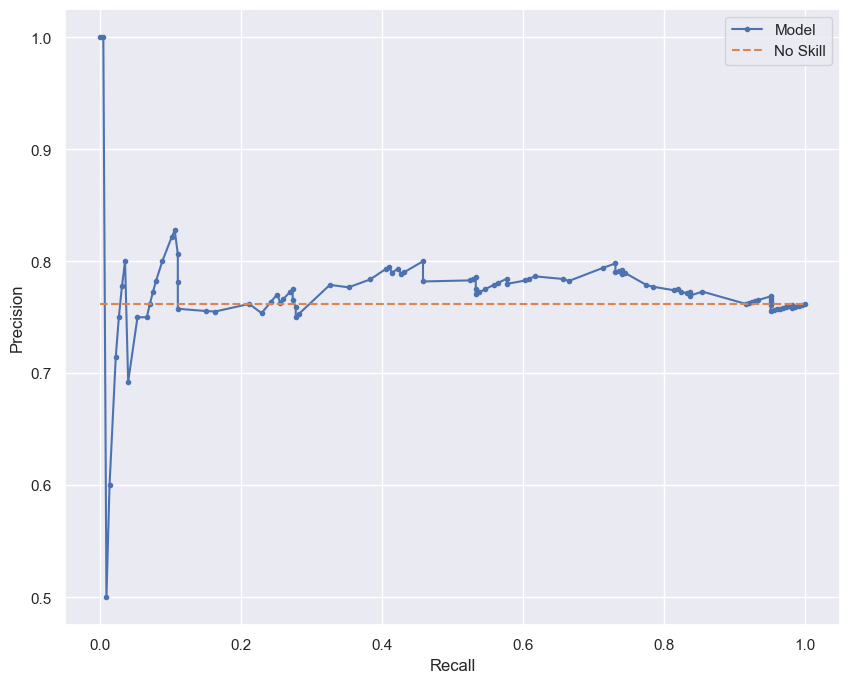




ROC AUC=0.537 



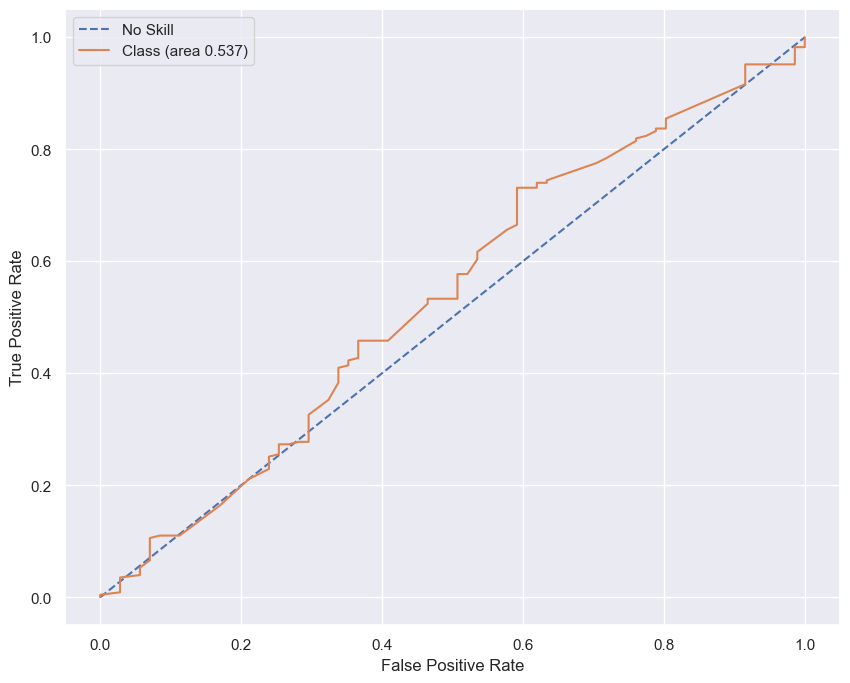



Cohen's kappa: 0.0%




In [24]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for Word Embeddings\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),train_seq_x, train_y, valid_seq_x, valid_y, gb=True)

In [25]:

def xgb_model(X_train, y_train, X_test, y_test, labels=labels):
    model = XGBClassifier(n_estimators=1000, subsample=0.8)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if len(labels)>2:
        model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    else:
        model.fit(X_train, y_train, eval_metric=["error", "logloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(valid_y, predictions)
    print("\nAccuracy: %.2f%%" % (accuracy * 100.0))
    return model, y_pred, accuracy

def rmsle_eval(y, y0):
    
    y0=y0.get_label()    
    assert len(y) == len(y0)
    return 'error',np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))


XGBoost for Count Vectors



C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



Accuracy: 80.87%

Classification Report

              precision    recall  f1-score   support

    negative       0.71      0.34      0.46        71
    positive       0.82      0.96      0.88       227

    accuracy                           0.81       298
   macro avg       0.76      0.65      0.67       298
weighted avg       0.79      0.81      0.78       298


Confusion Matrix



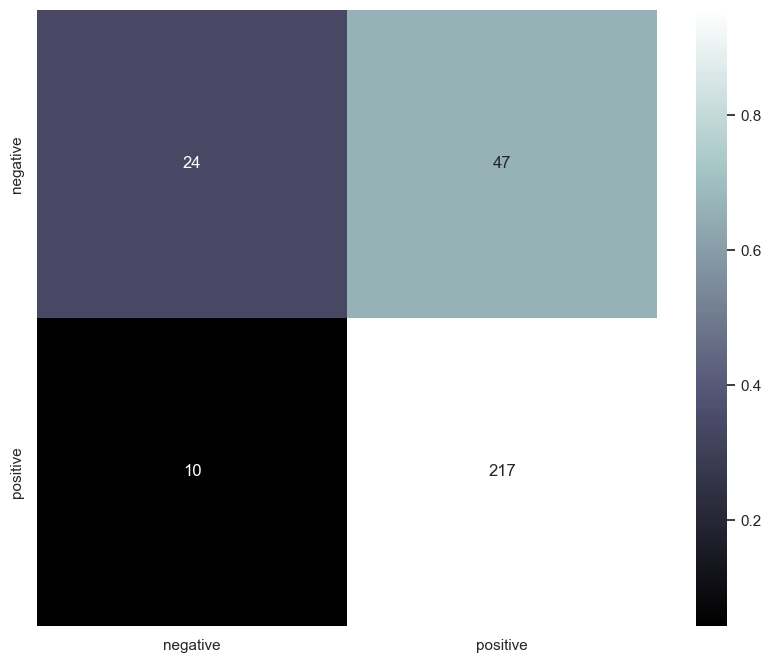

In [29]:
if xgboost_classifier:
    print("\nXGBoost for Count Vectors\n")
    xgbs, pred, accuracy = xgb_model(xtrain_count, train_y_sw, xvalid_count, valid_y_sw, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred, target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)



XGBoost for TF_IDF



C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



Accuracy: 81.21%

Classification Report

              precision    recall  f1-score   support

    negative       0.70      0.37      0.48        71
    positive       0.83      0.95      0.89       227

    accuracy                           0.81       298
   macro avg       0.77      0.66      0.68       298
weighted avg       0.80      0.81      0.79       298


Confusion Matrix



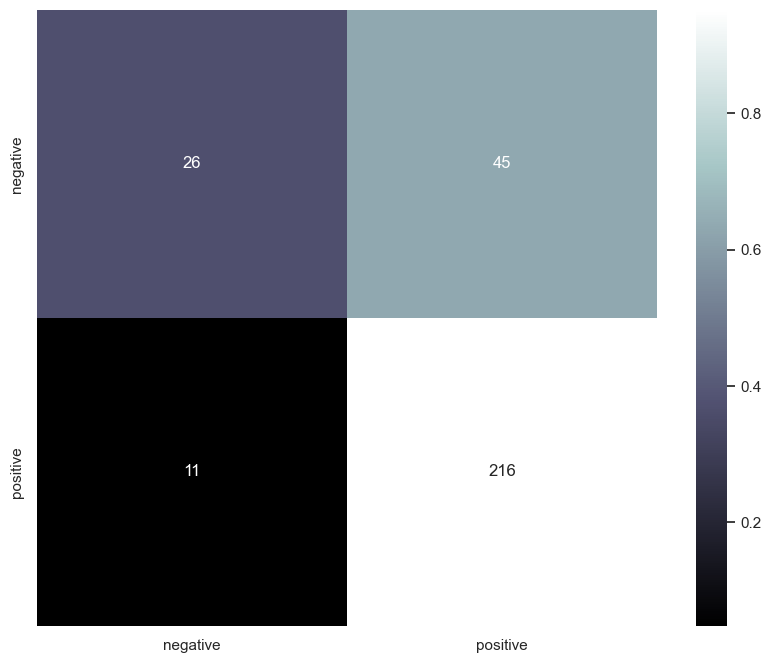

In [31]:
if xgboost_classifier:
    print("\nXGBoost for TF_IDF\n")
    xgbs, pred, accuracy = xgb_model(xtrain_tfidf, train_y, xvalid_tfidf, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)


XGBoost for TF_IDF ngram



C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



Accuracy: 78.86%

Classification Report

              precision    recall  f1-score   support

    negative       0.62      0.28      0.39        71
    positive       0.81      0.95      0.87       227

    accuracy                           0.79       298
   macro avg       0.72      0.61      0.63       298
weighted avg       0.76      0.79      0.76       298


Confusion Matrix



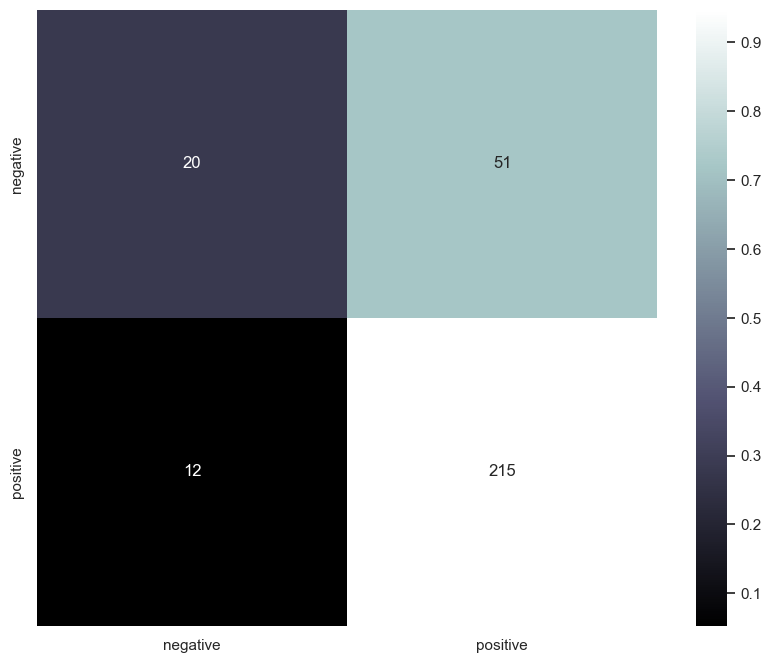

In [33]:
if xgboost_classifier:
    print("\nXGBoost for TF_IDF ngram\n")
    xgbs, pred, accuracy = xgb_model(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)


XGBoost for TF-IDF ngram chars



C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



Accuracy: 79.19%

Classification Report

              precision    recall  f1-score   support

    negative       0.65      0.28      0.39        71
    positive       0.81      0.95      0.87       227

    accuracy                           0.79       298
   macro avg       0.73      0.62      0.63       298
weighted avg       0.77      0.79      0.76       298


Confusion Matrix



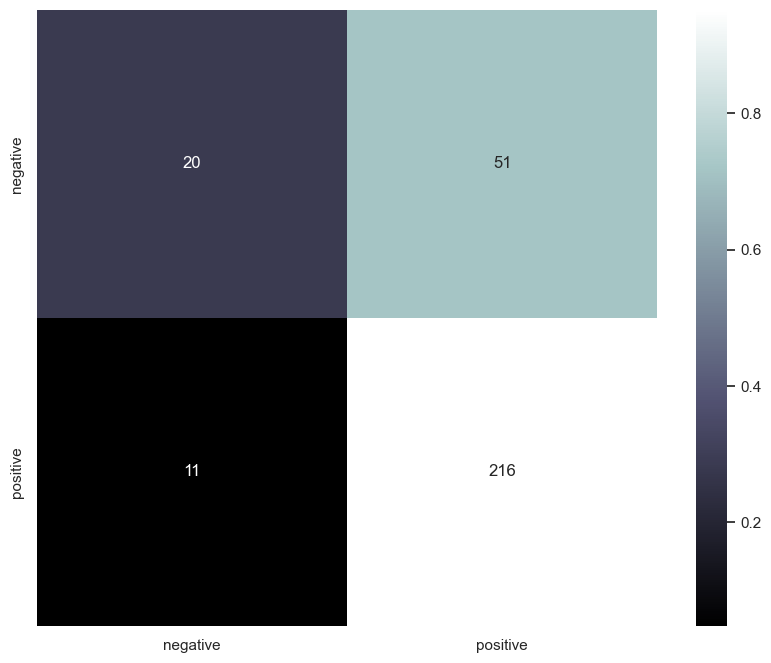

In [34]:
if xgboost_classifier:
    print("\nXGBoost for TF-IDF ngram chars\n")
    xgbs, pred, accuracy = xgb_model(xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred,target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)


XGBoost for Word Embeddings


Accuracy: 75.50%

Classification Report

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        71
    positive       0.76      0.99      0.86       227

    accuracy                           0.76       298
   macro avg       0.38      0.50      0.43       298
weighted avg       0.58      0.76      0.66       298


Confusion Matrix



C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\omarb\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


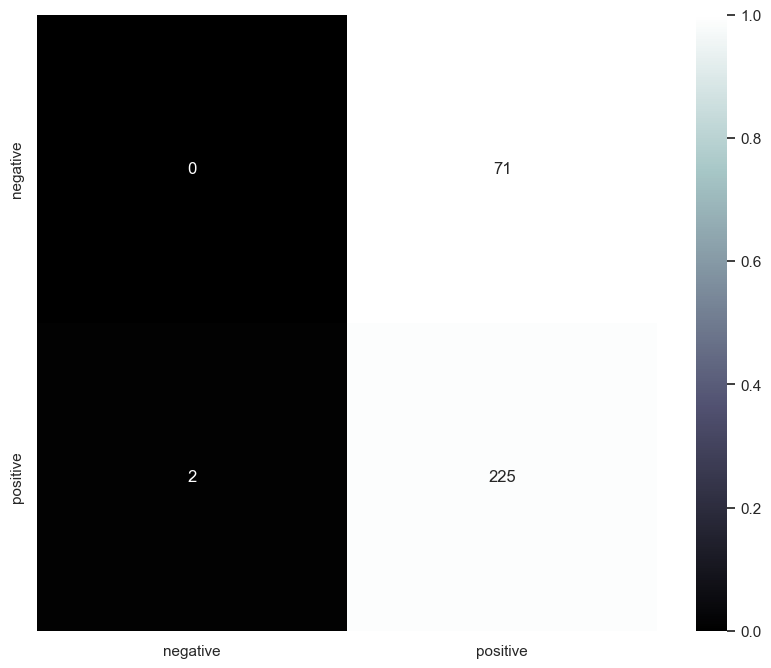

In [35]:
if xgboost_classifier:
    print("\nXGBoost for Word Embeddings\n")
    xgbs, pred, accuracy = xgb_model(train_seq_x, train_y, valid_seq_x, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)

In [36]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

In [43]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )                                   
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 2.0839160839160837, 1: 0.6578366445916115}

In [44]:
class_w = {}
for i in zip(range(len(class_weights)), class_weights):
    class_w[i[0]] = i[1]

In [45]:
def shallow_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a shallow neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) shallow neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop,
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [46]:
if shallow_network:
    model_shallow = shallow_neural_networks(word_index, pre_trained=pre_trained)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          102976    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 102993 (402.32 KB)
Trainable params: 102993 (402.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [72]:
if shallow_network:
    history = model_shallow.fit(train_seq_x, train_y,
                    epochs=2000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/2000
30/30 [==============================] - 0s 5ms/step - loss: 0.1638 - accuracy: 0.9507 - val_loss: 0.4237 - val_accuracy: 0.8452
Epoch 2/2000
30/30 [==============================] - 0s 4ms/step - loss: 0.1623 - accuracy: 0.9507 - val_loss: 0.4252 - val_accuracy: 0.8494
Epoch 3/2000
30/30 [==============================] - 0s 4ms/step - loss: 0.1607 - accuracy: 0.9517 - val_loss: 0.4257 - val_accuracy: 0.8494
Epoch 4/2000
30/30 [==============================] - 0s 4ms/step - loss: 0.1594 - accuracy: 0.9517 - val_loss: 0.4253 - val_accuracy: 0.8494


In [73]:
if shallow_network:
    results = model_shallow.evaluate(valid_seq_x, valid_y)
    print(results)
    #print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model_shallow.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

10/10 [==============================] - 0s 1ms/step - loss: 0.4668 - accuracy: 0.8255
[0.4668310284614563, 0.8255033493041992]


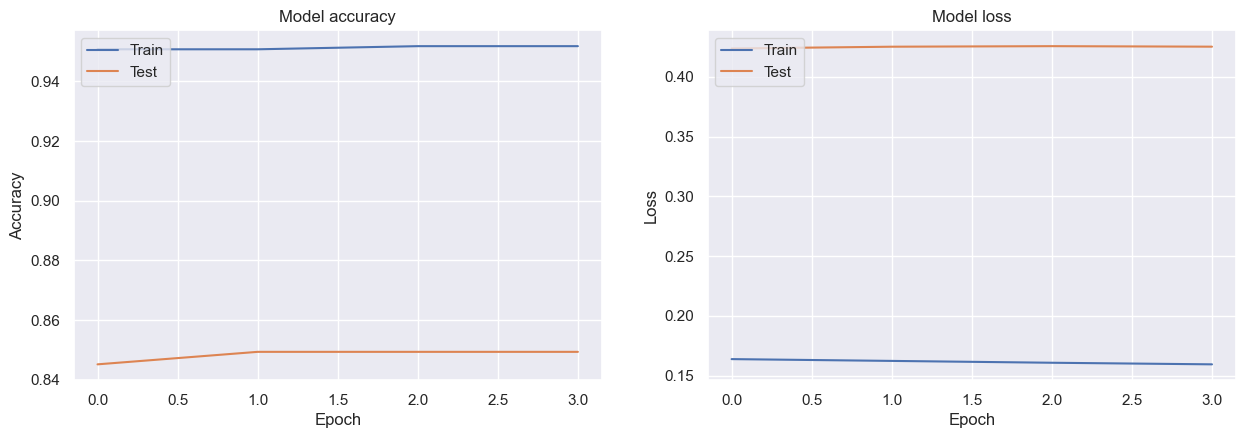

10/10 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

    negative       0.73      0.42      0.54        71
    positive       0.84      0.95      0.89       227

    accuracy                           0.83       298
   macro avg       0.79      0.69      0.71       298
weighted avg       0.81      0.83      0.81       298

10/10 [==============================] - 0s 1ms/step

The balanced accuracy is : 68.7%

10/10 [==============================] - 0s 1ms/step

The Zero-one Loss is : 17.45%

10/10 [==============================] - 0s 1ms/step

Explained variance score: 0.094

10/10 [==============================] - 0s 1ms/step

ROC AUC=0.810 



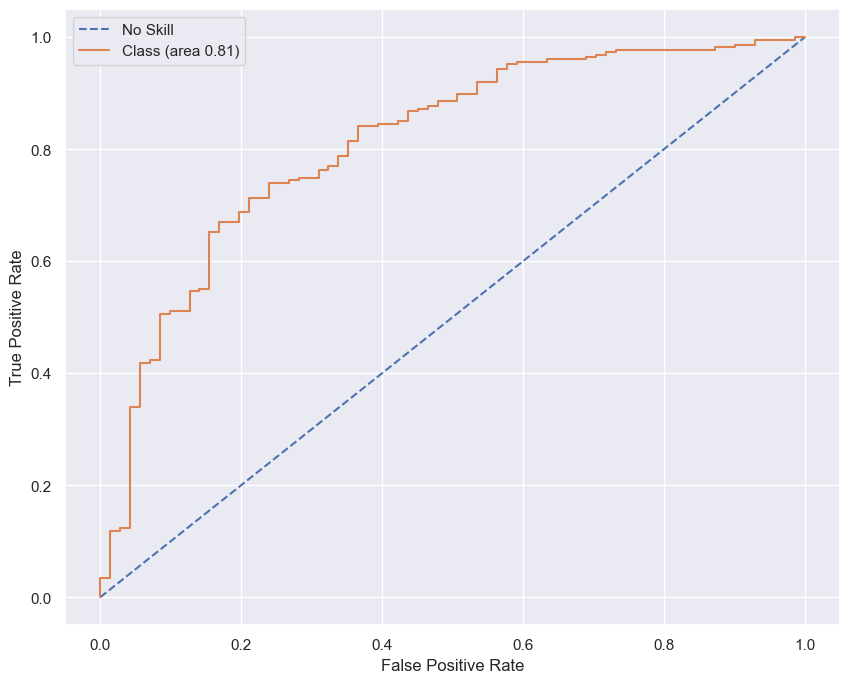

10/10 [==============================] - 0s 1ms/step


Model: f1-score=0.893 AUC=0.918




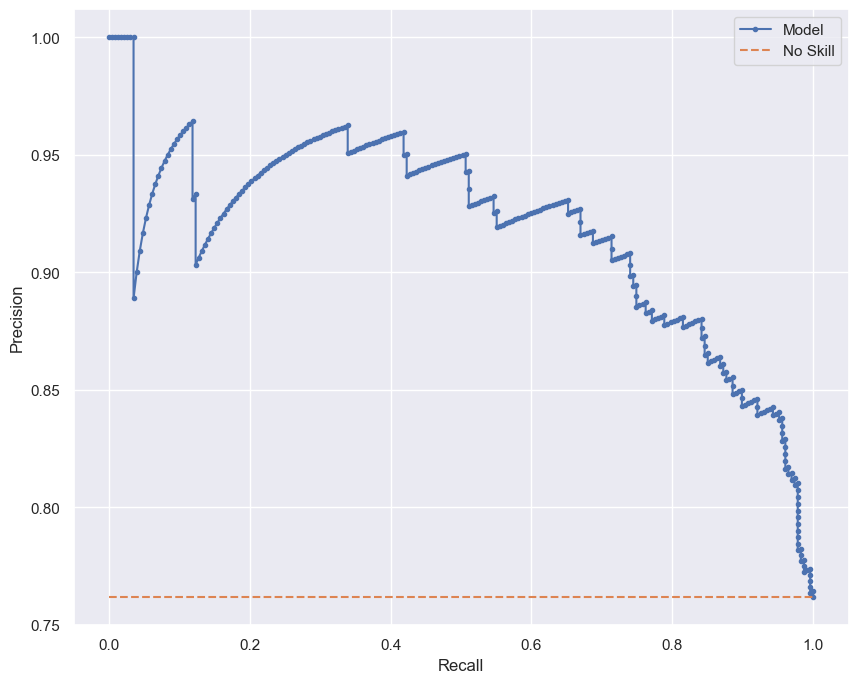

10/10 [==============================] - 0s 1ms/step

Cohen's kappa: 43.76% 

10/10 [==============================] - 0s 1ms/step

Confusion Matrix



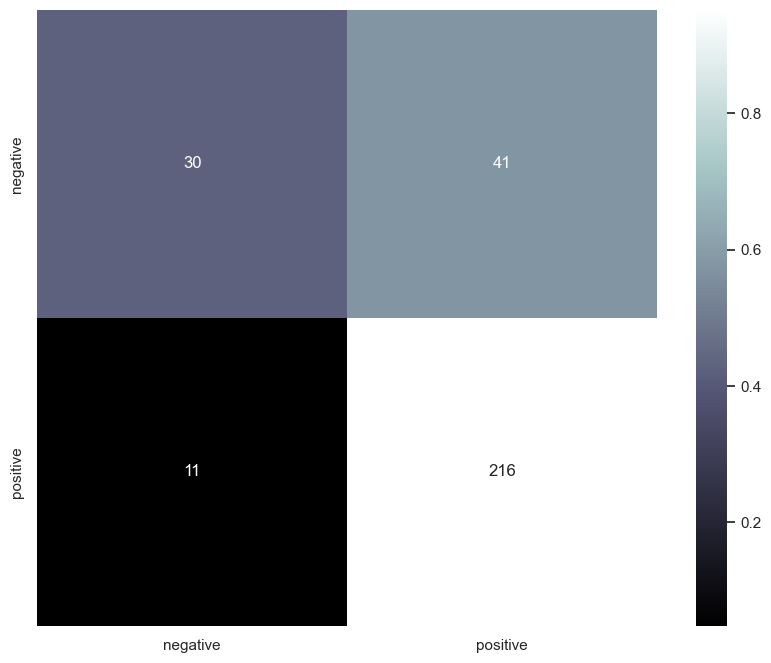

In [74]:
if shallow_network:
    Metric.metrics_deep_learning(model_shallow, history, valid_seq_x, valid_y, labels)

In [75]:
def deep_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [76]:
if deep_nn:
    model = deep_neural_networks(word_index, pre_trained=pre_trained)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         643600    
                                                                 
 global_average_pooling1d_1  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 16)                1616      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 645233 (2.46 MB)
Trainable params: 645233 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [79]:
if deep_nn:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000
30/30 [==============================] - 0s 13ms/step - loss: 0.1807 - accuracy: 0.9444 - val_loss: 0.4201 - val_accuracy: 0.8368
Epoch 2/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.1650 - accuracy: 0.9486 - val_loss: 0.4152 - val_accuracy: 0.8410
Epoch 3/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.1571 - accuracy: 0.9528 - val_loss: 0.4252 - val_accuracy: 0.8494
Epoch 4/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.1474 - accuracy: 0.9538 - val_loss: 0.4241 - val_accuracy: 0.8494
Epoch 5/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.1405 - accuracy: 0.9549 - val_loss: 0.4278 - val_accuracy: 0.8577


In [80]:
if deep_nn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

10/10 [==============================] - 0s 3ms/step - loss: 0.4675 - accuracy: 0.8121
[0.4674971401691437, 0.8120805621147156]


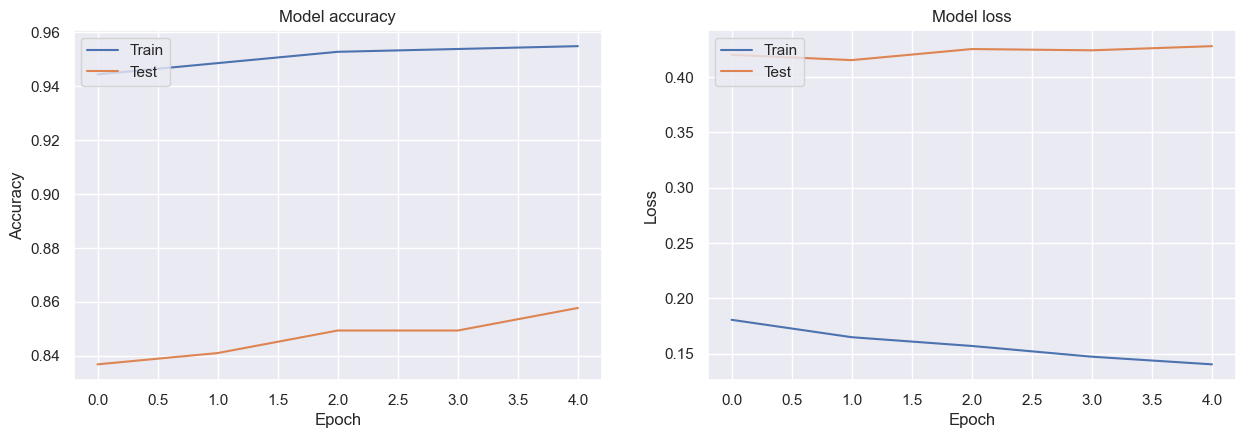

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

    negative       0.66      0.44      0.53        71
    positive       0.84      0.93      0.88       227

    accuracy                           0.81       298
   macro avg       0.75      0.68      0.70       298
weighted avg       0.80      0.81      0.80       298

10/10 [==============================] - 0s 3ms/step

The balanced accuracy is : 68.31%

10/10 [==============================] - 0s 3ms/step

The Zero-one Loss is : 18.79%

10/10 [==============================] - 0s 3ms/step

Explained variance score: 0.0

10/10 [==============================] - 0s 3ms/step

ROC AUC=0.810 



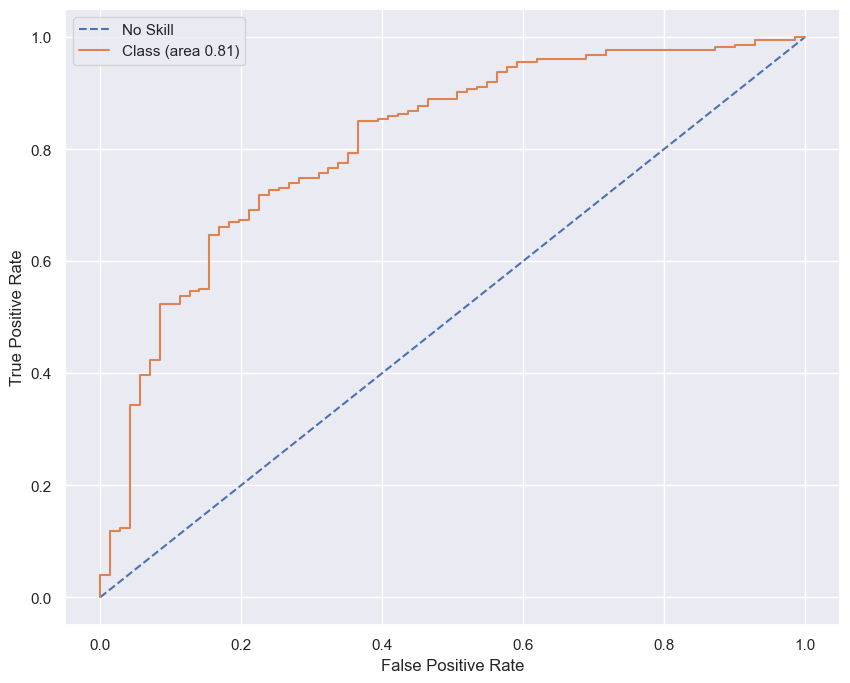

10/10 [==============================] - 0s 2ms/step


Model: f1-score=0.883 AUC=0.918




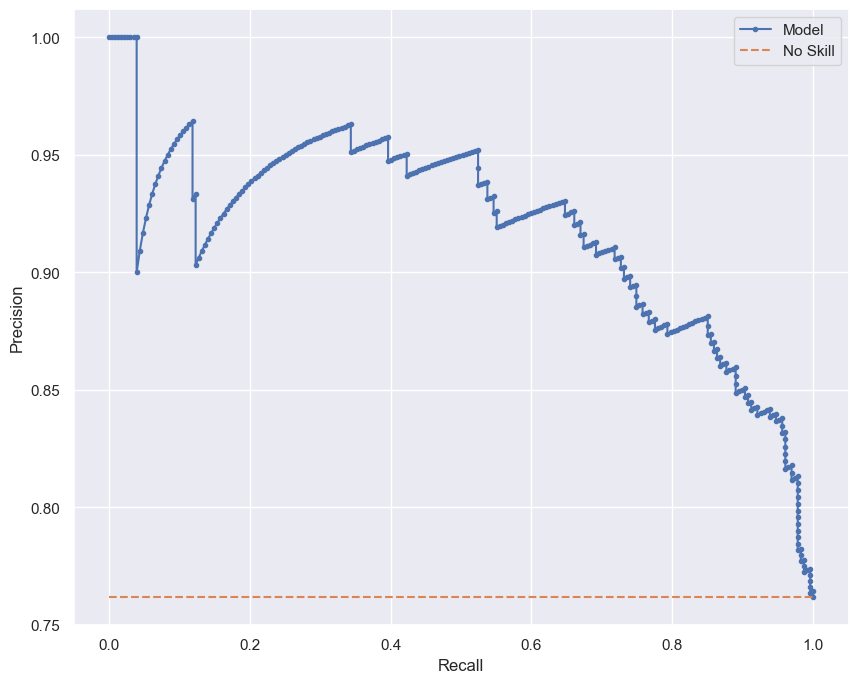

10/10 [==============================] - 0s 2ms/step

Cohen's kappa: 41.43% 

10/10 [==============================] - 0s 3ms/step

Confusion Matrix



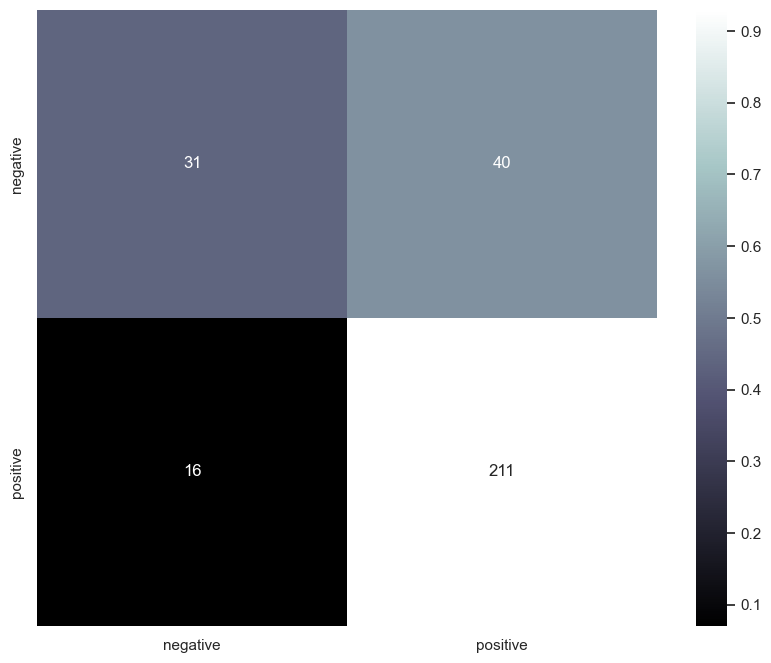

In [81]:
if deep_nn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [82]:
def deep_neural_networks_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model
if deep_nn:
    model = deep_neural_networks_var1(word_index, pre_trained=pre_trained)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         643600    
                                                                 
 global_average_pooling1d_2  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 16)                1616      
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 645505 (2.46 MB)
Trainable params: 645505 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [83]:
if deep_nn:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)

Epoch 1/1000


C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 1s 17ms/step - loss: 0.6662 - accuracy: 0.7356 - val_loss: 0.6214 - val_accuracy: 0.7950
Epoch 2/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.5927 - accuracy: 0.7513 - val_loss: 0.5222 - val_accuracy: 0.7950
Epoch 3/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.5587 - accuracy: 0.7513 - val_loss: 0.5108 - val_accuracy: 0.7950
Epoch 4/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.5540 - accuracy: 0.7513 - val_loss: 0.5084 - val_accuracy: 0.7950
Epoch 5/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.5501 - accuracy: 0.7513 - val_loss: 0.5085 - val_accuracy: 0.7950
Epoch 6/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.5453 - accuracy: 0.7513 - val_loss: 0.5006 - val_accuracy: 0.7950
Epoch 7/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.5400 - accuracy: 0.7513 - val_loss: 0.4981 - val_accuracy: 0.7950
Epoch 8/1000

In [84]:
if deep_nn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

10/10 [==============================] - 0s 3ms/step - loss: 0.4690 - accuracy: 0.8154
[0.46903541684150696, 0.8154362440109253]


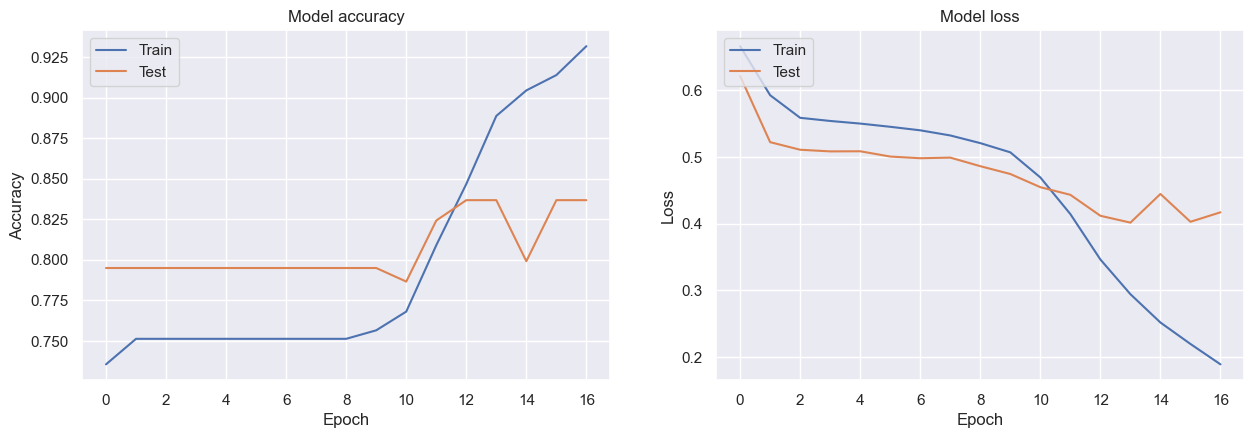

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

    negative       0.72      0.37      0.49        71
    positive       0.83      0.96      0.89       227

    accuracy                           0.82       298
   macro avg       0.78      0.66      0.69       298
weighted avg       0.80      0.82      0.79       298

10/10 [==============================] - 0s 3ms/step

The balanced accuracy is : 66.11%

10/10 [==============================] - 0s 2ms/step

The Zero-one Loss is : 18.46%

10/10 [==============================] - 0s 3ms/step

Explained variance score: 0.059

10/10 [==============================] - 0s 2ms/step

ROC AUC=0.812 



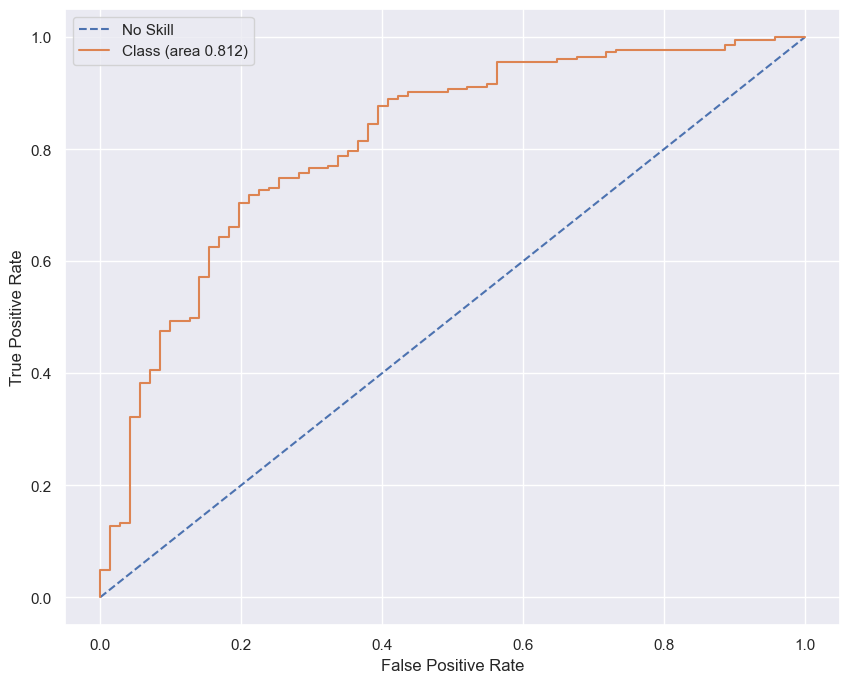

10/10 [==============================] - 0s 2ms/step


Model: f1-score=0.888 AUC=0.919




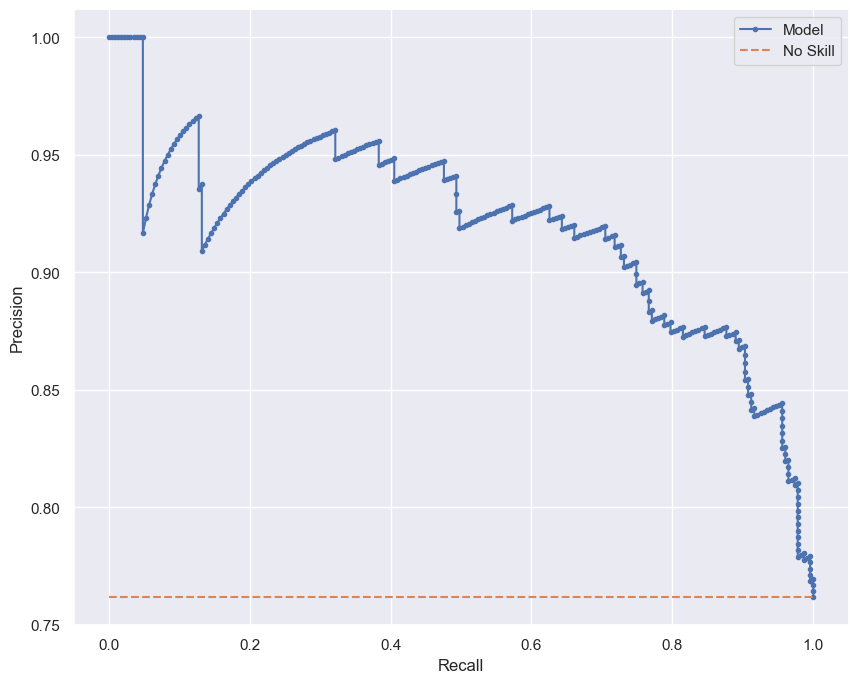

10/10 [==============================] - 0s 3ms/step

Cohen's kappa: 38.78% 

10/10 [==============================] - 0s 3ms/step

Confusion Matrix



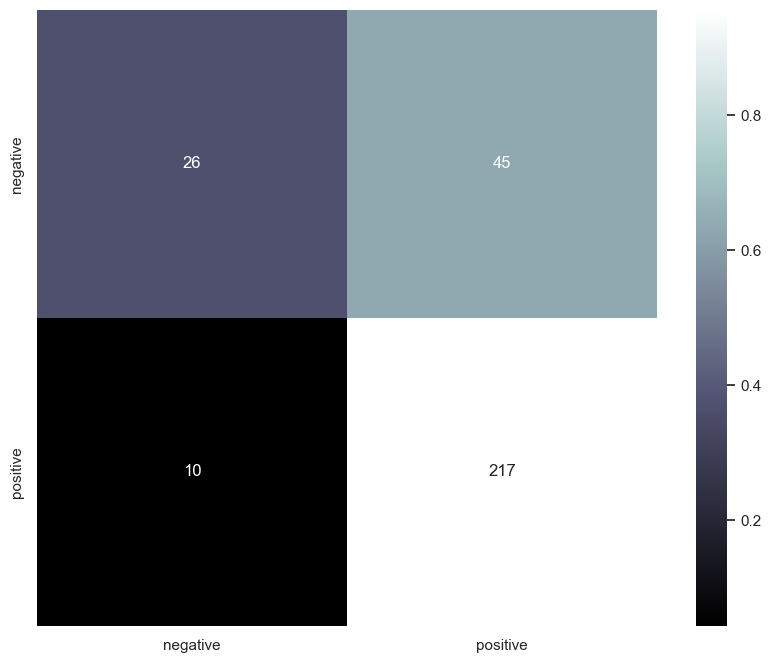

In [85]:
if deep_nn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [86]:
def deep_neural_networks_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model
if deep_nn:
    model = deep_neural_networks_var2(word_index, pre_trained=pre_trained)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         643600    
                                                                 
 global_average_pooling1d_3  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 32)                3232      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 647377 (2.47 MB)
Trainable params: 647377 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [87]:
if deep_nn:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)

Epoch 1/1000


C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 1s 16ms/step - loss: 0.6525 - accuracy: 0.7240 - val_loss: 0.5787 - val_accuracy: 0.7950
Epoch 2/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.5635 - accuracy: 0.7513 - val_loss: 0.5070 - val_accuracy: 0.7950
Epoch 3/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.5557 - accuracy: 0.7513 - val_loss: 0.5089 - val_accuracy: 0.7950
Epoch 4/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.5498 - accuracy: 0.7513 - val_loss: 0.5062 - val_accuracy: 0.7950
Epoch 5/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.5448 - accuracy: 0.7513 - val_loss: 0.5010 - val_accuracy: 0.7950
Epoch 6/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.5340 - accuracy: 0.7513 - val_loss: 0.4972 - val_accuracy: 0.7950
Epoch 7/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.5184 - accuracy: 0.7513 - val_loss: 0.4912 - val_accuracy: 0.7992
Epoch 8/1000

In [88]:
if deep_nn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

10/10 [==============================] - 0s 3ms/step - loss: 0.4676 - accuracy: 0.8087
[0.46763691306114197, 0.8087248206138611]


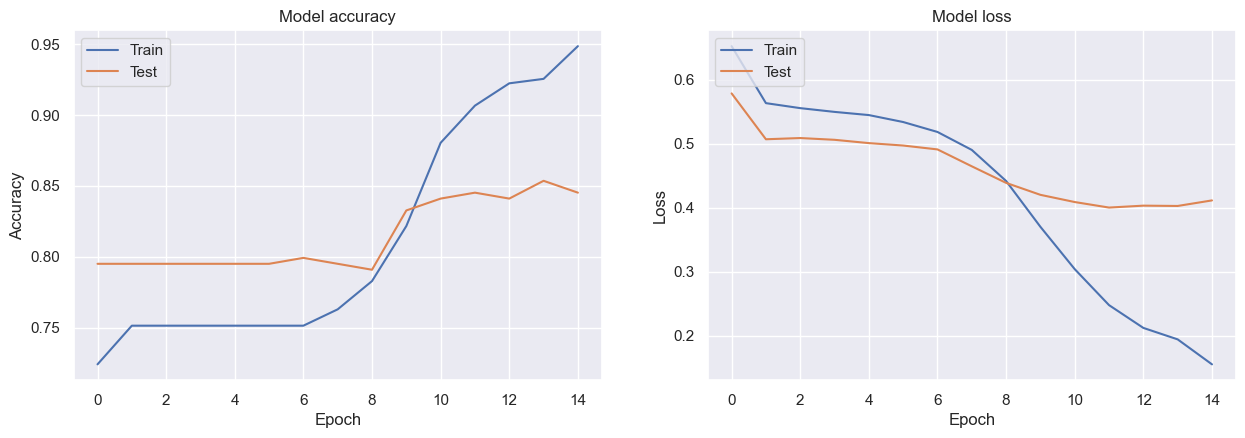

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

    negative       0.65      0.44      0.52        71
    positive       0.84      0.93      0.88       227

    accuracy                           0.81       298
   macro avg       0.74      0.68      0.70       298
weighted avg       0.79      0.81      0.79       298

10/10 [==============================] - 0s 3ms/step

The balanced accuracy is : 68.09%

10/10 [==============================] - 0s 3ms/step

The Zero-one Loss is : 19.13%

10/10 [==============================] - 0s 3ms/step

Explained variance score: -0.021

10/10 [==============================] - 0s 3ms/step

ROC AUC=0.810 



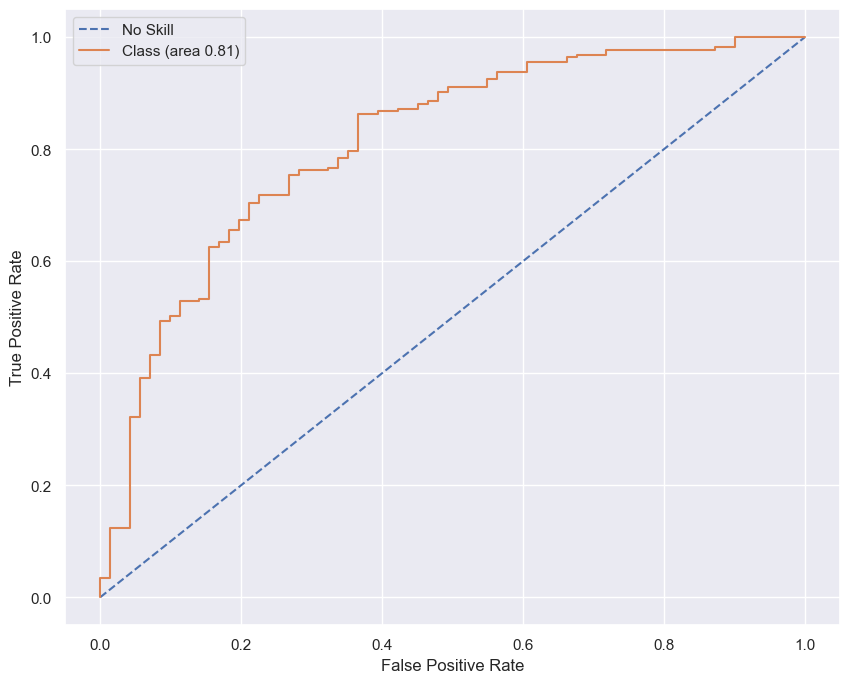

10/10 [==============================] - 0s 3ms/step


Model: f1-score=0.881 AUC=0.917




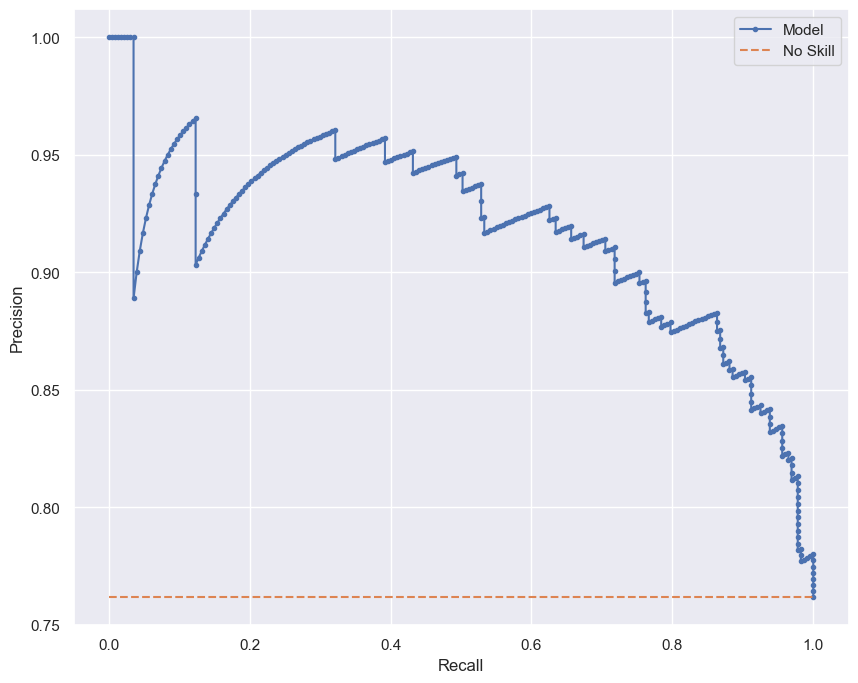

10/10 [==============================] - 0s 3ms/step

Cohen's kappa: 40.7% 

10/10 [==============================] - 0s 3ms/step

Confusion Matrix



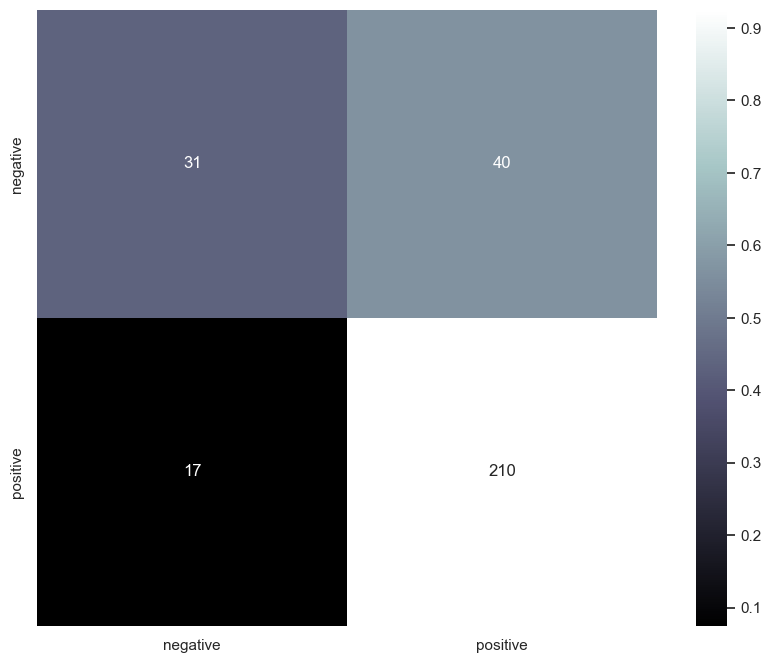

In [89]:
if deep_nn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)


In [90]:
def create_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a recurrent neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) recurrent neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model
if rnn:
    model = create_rnn_model(word_index, pre_trained=pre_trained )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         643600    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 32)          4256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 654129 (2.50 MB)
Trainable params: 65412

In [91]:
if rnn:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000


C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 9s 196ms/step - loss: 0.5780 - accuracy: 0.7366 - val_loss: 0.5109 - val_accuracy: 0.7950
Epoch 2/1000
30/30 [==============================] - 5s 184ms/step - loss: 0.4872 - accuracy: 0.7765 - val_loss: 0.5721 - val_accuracy: 0.7364
Epoch 3/1000
30/30 [==============================] - 5s 182ms/step - loss: 0.1788 - accuracy: 0.9391 - val_loss: 0.7004 - val_accuracy: 0.6569
Epoch 4/1000
30/30 [==============================] - 5s 180ms/step - loss: 0.0267 - accuracy: 0.9958 - val_loss: 0.9898 - val_accuracy: 0.5858


In [92]:
if rnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

10/10 [==============================] - 0s 44ms/step - loss: 1.0718 - accuracy: 0.5839
[1.0718274116516113, 0.5838926434516907]


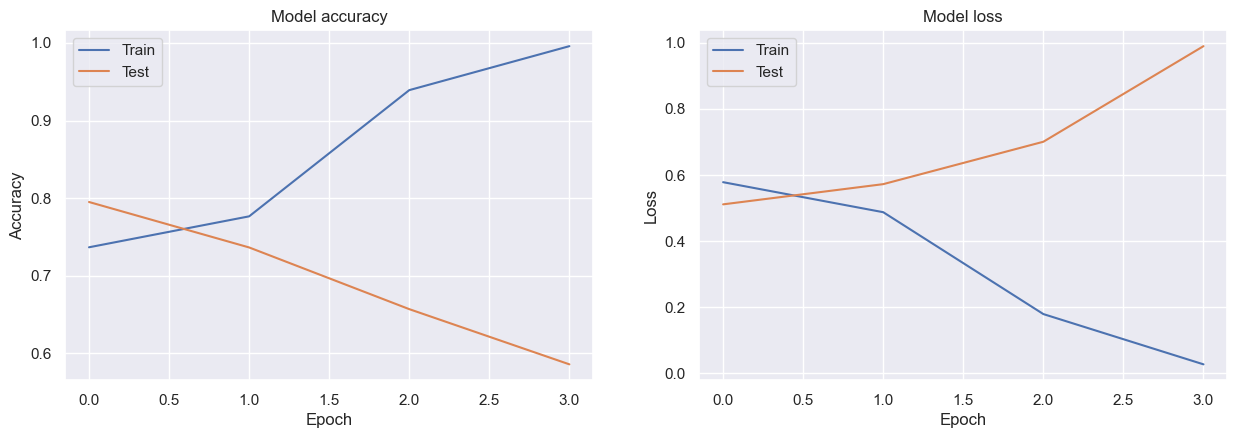

10/10 [==============================] - 1s 43ms/step
              precision    recall  f1-score   support

    negative       0.26      0.39      0.31        71
    positive       0.77      0.64      0.70       227

    accuracy                           0.58       298
   macro avg       0.51      0.52      0.51       298
weighted avg       0.65      0.58      0.61       298

10/10 [==============================] - 0s 44ms/step

The balanced accuracy is : 51.88%

10/10 [==============================] - 0s 43ms/step

The Zero-one Loss is : 41.61%

10/10 [==============================] - 0s 44ms/step

Explained variance score: -1.203

10/10 [==============================] - 0s 43ms/step

ROC AUC=0.516 



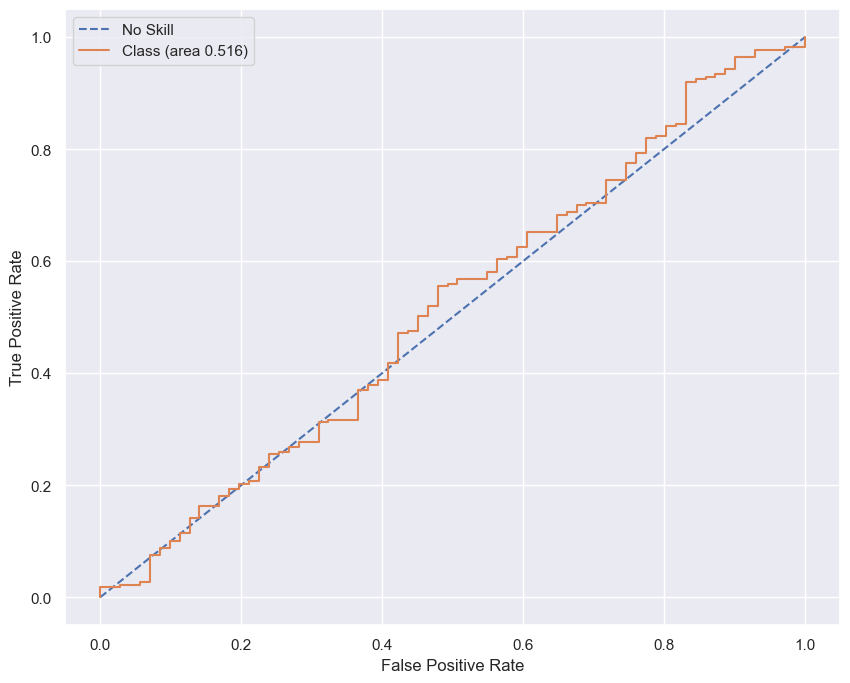

10/10 [==============================] - 0s 43ms/step


Model: f1-score=0.702 AUC=0.765




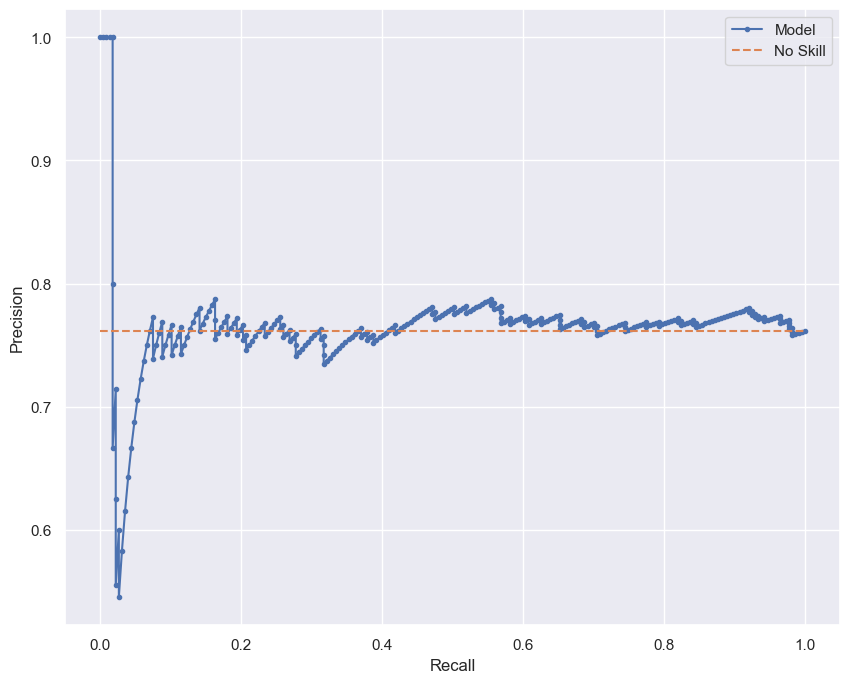

10/10 [==============================] - 0s 42ms/step

Cohen's kappa: 3.17% 

10/10 [==============================] - 0s 42ms/step

Confusion Matrix



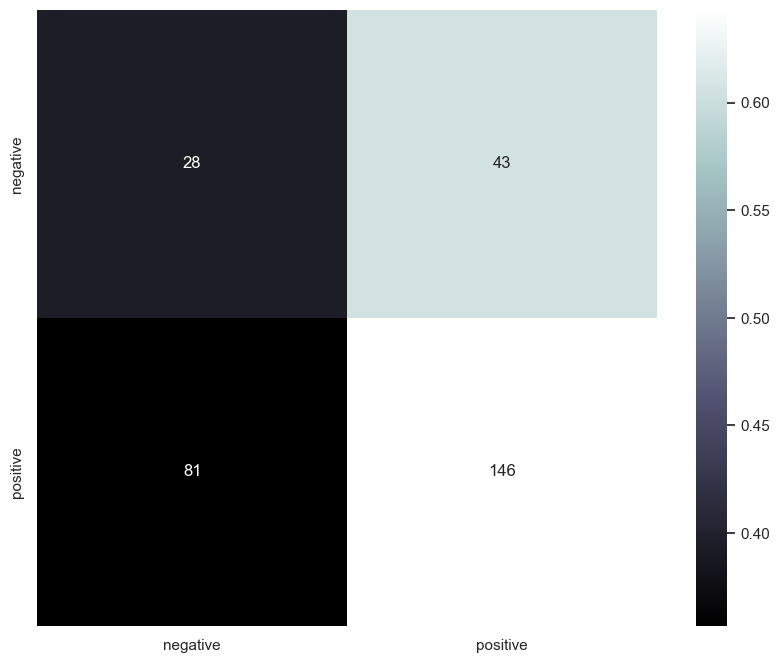

In [93]:
if rnn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [94]:
def create_conv_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a convulational neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(100, 5, activation='relu'), # padding='same'
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(64, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.GlobalMaxPooling1D(),

    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model
if cnn:
    model = create_conv_model(word_index, labels, pre_trained=pre_trained)

In [95]:
if cnn:
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50


C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 2s 54ms/step - loss: 0.5840 - accuracy: 0.7398 - val_loss: 0.5623 - val_accuracy: 0.7950
Epoch 2/50
30/30 [==============================] - 1s 47ms/step - loss: 0.5665 - accuracy: 0.7513 - val_loss: 0.5796 - val_accuracy: 0.7950
Epoch 3/50
30/30 [==============================] - 1s 48ms/step - loss: 0.5634 - accuracy: 0.7513 - val_loss: 0.5597 - val_accuracy: 0.7950
Epoch 4/50
30/30 [==============================] - 1s 45ms/step - loss: 0.5420 - accuracy: 0.7513 - val_loss: 0.5624 - val_accuracy: 0.7950
Epoch 5/50
30/30 [==============================] - 1s 45ms/step - loss: 0.4539 - accuracy: 0.7712 - val_loss: 0.4425 - val_accuracy: 0.8075
Epoch 6/50
30/30 [==============================] - 1s 45ms/step - loss: 0.3297 - accuracy: 0.8625 - val_loss: 0.4098 - val_accuracy: 0.8159
Epoch 7/50
30/30 [==============================] - 1s 45ms/step - loss: 0.2429 - accuracy: 0.9098 - val_loss: 0.4304 - val_accuracy: 0.8159
Epoch 8/50
30/30 [======

In [97]:
if cnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)


10/10 [==============================] - 0s 13ms/step - loss: 0.6476 - accuracy: 0.7886
[0.6476286053657532, 0.7885906100273132]


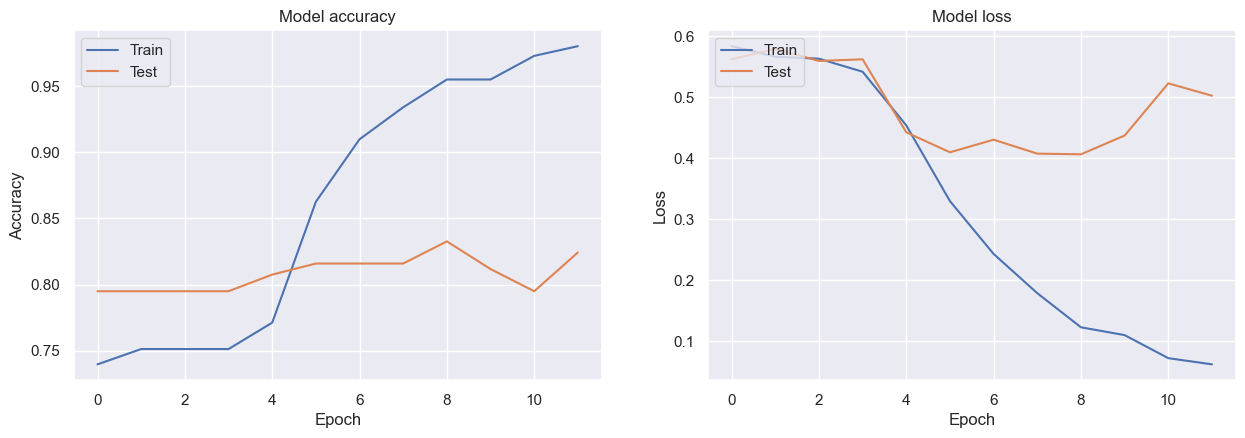

10/10 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

    negative       0.57      0.44      0.50        71
    positive       0.84      0.90      0.87       227

    accuracy                           0.79       298
   macro avg       0.71      0.67      0.68       298
weighted avg       0.77      0.79      0.78       298

10/10 [==============================] - 0s 9ms/step

The balanced accuracy is : 66.76%

10/10 [==============================] - 0s 10ms/step

The Zero-one Loss is : 21.14%

10/10 [==============================] - 0s 10ms/step

Explained variance score: -0.147

10/10 [==============================] - 0s 10ms/step

ROC AUC=0.781 



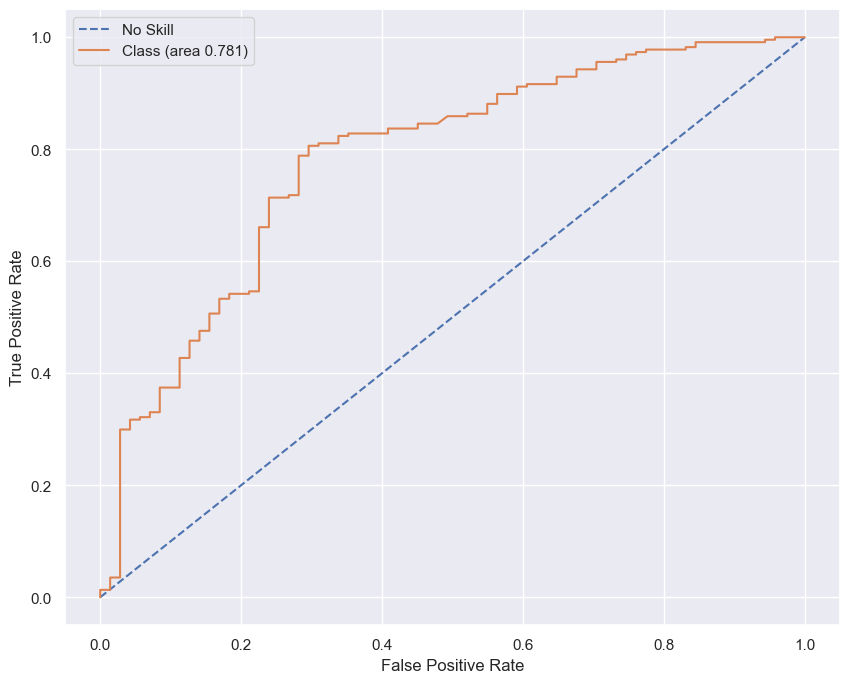

10/10 [==============================] - 0s 11ms/step


Model: f1-score=0.866 AUC=0.900




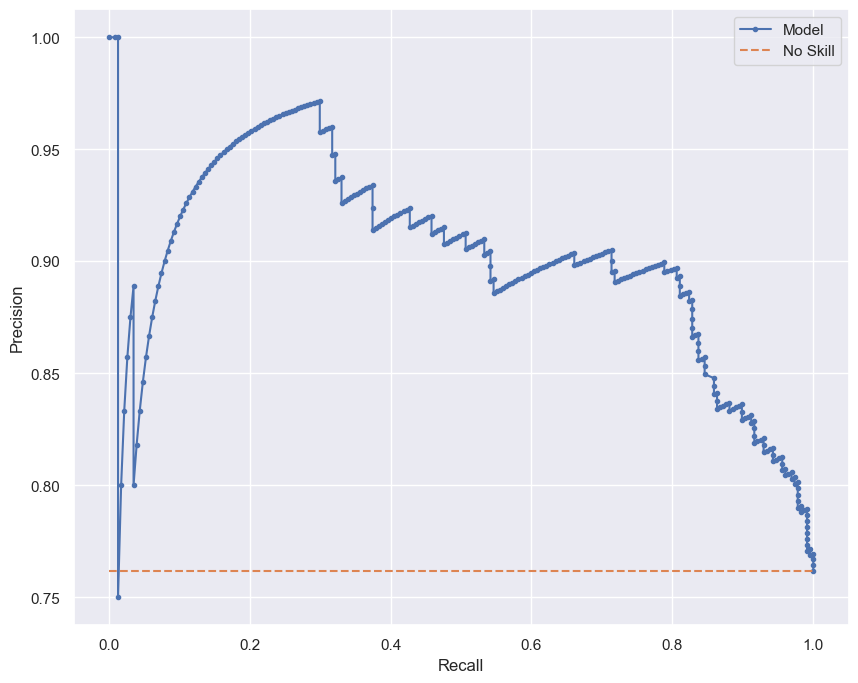

10/10 [==============================] - 0s 10ms/step

Cohen's kappa: 36.54% 

10/10 [==============================] - 0s 10ms/step

Confusion Matrix



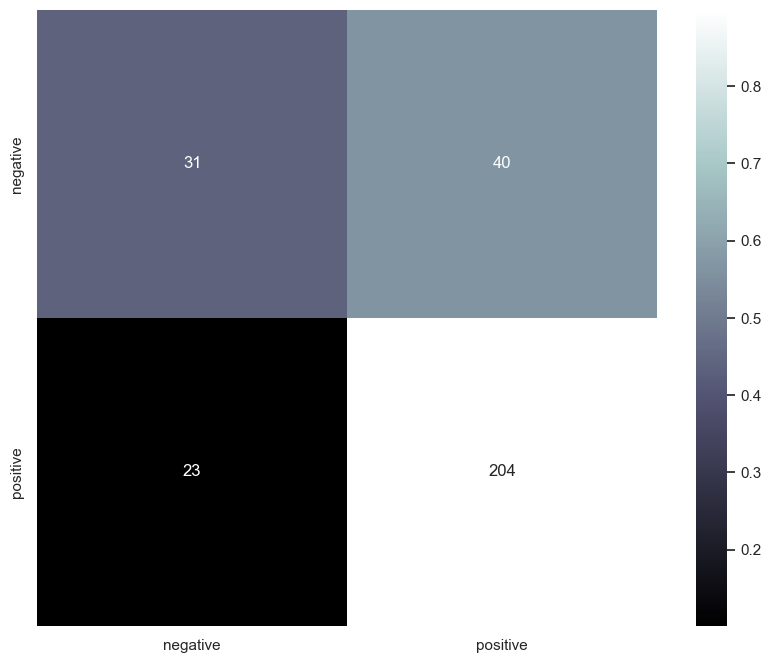

In [98]:
if cnn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [100]:
def create_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) lstm 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.LSTM(32),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model
if lstm:
    model = create_lstm_model(word_index, pre_trained=pre_trained)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         643600    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 660657 (2.52 MB)
Trainable params: 660657 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50


C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 6s 107ms/step - loss: 0.6268 - accuracy: 0.7471 - val_loss: 0.5011 - val_accuracy: 0.7950
Epoch 2/50
30/30 [==============================] - 3s 93ms/step - loss: 0.5048 - accuracy: 0.7524 - val_loss: 0.4575 - val_accuracy: 0.7908
Epoch 3/50
30/30 [==============================] - 3s 89ms/step - loss: 0.3502 - accuracy: 0.8311 - val_loss: 0.4128 - val_accuracy: 0.8117
Epoch 4/50
30/30 [==============================] - 3s 93ms/step - loss: 0.2190 - accuracy: 0.9286 - val_loss: 0.4628 - val_accuracy: 0.7490
Epoch 5/50
30/30 [==============================] - 3s 90ms/step - loss: 0.1459 - accuracy: 0.9643 - val_loss: 0.4694 - val_accuracy: 0.7782
Epoch 6/50
30/30 [==============================] - 3s 96ms/step - loss: 0.0851 - accuracy: 0.9811 - val_loss: 0.5626 - val_accuracy: 0.8033


In [101]:
if lstm:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

10/10 [==============================] - 0s 27ms/step - loss: 0.7175 - accuracy: 0.7819
[0.7174656987190247, 0.781879186630249]


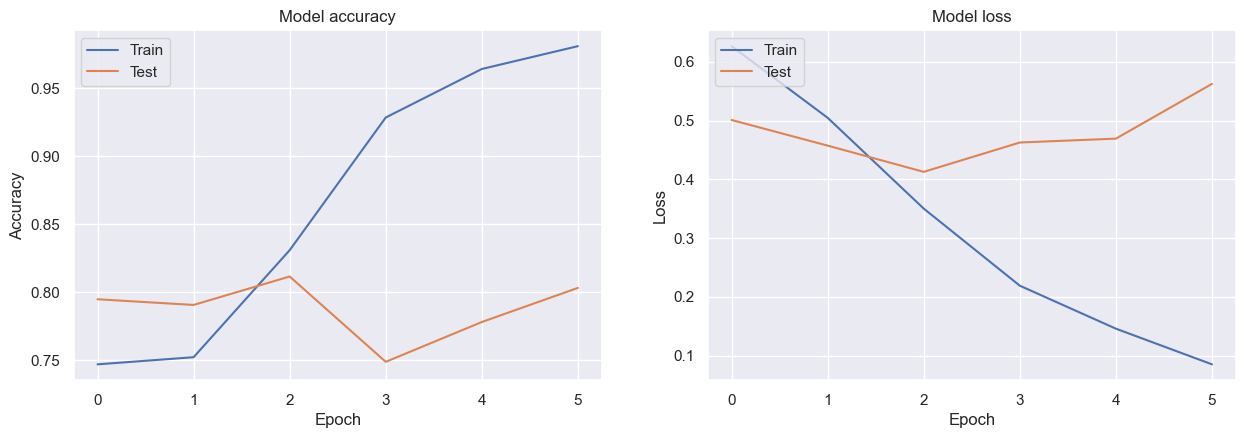

10/10 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

    negative       0.57      0.35      0.43        71
    positive       0.82      0.92      0.86       227

    accuracy                           0.78       298
   macro avg       0.69      0.63      0.65       298
weighted avg       0.76      0.78      0.76       298

10/10 [==============================] - 0s 28ms/step

The balanced accuracy is : 63.42%

10/10 [==============================] - 0s 29ms/step

The Zero-one Loss is : 21.81%

10/10 [==============================] - 0s 26ms/step

Explained variance score: -0.157

10/10 [==============================] - 0s 24ms/step

ROC AUC=0.765 



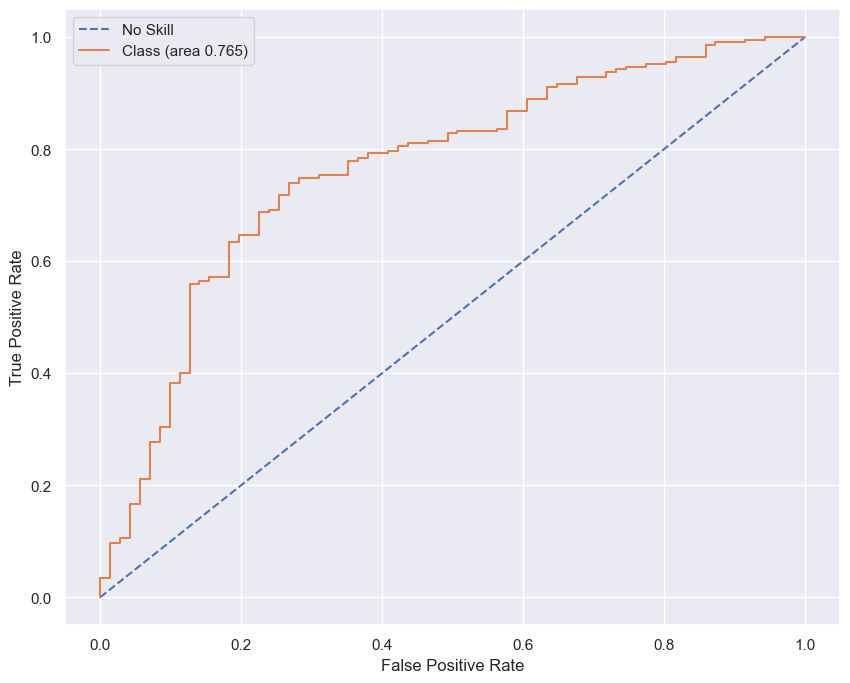

10/10 [==============================] - 0s 25ms/step


Model: f1-score=0.865 AUC=0.897




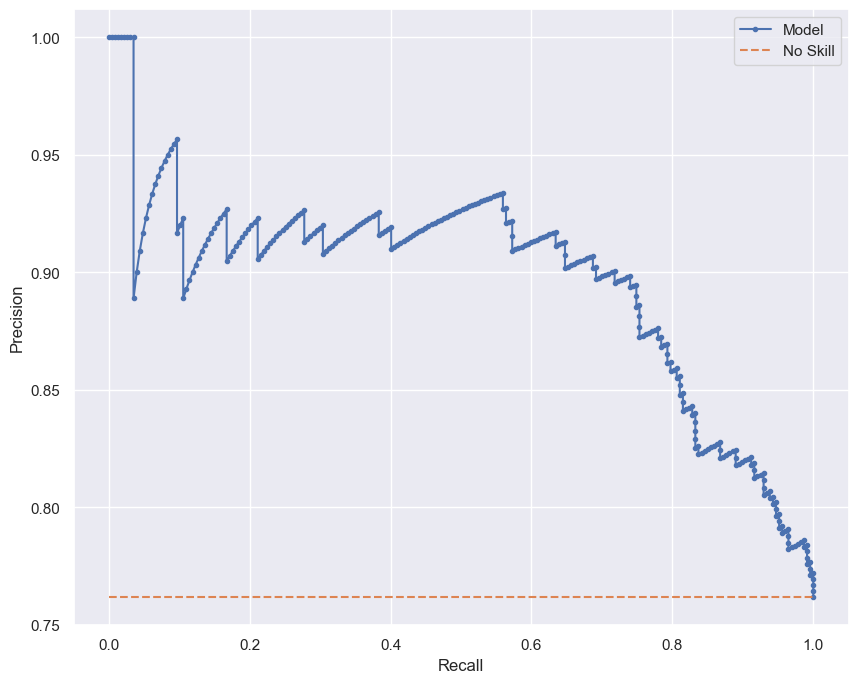

10/10 [==============================] - 0s 25ms/step

Cohen's kappa: 30.88% 

10/10 [==============================] - 0s 24ms/step

Confusion Matrix



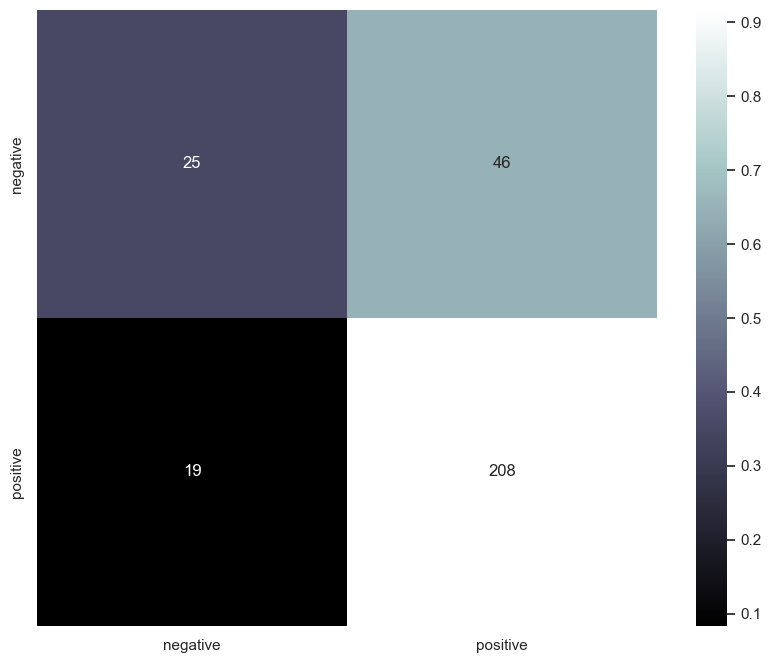

In [102]:
if lstm:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [103]:
def create_cnn_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a convulational neural network lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network lstm
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.LSTM(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model
if cnn_lstm:
    model = create_cnn_lstm_model(word_index, pre_trained=pre_trained)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 100)         643600    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         64128     
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                      

C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 5s 87ms/step - loss: 0.5800 - accuracy: 0.7356 - val_loss: 0.5025 - val_accuracy: 0.7950
Epoch 2/50
30/30 [==============================] - 2s 69ms/step - loss: 0.4794 - accuracy: 0.7597 - val_loss: 0.4365 - val_accuracy: 0.8243
Epoch 3/50
30/30 [==============================] - 2s 68ms/step - loss: 0.2651 - accuracy: 0.8930 - val_loss: 0.4006 - val_accuracy: 0.8285
Epoch 4/50
30/30 [==============================] - 2s 68ms/step - loss: 0.1114 - accuracy: 0.9643 - val_loss: 0.4805 - val_accuracy: 0.8033
Epoch 5/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0490 - accuracy: 0.9885 - val_loss: 0.5384 - val_accuracy: 0.7824
Epoch 6/50
30/30 [==============================] - 2s 67ms/step - loss: 0.0227 - accuracy: 0.9948 - val_loss: 0.6015 - val_accuracy: 0.7992


In [104]:
if cnn_lstm:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

10/10 [==============================] - 0s 15ms/step - loss: 0.7825 - accuracy: 0.7517
[0.7825363874435425, 0.7516778707504272]


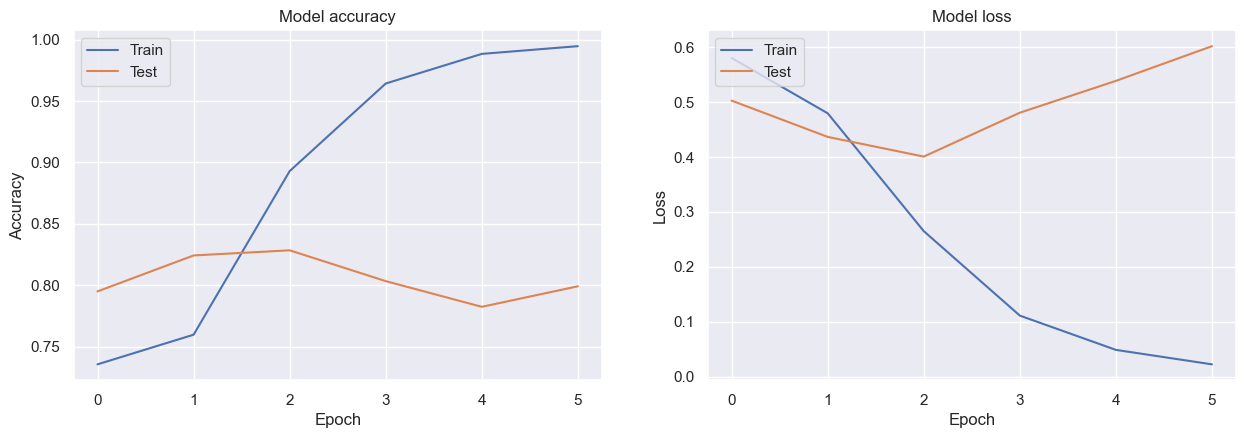

10/10 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

    negative       0.47      0.34      0.39        71
    positive       0.81      0.88      0.84       227

    accuracy                           0.75       298
   macro avg       0.64      0.61      0.62       298
weighted avg       0.73      0.75      0.74       298

10/10 [==============================] - 0s 16ms/step

The balanced accuracy is : 60.95%

10/10 [==============================] - 0s 16ms/step

The Zero-one Loss is : 24.83%

10/10 [==============================] - 0s 15ms/step

Explained variance score: -0.343

10/10 [==============================] - 0s 15ms/step

ROC AUC=0.750 



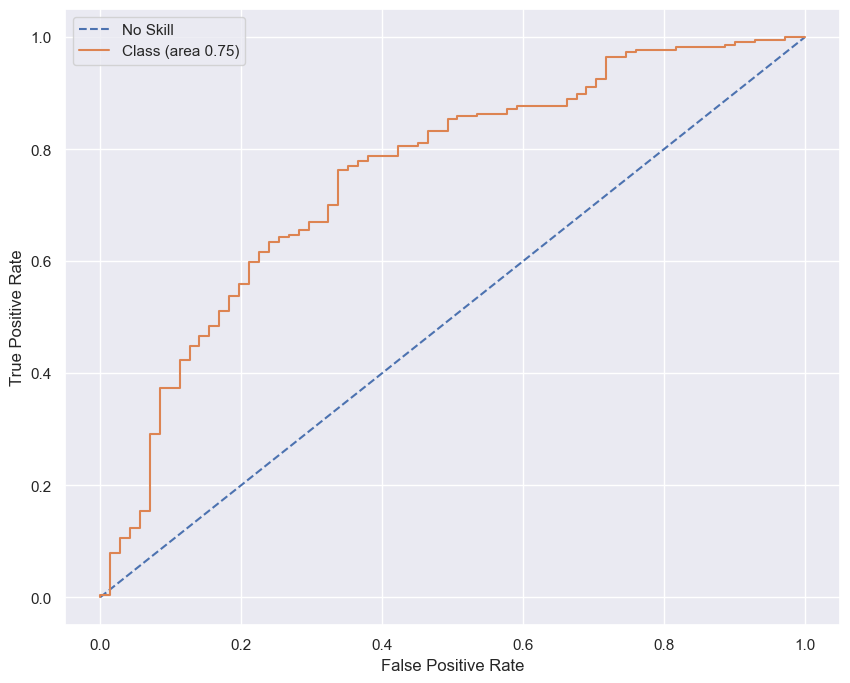

10/10 [==============================] - 0s 15ms/step


Model: f1-score=0.844 AUC=0.882




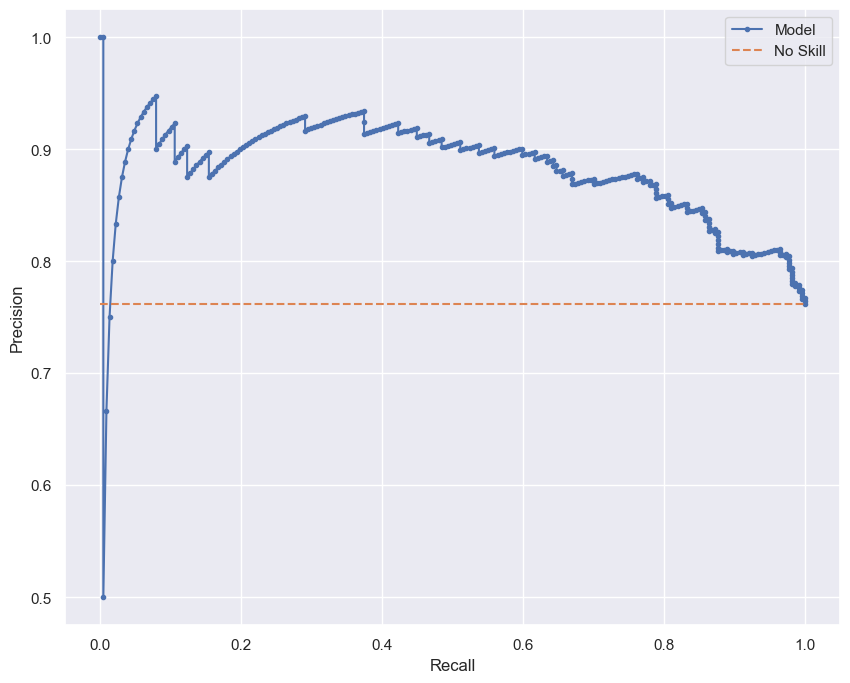

10/10 [==============================] - 0s 16ms/step

Cohen's kappa: 24.26% 

10/10 [==============================] - 0s 16ms/step

Confusion Matrix



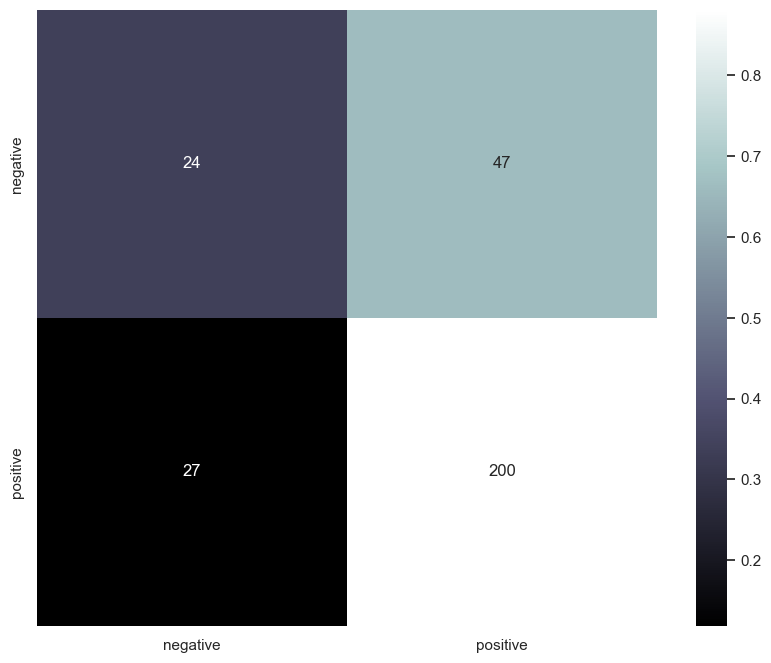

In [105]:
if cnn_lstm:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [108]:
def create_cnn_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a convulational neural network GRU for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network GRU
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.GRU(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model
if cnn_gru:
    model = create_cnn_gru_model(word_index, pre_trained=pre_trained)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 100)         643600    
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         64128     
                                                                 
 dropout_6 (Dropout)         (None, None, 128)         0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                            
                                                                 
 gru_1 (GRU)                 (None, 32)                15552     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                      

C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 5s 85ms/step - loss: 0.5871 - accuracy: 0.7366 - val_loss: 0.5007 - val_accuracy: 0.7950
Epoch 2/50
30/30 [==============================] - 2s 71ms/step - loss: 0.4719 - accuracy: 0.7545 - val_loss: 0.4377 - val_accuracy: 0.7950
Epoch 3/50
30/30 [==============================] - 2s 71ms/step - loss: 0.2835 - accuracy: 0.8667 - val_loss: 0.4204 - val_accuracy: 0.8243
Epoch 4/50
30/30 [==============================] - 2s 71ms/step - loss: 0.1274 - accuracy: 0.9517 - val_loss: 0.4946 - val_accuracy: 0.7908
Epoch 5/50
30/30 [==============================] - 2s 71ms/step - loss: 0.0425 - accuracy: 0.9927 - val_loss: 0.5570 - val_accuracy: 0.8117
Epoch 6/50
30/30 [==============================] - 2s 73ms/step - loss: 0.0178 - accuracy: 0.9948 - val_loss: 0.6196 - val_accuracy: 0.7992


10/10 [==============================] - 0s 15ms/step - loss: 0.9395 - accuracy: 0.7550
[0.9394723773002625, 0.755033552646637]


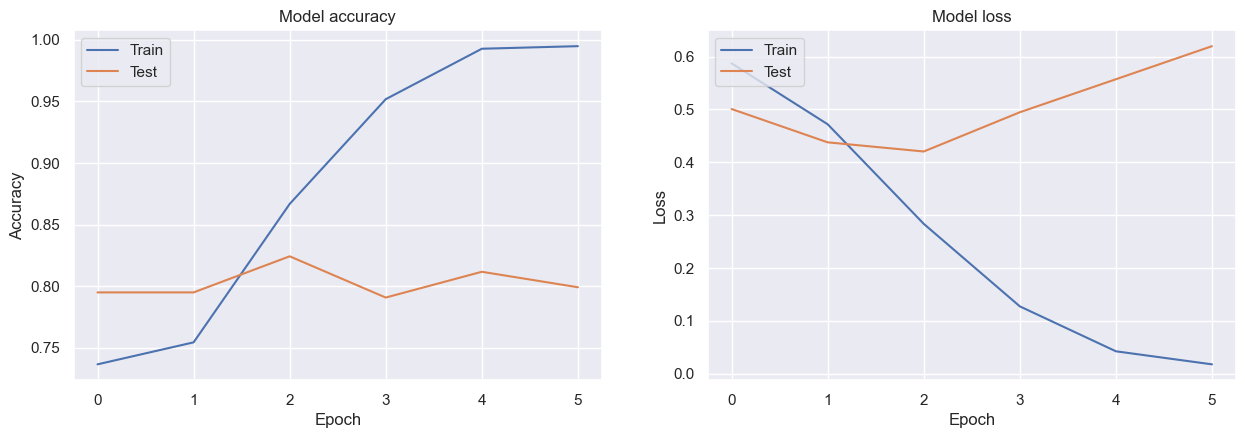

10/10 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

    negative       0.48      0.31      0.38        71
    positive       0.81      0.89      0.85       227

    accuracy                           0.76       298
   macro avg       0.64      0.60      0.61       298
weighted avg       0.73      0.76      0.74       298

10/10 [==============================] - 0s 14ms/step

The balanced accuracy is : 60.21%

10/10 [==============================] - 0s 14ms/step

The Zero-one Loss is : 24.5%

10/10 [==============================] - 0s 14ms/step

Explained variance score: -0.311

10/10 [==============================] - 0s 14ms/step

ROC AUC=0.731 



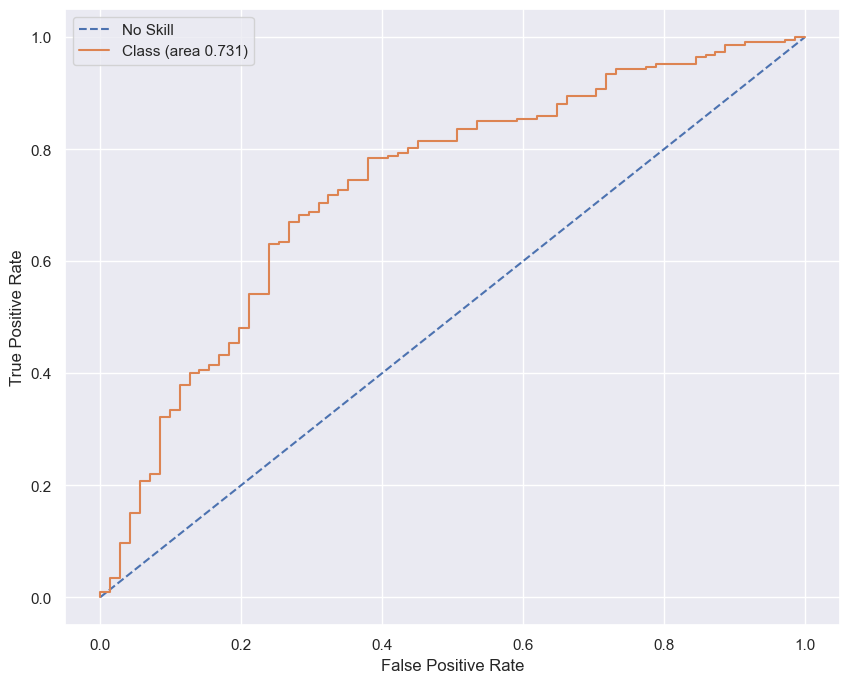

10/10 [==============================] - 0s 14ms/step


Model: f1-score=0.848 AUC=0.874




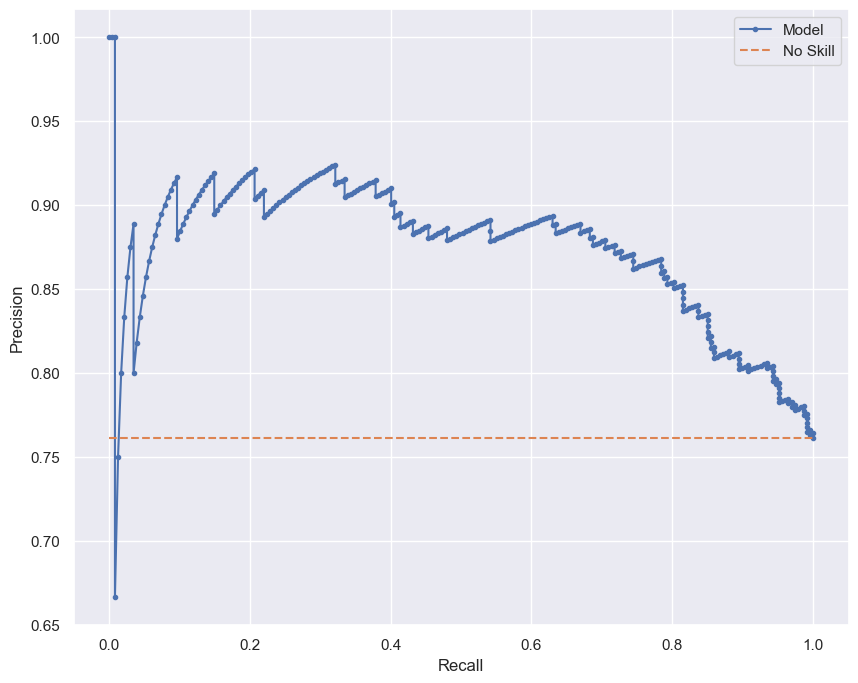

10/10 [==============================] - 0s 14ms/step

Cohen's kappa: 23.22% 

10/10 [==============================] - 0s 14ms/step

Confusion Matrix



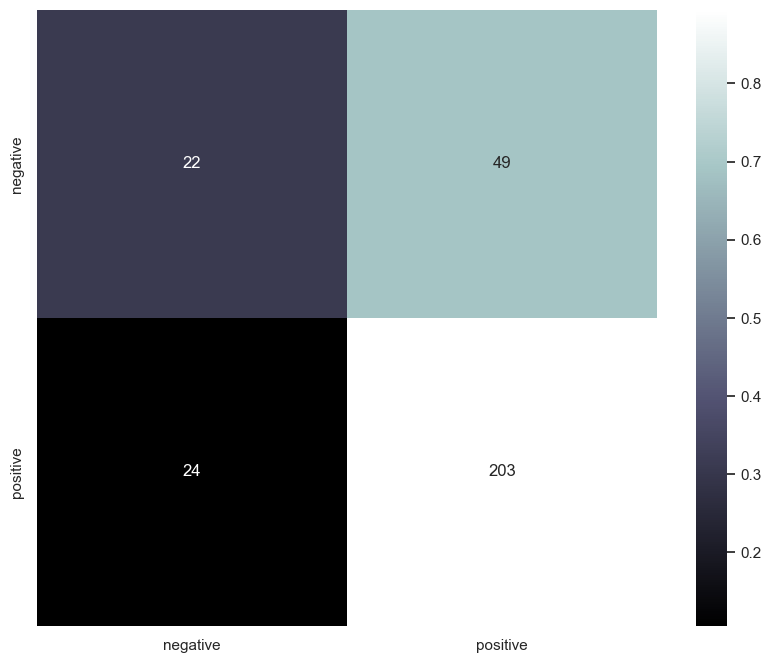

In [109]:
if cnn_gru:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

if cnn_gru:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [110]:
def create_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a gru for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) gru 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.GRU(32),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model
if gru:
    model = create_gru_model(word_index, pre_trained=pre_trained )


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 100)         643600    
                                                                 
 gru_2 (GRU)                 (None, 32)                12864     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 656497 (2.50 MB)
Trainable params: 656497 (2.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50


C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 5s 114ms/step - loss: 0.6385 - accuracy: 0.7314 - val_loss: 0.5361 - val_accuracy: 0.7950
Epoch 2/50
30/30 [==============================] - 3s 115ms/step - loss: 0.5262 - accuracy: 0.7513 - val_loss: 0.4912 - val_accuracy: 0.7950
Epoch 3/50
30/30 [==============================] - 3s 98ms/step - loss: 0.4002 - accuracy: 0.7807 - val_loss: 0.4517 - val_accuracy: 0.8117
Epoch 4/50
30/30 [==============================] - 3s 101ms/step - loss: 0.2202 - accuracy: 0.9129 - val_loss: 0.5087 - val_accuracy: 0.7573
Epoch 5/50
30/30 [==============================] - 3s 96ms/step - loss: 0.1301 - accuracy: 0.9601 - val_loss: 0.6276 - val_accuracy: 0.8159
Epoch 6/50
30/30 [==============================] - 3s 97ms/step - loss: 0.0807 - accuracy: 0.9780 - val_loss: 0.6636 - val_accuracy: 0.7741


10/10 [==============================] - 0s 21ms/step - loss: 0.7934 - accuracy: 0.7349
[0.7933871150016785, 0.7348993420600891]


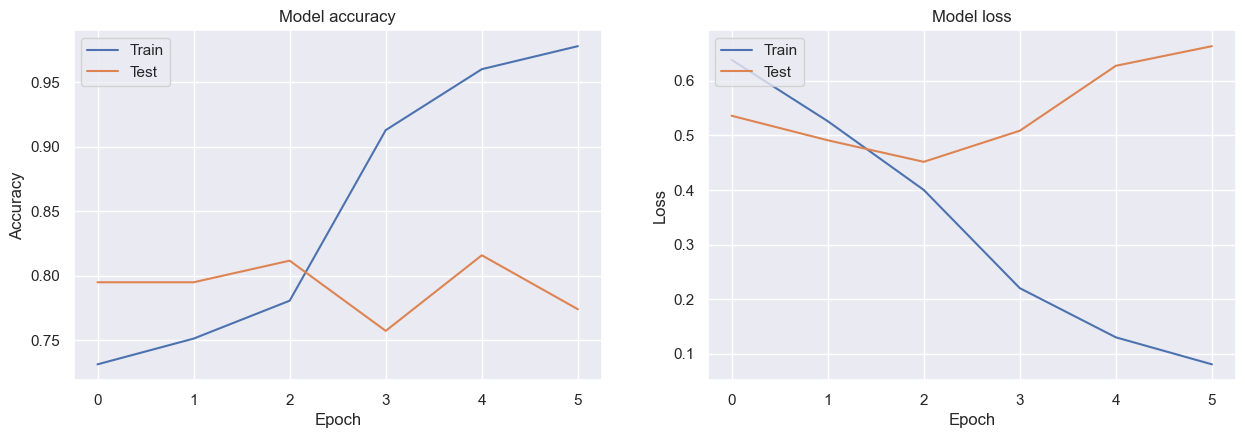

10/10 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

    negative       0.43      0.32      0.37        71
    positive       0.80      0.86      0.83       227

    accuracy                           0.73       298
   macro avg       0.61      0.59      0.60       298
weighted avg       0.71      0.73      0.72       298

10/10 [==============================] - 0s 20ms/step

The balanced accuracy is : 59.37%

10/10 [==============================] - 0s 21ms/step

The Zero-one Loss is : 26.51%

10/10 [==============================] - 0s 20ms/step

Explained variance score: -0.443

10/10 [==============================] - 0s 20ms/step

ROC AUC=0.725 



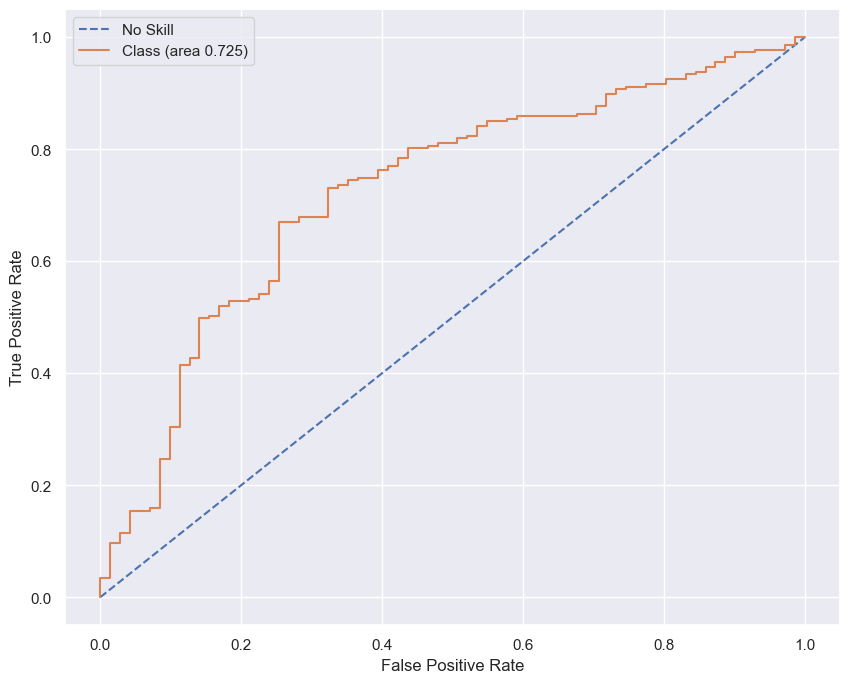

10/10 [==============================] - 0s 20ms/step


Model: f1-score=0.832 AUC=0.880




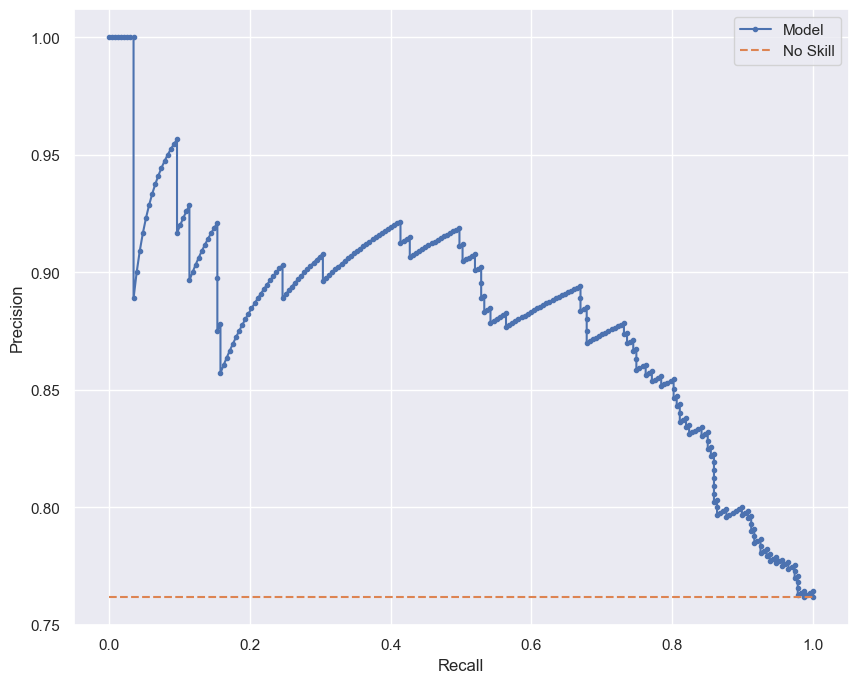

10/10 [==============================] - 0s 20ms/step

Cohen's kappa: 20.42% 

10/10 [==============================] - 0s 22ms/step

Confusion Matrix



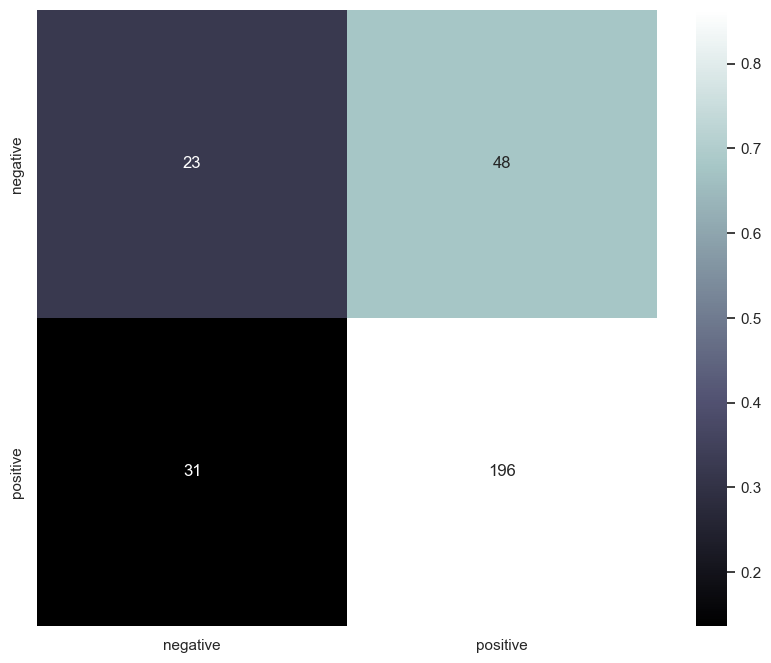

In [112]:
if gru:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [113]:
def create_bidirec_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a bidirectional rnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectional rnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model
if bidirectional_rnn:
    model = create_bidirec_rnn_model(word_index, pre_trained=pre_trained)
    
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 100)         643600    
                                                                 
 bidirectional (Bidirection  (None, None, 64)          8512      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 64)          6208      
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 64)          6208      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                6208      
 onal)                                               

C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 15s 330ms/step - loss: 0.5832 - accuracy: 0.7251 - val_loss: 0.5236 - val_accuracy: 0.7950
Epoch 2/50
30/30 [==============================] - 9s 290ms/step - loss: 0.3547 - accuracy: 0.8478 - val_loss: 0.6534 - val_accuracy: 0.6778
Epoch 3/50
30/30 [==============================] - 9s 296ms/step - loss: 0.1151 - accuracy: 0.9738 - val_loss: 0.8365 - val_accuracy: 0.6234
Epoch 4/50
30/30 [==============================] - 9s 294ms/step - loss: 0.0358 - accuracy: 0.9979 - val_loss: 1.0422 - val_accuracy: 0.5816


10/10 [==============================] - 1s 63ms/step - loss: 0.8635 - accuracy: 0.6879
[0.8634915947914124, 0.6879194378852844]


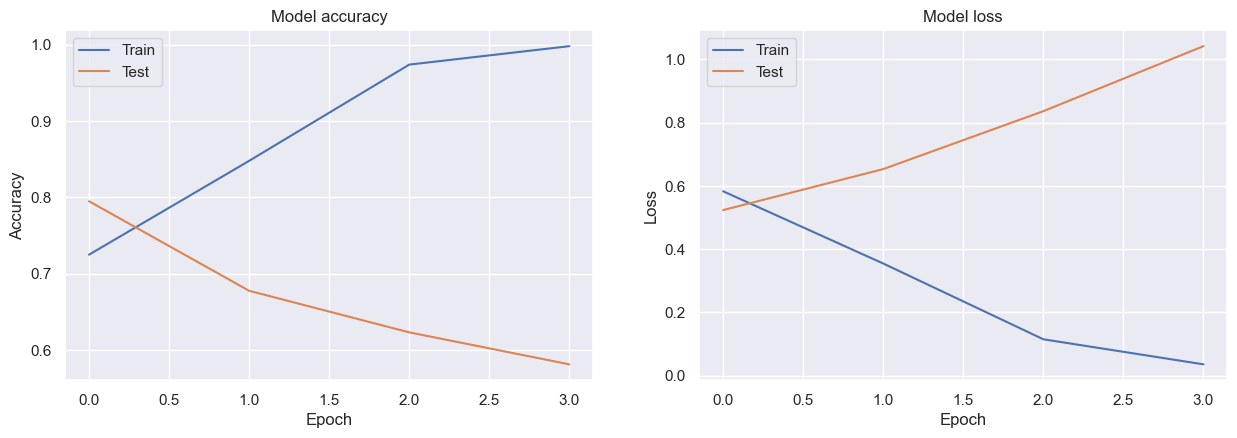

10/10 [==============================] - 1s 71ms/step
              precision    recall  f1-score   support

    negative       0.33      0.30      0.31        71
    positive       0.79      0.81      0.80       227

    accuracy                           0.69       298
   macro avg       0.56      0.55      0.55       298
weighted avg       0.68      0.69      0.68       298

10/10 [==============================] - 1s 70ms/step

The balanced accuracy is : 55.32%

10/10 [==============================] - 1s 68ms/step

The Zero-one Loss is : 31.21%

10/10 [==============================] - 1s 69ms/step

Explained variance score: -0.717

10/10 [==============================] - 1s 69ms/step

ROC AUC=0.542 



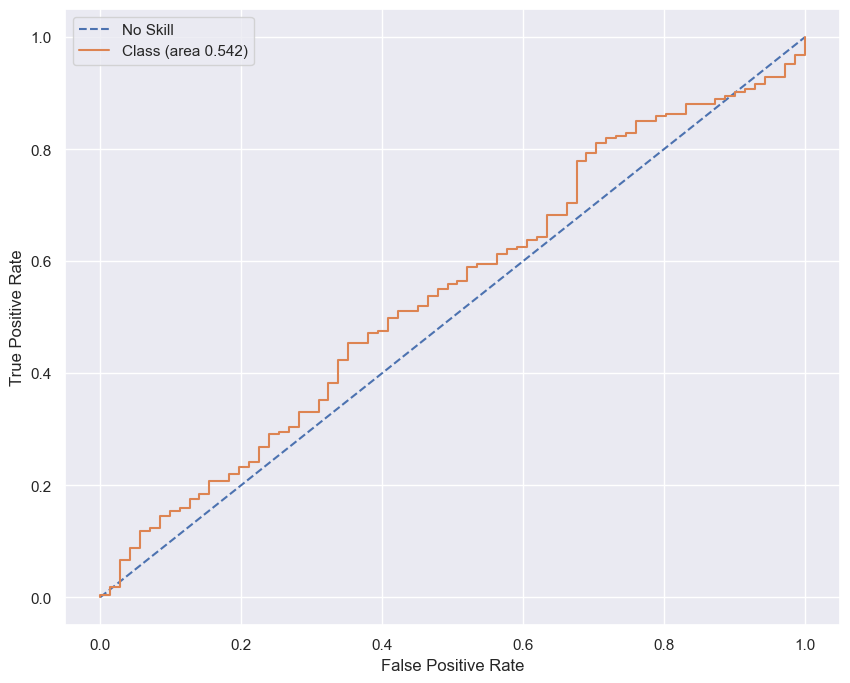

10/10 [==============================] - 1s 64ms/step


Model: f1-score=0.798 AUC=0.787




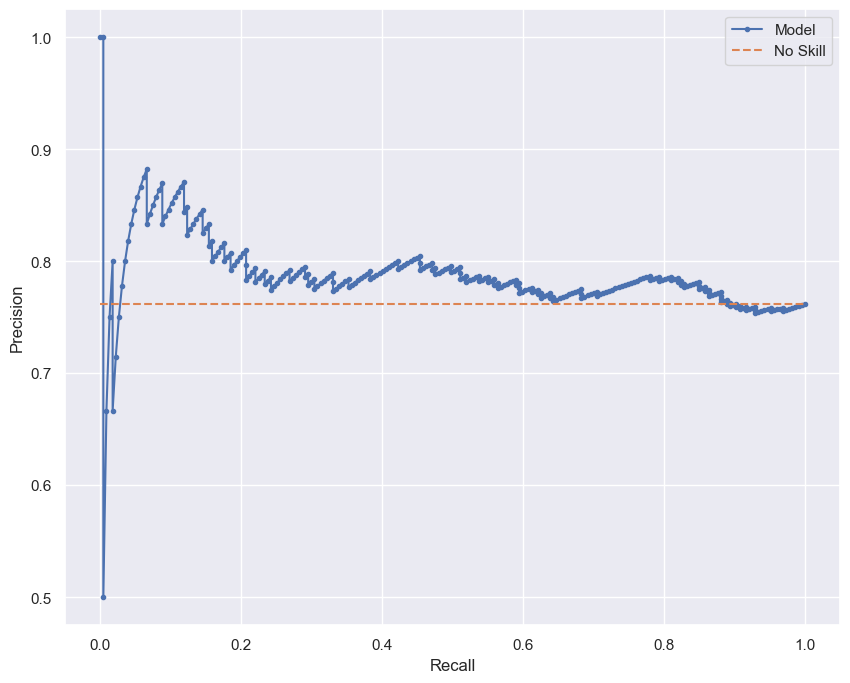

10/10 [==============================] - 1s 65ms/step

Cohen's kappa: 11.01% 

10/10 [==============================] - 1s 64ms/step

Confusion Matrix



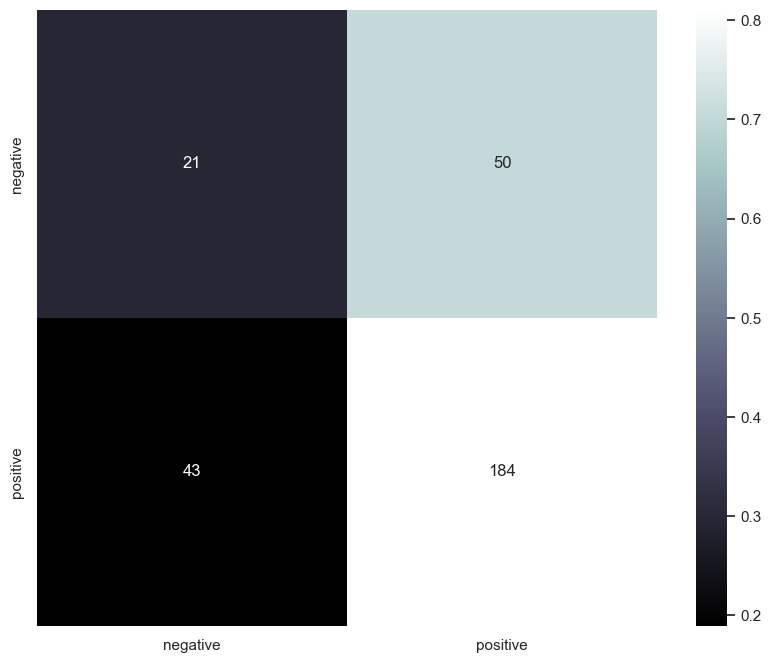

In [114]:
if bidirectional_rnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [115]:
def create_rcnn(X, word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300,input_length=X.shape[1], weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True)),
    keras.layers.Convolution1D(32, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model
if rcnn:
    model = create_rcnn(train_seq_x, word_index,  pre_trained = pre_trained)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 100)         643600    
                                                                 
 spatial_dropout1d (Spatial  (None, None, 100)         0         
 Dropout1D)                                                      
                                                                 
 bidirectional_4 (Bidirecti  (None, None, 64)          25728     
 onal)                                                           
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          6176      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                     

C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 9s 167ms/step - loss: 0.6383 - accuracy: 0.6863 - val_loss: 0.5137 - val_accuracy: 0.7950
Epoch 2/50
30/30 [==============================] - 4s 144ms/step - loss: 0.5615 - accuracy: 0.7513 - val_loss: 0.5169 - val_accuracy: 0.7950
Epoch 3/50
30/30 [==============================] - 4s 147ms/step - loss: 0.5620 - accuracy: 0.7513 - val_loss: 0.4938 - val_accuracy: 0.7950
Epoch 4/50
30/30 [==============================] - 4s 141ms/step - loss: 0.4915 - accuracy: 0.7545 - val_loss: 0.5071 - val_accuracy: 0.8243
Epoch 5/50
30/30 [==============================] - 4s 138ms/step - loss: 0.3571 - accuracy: 0.8625 - val_loss: 0.3855 - val_accuracy: 0.8159
Epoch 6/50
30/30 [==============================] - 4s 142ms/step - loss: 0.2257 - accuracy: 0.9140 - val_loss: 0.4335 - val_accuracy: 0.7950
Epoch 7/50
30/30 [==============================] - 4s 144ms/step - loss: 0.1362 - accuracy: 0.9601 - val_loss: 0.4495 - val_accuracy: 0.8285
Epoch 8/50
30/30 

10/10 [==============================] - 0s 30ms/step - loss: 0.7914 - accuracy: 0.8054
[0.7914145588874817, 0.8053691387176514]


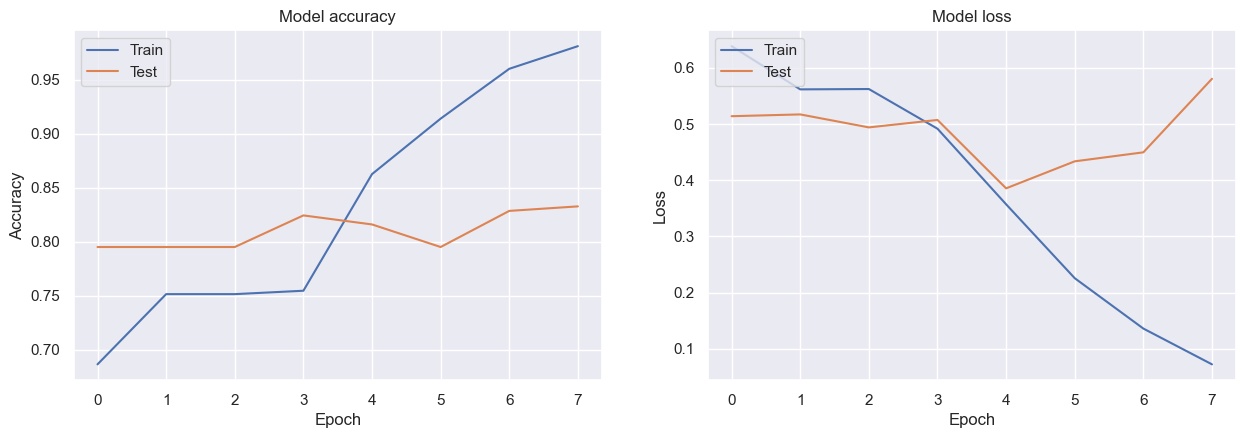

10/10 [==============================] - 1s 29ms/step
              precision    recall  f1-score   support

    negative       0.61      0.51      0.55        71
    positive       0.85      0.90      0.88       227

    accuracy                           0.81       298
   macro avg       0.73      0.70      0.71       298
weighted avg       0.80      0.81      0.80       298

10/10 [==============================] - 0s 28ms/step

The balanced accuracy is : 70.29%

10/10 [==============================] - 0s 28ms/step

The Zero-one Loss is : 19.46%

10/10 [==============================] - 0s 28ms/step

Explained variance score: -0.063

10/10 [==============================] - 0s 28ms/step

ROC AUC=0.794 



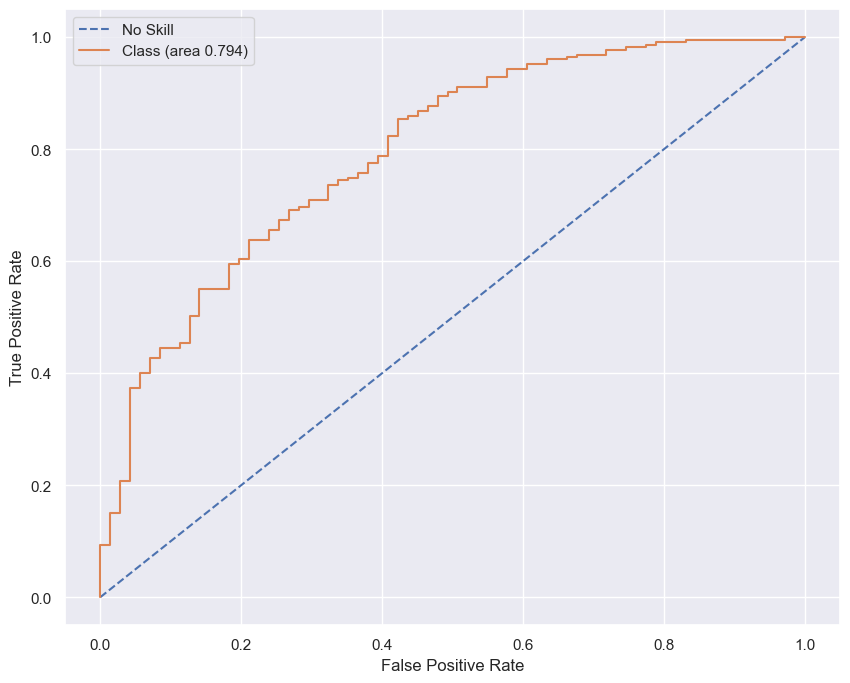

10/10 [==============================] - 0s 27ms/step


Model: f1-score=0.876 AUC=0.917




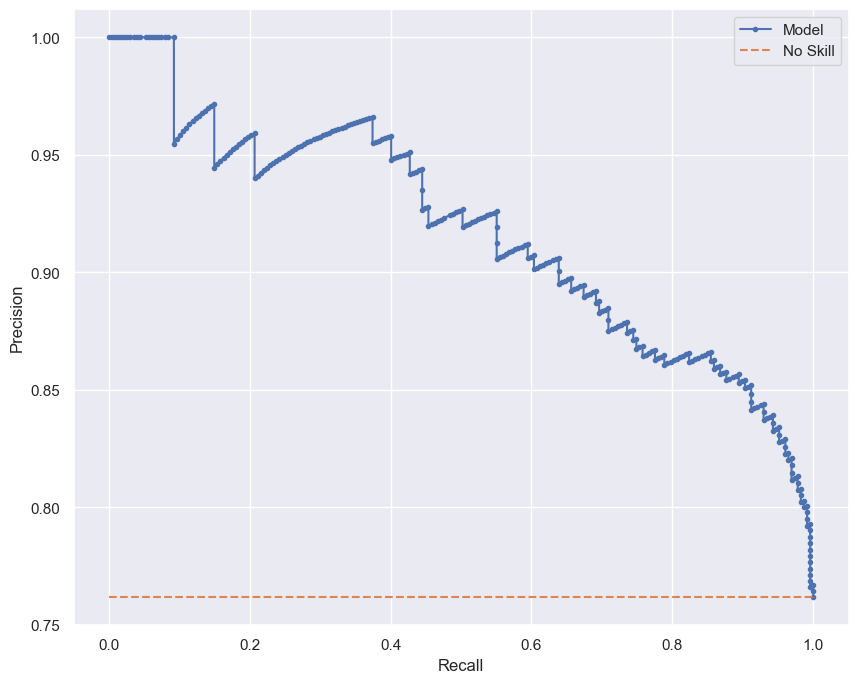

10/10 [==============================] - 0s 28ms/step

Cohen's kappa: 43.07% 

10/10 [==============================] - 0s 29ms/step

Confusion Matrix



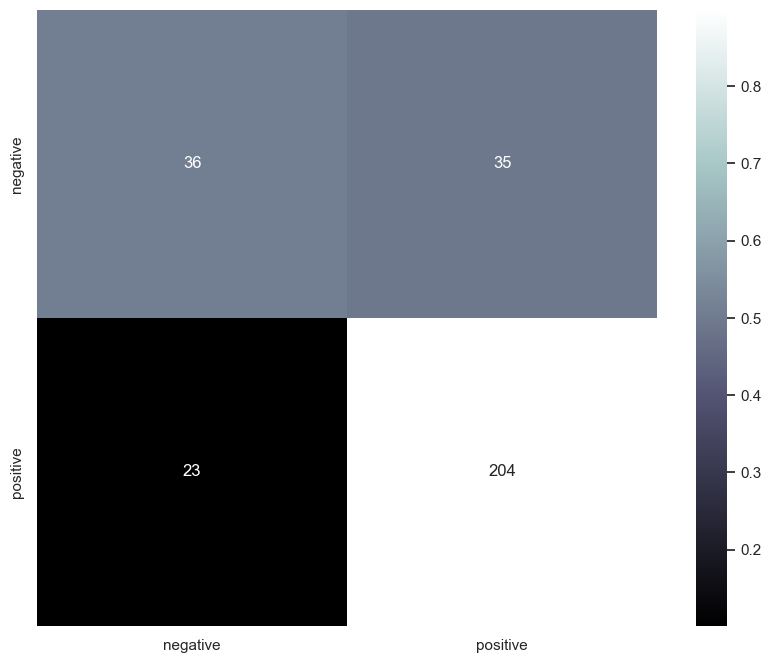

In [116]:
if rcnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

In [117]:
from tensorflow.keras import layers

In [118]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [119]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [120]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, emded_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=emded_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=emded_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [121]:
def transformers_classifier(word_index, label=labels):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    vocab_size = len(word_index)+1
    maxlen = 300
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    #outputs = layers.Dense(1, activation="sigmoid")(x)
    
    outputs = keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [123]:
#pip install transformers
import transformers

In [124]:
if transformers:
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    vocab_size = len(word_index)+1
    maxlen = 300
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

In [125]:
if transformers:
    model_transformers = transformers_classifier(word_index, label=labels)
    
    history = model_transformers.fit(
    train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2, batch_size=32
    )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 token_and_position_embeddi  (None, 300, 32)           215552    
 ng_1 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_1 (Trans  (None, 300, 32)           6464      
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_5  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_16 (Dropout)        (None, 32)                0   

C:\Users\omarb\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 7s 138ms/step - loss: 0.5727 - accuracy: 0.7503 - val_loss: 0.5152 - val_accuracy: 0.7950
Epoch 2/50
30/30 [==============================] - 4s 125ms/step - loss: 0.5701 - accuracy: 0.7492 - val_loss: 0.5167 - val_accuracy: 0.7950
Epoch 3/50
30/30 [==============================] - 4s 128ms/step - loss: 0.5646 - accuracy: 0.7492 - val_loss: 0.5172 - val_accuracy: 0.7950
Epoch 4/50
30/30 [==============================] - 4s 129ms/step - loss: 0.5645 - accuracy: 0.7471 - val_loss: 0.5125 - val_accuracy: 0.7950
Epoch 5/50
30/30 [==============================] - 4s 129ms/step - loss: 0.5647 - accuracy: 0.7513 - val_loss: 0.5161 - val_accuracy: 0.7950
Epoch 6/50
30/30 [==============================] - 4s 126ms/step - loss: 0.5597 - accuracy: 0.7513 - val_loss: 0.5160 - val_accuracy: 0.7950
Epoch 7/50
30/30 [==============================] - 4s 129ms/step - loss: 0.5678 - accuracy: 0.7492 - val_loss: 0.5146 - val_accuracy: 0.7950


In [126]:
if transformers:
    results = model_transformers.evaluate(valid_seq_x, valid_y)

    print(results)

10/10 [==============================] - 0s 43ms/step - loss: 0.5465 - accuracy: 0.7617
[0.5465043783187866, 0.7617449760437012]
